In [4]:
# Import all necessary packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time
import pickle

warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, f1_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from scipy import stats

from xgboost.sklearn import XGBRegressor, XGBClassifier
import xgboost as xgb

from os import path

<center><h1 style="color:red;border:1px solid blue;border-radius:20px;padding:10px 15px;line-height:27px">
    Examining the Factors that Impact Fellow Placement & Fellow Placement Time
</h1></center>

<h3 >
    Author: <span style="color:blue">Farzane Kargozari<span/>
</h3>


This is my entry for Pathrise's take-home data challenge. 

My main goal for this challenge is to derive insights about whether or not a fellow will be placed, and how long a placement can be expected.

So, I'm looking at two kinds of problems: 
- **Classification**: Will a fellow be placed?
- **Regression**: How long will it take the fellow to be placed?

## Other questions to consider
Some questions I have straight off the bat:
- How does the distribution look for the different tracks?
- What do typical fellows look like?
- What factors affect fellow retention? A fellow can't be placed if they're no longer interested in Pathrise. 

Let's get started.

## What are we dealing with?

In [2]:
df = pd.read_excel('data_Pathrise.xlsx')
df.head()

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
0,1,Active,SWE,OCT19A,NaN,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American
1,2,Active,PSO,JAN20A,NaN,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American
2,3,Closed Lost,Design,AUG19B,0.0,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American
3,4,Closed Lost,PSO,AUG19B,0.0,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify
4,5,Placed,SWE,AUG19A,89.0,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American


In [3]:
print('There are %s fellows and %s features.' % df.shape)

There are 2544 fellows and 16 features.


In [4]:
df[df['placed'] == 1]['pathrise_status']

4       Placed
23      Placed
30      Placed
39      Placed
54      Placed
         ...  
2527    Placed
2528    Placed
2531    Placed
2533    Placed
2534    Placed
Name: pathrise_status, Length: 956, dtype: object

[Text(0, 0, 'Male'),
 Text(1, 0, 'Female'),
 Text(2, 0, 'MISSING_GENDER'),
 Text(3, 0, 'Decline to Self Identify'),
 Text(4, 0, 'Non-Binary')]

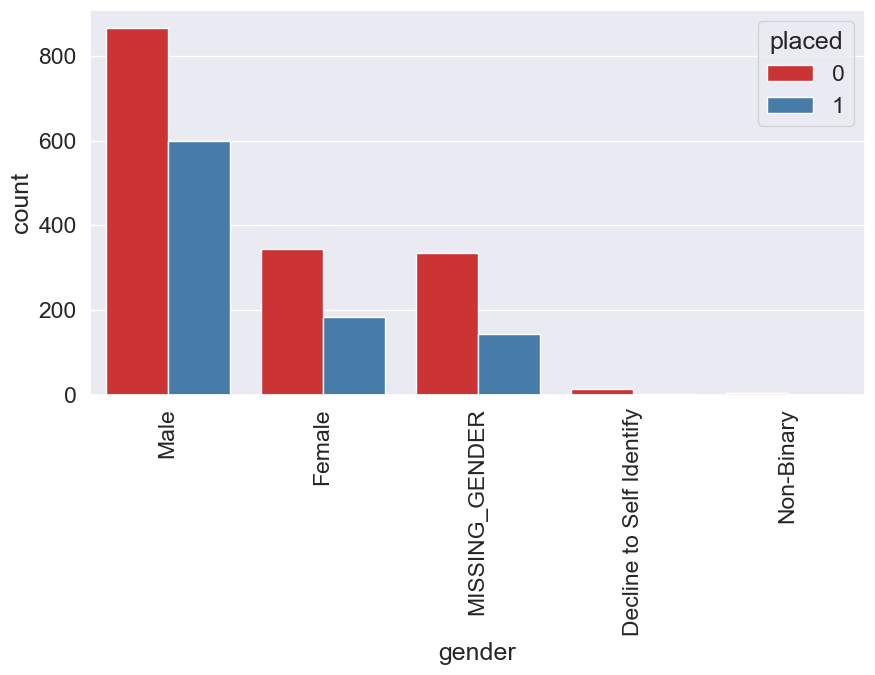

In [177]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=df,
    x='gender',
    hue=df['placed'],
    palette='Set1'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [ ]:
# Get the proportion of fellows placed
prop_placed = df['placed'].sum() / df.shape[0] 
print("%.2f%% of fellows were placed in companies." % (prop_placed * 100))

# Sanity checking pathrise_status
## First, check if proportion matches
assert prop_placed == df[df['pathrise_status'] == 'Placed']['pathrise_status'].count() / df.shape[0]

## Second, check if rows match correctly i.e., pathrise_status is "Placed" where placed is 1
assert any(df[df['placed'] == 1].index.values == df[df['pathrise_status'] == 'Placed'].index.values)

In [6]:
# Get the average placement time 
## Two variables to examine: program_duration_days and length_of_job_search
avg_prog_duration = np.mean(df[df['placed'] == 1]['program_duration_days'])
mode_job_search_len = df[df['placed'] == 1]['length_of_job_search'].describe().top

print('Placed fellows, on average, spent about %.2f days in the program.' % avg_prog_duration)
print('A majority of placed fellows spent about %s job searching.' % mode_job_search_len)

Placed fellows, on average, spent about 161.12 days in the program.
A majority of placed fellows spent about 1-2 months job searching.


In [7]:
df.isnull().sum()/len(df)

id                             0.000000
pathrise_status                0.000000
primary_track                  0.000000
cohort_tag                     0.003145
program_duration_days          0.242138
placed                         0.000000
employment_status              0.090016
highest_level_of_education     0.022799
length_of_job_search           0.029088
biggest_challenge_in_search    0.009434
professional_experience        0.087264
work_authorization_status      0.111635
number_of_interviews           0.085692
number_of_applications         0.000000
gender                         0.193396
race                           0.007075
dtype: float64

**Features of importance: `placed` & `program_duration_days`**

There still might be some missing data disrupting what we see above. Let's take a look at that.

| Feature 	| Description 	| Comments 	|
|-	|-	|-	|
| `id` 	| The ID of the fellow 	|  	|
| `pathrise_status` 	| The status of the fellow. 	| I'm not sure what some values, such as MIA and Closed Lost, mean, Given the context, I believe that MIA means that the fellow has not checked in for a while, and that Closed Lost means that fellows are dropped for not checking in. 	|
| `primary_track` 	| The track the fellow is in.  	|  	|
| `cohort_tag` 	| The tag for the fellow's cohort.  	| Some cohorts reach as far back as 2018, so I'll have to look more into this, since Pathrise claims to terminate the contract of fellows who haven't found a job within a year. 	|
| `program_duration_days` 	| The number of days the fellow was in the program. 	| I'm not sure how this was recorded, as some fellows are missing this information. I'm also not sure why some fellows have 0 days in the program despite being in a cohort from 2019. I'll have to do more digging. 	|
| `placed` 	| The fellow placed at a company. 	|  	|
| `employment_status` 	| The fellow's employment status. 	| I assume that this is prior to coming into Pathrise. 	|
| `highest_level_of_education` 	| The highest level of education the fellow recently completed. 	|  	|
| `length_of_job_search` 	| How long the fellow has been look for a job. 	| I assume this is prior to being accepted into Pathrise. 	|
| `biggest_challenge_in_search` 	| The biggest challenge the fellow faces in finding a job. 	|  	|
| `professional_experience` 	| The fellow's professional experience. 	|  	|
| `work_authorization_status` 	| The fellow's work authorization status. 	|  	|
| `number_of_interviews` 	| The number of interviews for the fellow. 	| I'm not sure how this is recorded, as some fellows have more interviews than applications recorded. So, I'm not sure if this is the number of interviews the fellow has prior to Pathrise, the number of interviews on the Pathrise pipeline, or both. 	|
| `number_of_applications` 	| The number of applications the fellow sent. 	| Again, I'm not sure how to interpret these values, similar to reasons for `number_of_interviews`. 	|
| `gender` 	| The fellow's gender. 	|  	|
| `race` 	| The fellow's race. 	|  	|

# Missing Data Analysis

In [8]:
def plot_missing_data(df):
    """
    Plots a bar chart of all of the missing data in the given dataframe.
    The X-axis will contain the features, and the Y-axis will contain the 
    frequency of missing data.
    
    Parameters:
    df - The dataframe to examine
    """
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True, ascending = False)

    ax = missing.plot(kind='bar', figsize = (20, 10))
    ax.set_alpha(0.8)
    ax.set_title("Barplot of Variables and Frequency of Missing Entries")
    ax.set_ylabel("Frequency")
    ax.set_xlabel('Variable Name')

    # Set frequency text
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x(), i.get_height() + 10, \
                str(round((i.get_height()/len(df))*100, 1))+'%', fontsize=15,
                    color='dimgrey')

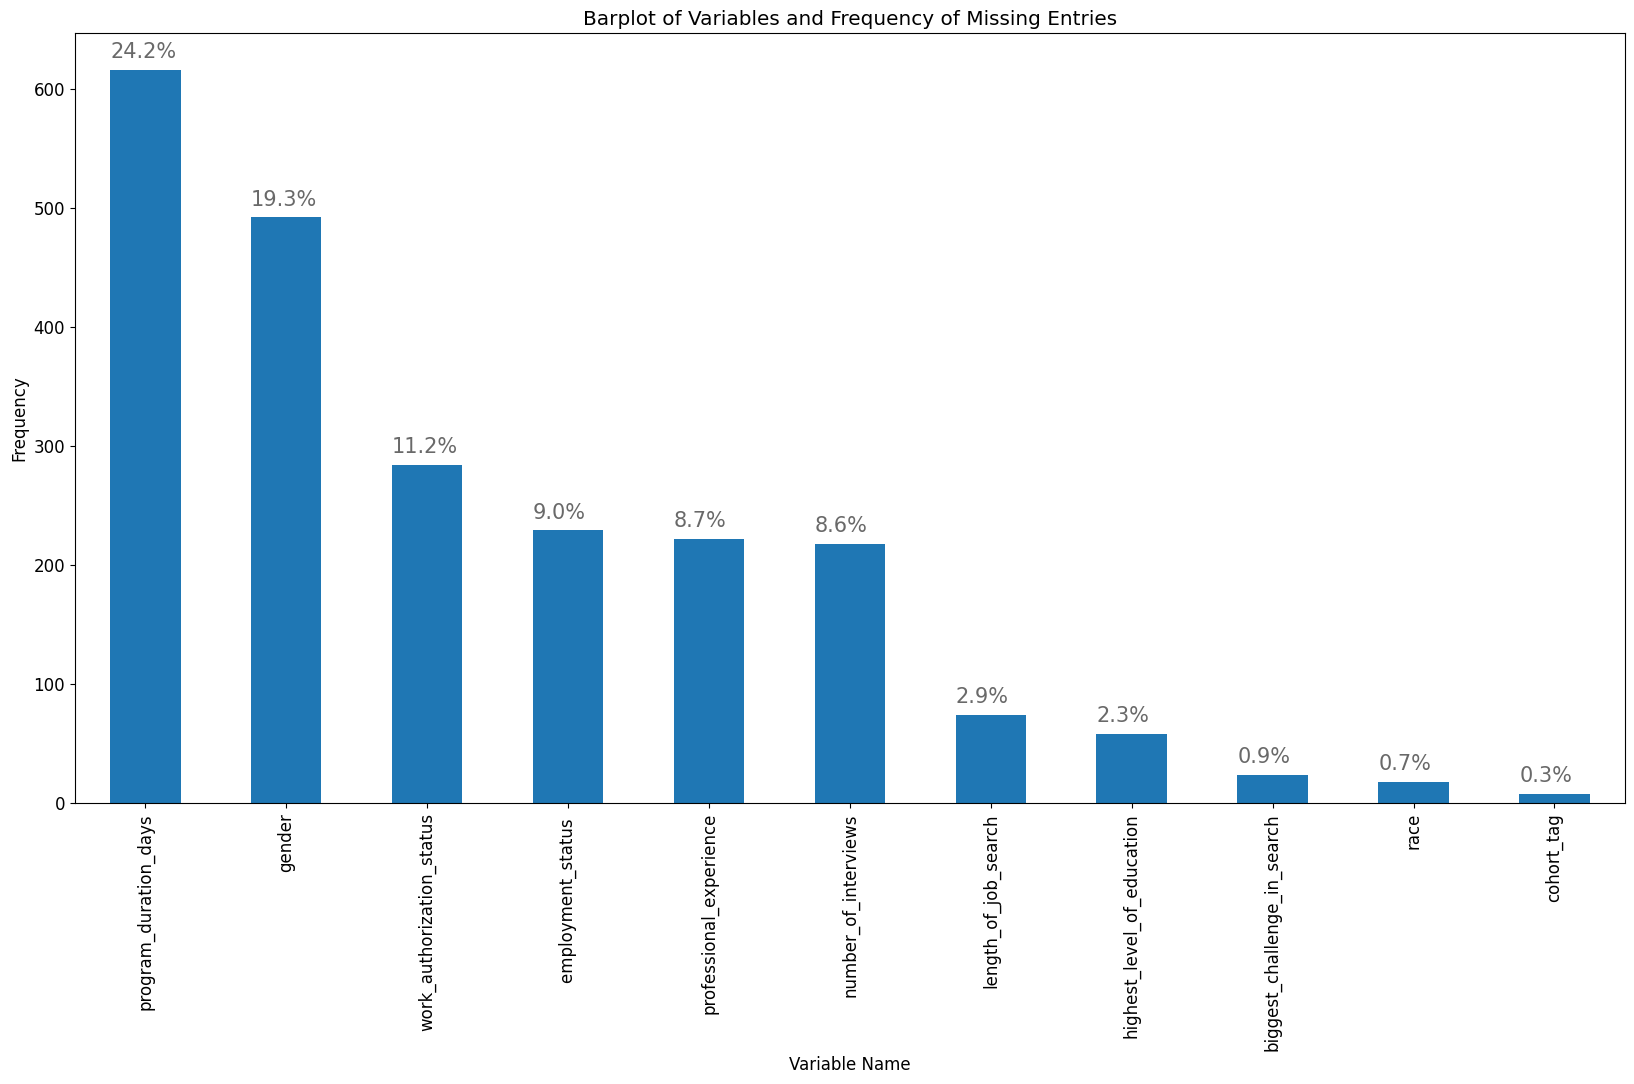

In [9]:
plot_missing_data(df)

**`gender`** - The fellow's gender.

- Some fellows might not be comfortable with sharing this information. 

19.3% of the data is missing this information, so I'll encode the missing data as its own level.

In [10]:
df['gender'].fillna('MISSING_GENDER', inplace = True)

**`work_authorization_status`** - The fellow's work authorization status.

I'll encode the missing data as it's own level, because some fellows might be uncomfortable with letting others know this information or something is happening with their status at the time of accepting the fellowship. Also, almost 10% of fellows are missing this observation, so dropping it might hurt my modelling later on.

In [11]:
df['work_authorization_status'].fillna('MISSING_WORK_AUTH', inplace = True)

**``employment_status``** - The fellow's employment status

I'll deal with this for the same reasons as I did with `work_authorization_status`.

In [12]:
df['employment_status '].fillna('MISSING_EMPL_STATUS', inplace = True)

**``professional_experience``** - How long the fellow has had professional experience.

I'll encode the missing data as its own level because around 8% of the data is missing this.

In [13]:
df['professional_experience'].fillna('MISSING_PRO_EXP', inplace = True)

**``number_of_interviews``** - The number of interviews the fellow has taken.
- Unsure if this is the number of interviews before or during Pathrise. I assume it's during.

Fellows might not have been filling out the pipeline during their job search, which could explain why some of it is missing.
Imputing the missing data as its own level has the side-effect of turning the column into a categorical variable. I want to keep it as a quantitative variable, so instead I'll impute the missing values. Less than 10% of the data is missing this feature, so it's okay to impute it.

In [14]:
# Run a normality test to determine if I should impute using the mean or median
def is_normal(data):
    """
    Returns True if the data given is normal ie. the p-value is less than 0.05. 
    If not, then return False.
    
    Parameters:
    data - The data to test normality of.
    
    Returns True if the data is normal, False otherwise.
    """

    _, p = stats.normaltest(data, nan_policy = 'omit')
    if p < 0.05:
        return False
    else:
        return True

In [15]:
is_normal(df['number_of_interviews'])

False

In [16]:
# Since number_of_interviews is not normal, then impute it using the median
df['number_of_interviews'].fillna(df['number_of_interviews'].median(), inplace = True)

**`length_of_job_search`** - Amount of time fellow has been looking for jobs.
- Unsure of how this is recorded. Is this from the fellow him/herself or from Pathrise? I assume its from the fellow.
- Is this recorded during Pathrise or prior to coming to Pathrise? I'll assume that its prior to coming to Pathrise.

I'll encode the missing data as its own level since only 2.9% of it is missing and since the missing data itself might be a key insight.

In [17]:
df['length_of_job_search'].fillna('MISSING_JOB_SEARCH_LEN', inplace = True)

**`highest_level_of_education`** - The fellow's highest level of education.
- I assume this is recorded at the acceptance of Pathrise fellowship.

I'll encode the missing data as its own level for the same reason above.

In [18]:
df['highest_level_of_education'].fillna('MISSING_EDU_LVL', inplace = True)

**`race`** - The fellow's race.

I'll remove the rows that are missing this because only 0.7% of the fellows are missing this information, and this dataset is sufficiently large.

**`cohort_tag`** - The fellow's cohort.

I'll also remove rows missing this because only 0.3% are missing this information.

**`biggest_challenge_in_search`** - The fellow's biggest challenge in job searching.

Again, I'll remove rows missing this since there are only 0.9% of rows that are missing this feature.

In [19]:
df.dropna(subset = ['race', 'cohort_tag', 'biggest_challenge_in_search'], inplace = True)

**`program_duration_days`** - No. of days a fellow has been in the program. 

In [20]:
missing_prog_duration_df = df[df['program_duration_days'].isnull()]

print('For fellows missing program_duration_days, their most common status was %s.' % missing_prog_duration_df['pathrise_status'].describe().top)
print('%.2f%% of fellows had this status.' % (100 * missing_prog_duration_df['pathrise_status'].describe().freq / missing_prog_duration_df['pathrise_status'].shape[0]))
print('The three observed statuses were: %s, %s, %s' % (missing_prog_duration_df['pathrise_status'].unique()[0], missing_prog_duration_df['pathrise_status'].unique()[1], missing_prog_duration_df['pathrise_status'].unique()[2]))

For fellows missing program_duration_days, their most common status was Active.
86.12% of fellows had this status.
The three observed statuses were: Active, Break, MIA


In [21]:
# No. of placed
print('For fellows missing program_duration_days, %d placed in a company.' % missing_prog_duration_df['placed'].sum())

For fellows missing program_duration_days, 0 placed in a company.


I'm under the impression that they are missing this variable because they've been in the program for a long time.

In [22]:
missing_prog_duration_df['cohort_tag'].unique()

array(['OCT19A', 'JAN20A', 'AUG19B', 'DEC19A', 'FEB20A', 'JAN20B',
       'FEB20B', 'NOV19A', 'NOV19B', 'AUG19A', 'FEB19A', 'MAR19B',
       'MAR19A', 'JUN19B', 'JAN19B', 'OCT18A', 'JUL19A', 'FEB19B',
       'SEP18C', 'APR19B', 'AUG18A', 'DEC18A', 'SEP19A', 'OCT18B',
       'JAN19A', 'APR19A', 'JUN19A', 'AUG19C', 'MAR20A', 'JUL19B',
       'FEB20a', 'OCT19B', 'SEP19B', 'JUN18A', 'APR18A', 'NOV18A',
       'SEP18A', 'SEP18B', 'MAY19B', 'MAY19A', 'MAY18A', 'APR18B',
       'MAR18A', 'FEB18A', 'JAN18A', 'APR20A'], dtype=object)

The missing values may be due to the fact that most of these fellows entered Pathrise around a year ago. 

Note that `program_duration_days` is a dependent variable. I could impute the missing values. 24.2% of the fellows are missing this, but since this is considered a large dataset, then it could be okay. However, imputing it may be counter-intuitive, as my model won't be trained on values that were "natural".  

Or, I can choose to leave these missing values out as a test set for my model to predict later on. However, this means I have less data to train from.

For now, I'll keep these two methods of dealing with this in mind, and will come to a conclusion as I continue to analyze these variables.



## Re-examining the Data

In [23]:
print('There are now %s fellows and %s features.' % df.shape)

# Get the proportion of fellows placed
prop_placed = df['placed'].sum() / df.shape[0] 
print("Now, %.2f%% of fellows were placed in companies." % (prop_placed * 100))

# Get the average placement time 
avg_prog_duration = np.mean(df[df['placed'] == 1]['program_duration_days'])
mode_job_search = df[df['placed'] == 1]['length_of_job_search'].describe().top
print('After cleaning, placed fellows, on average, spent about %.2f days in the program.' % avg_prog_duration)

There are now 2494 fellows and 16 features.
Now, 37.41% of fellows were placed in companies.
After cleaning, placed fellows, on average, spent about 161.12 days in the program.


<center><h1 style="color:red;border:1px solid blue;border-radius:20px;padding:10px 15px;line-height:27px">
    Looking at Fellow Placement
</h1></center>

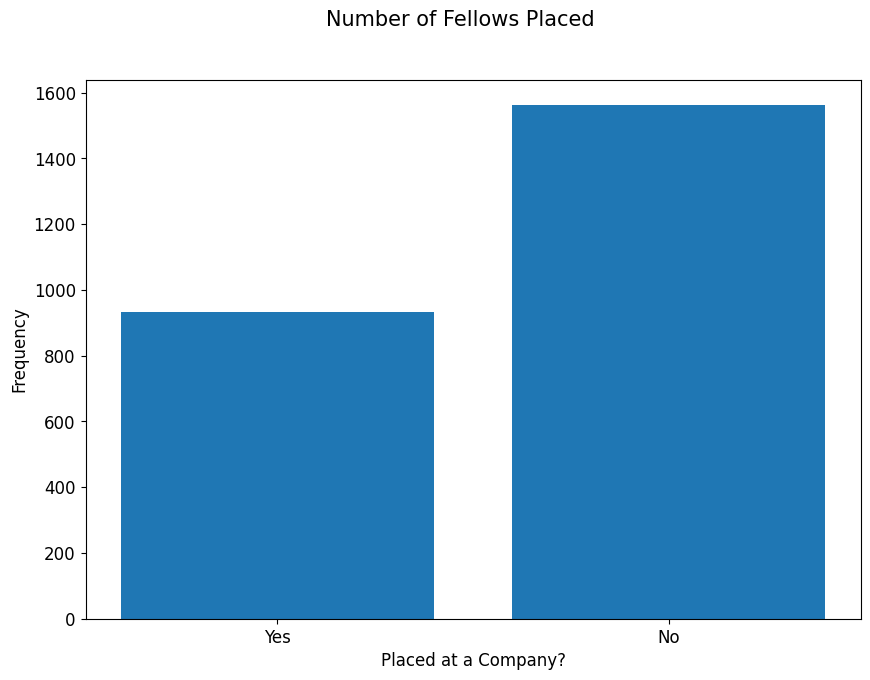

In [24]:
# Let's look at how many fellows placed at a company.
placed_df = pd.DataFrame({
    'Placed at a Company?': ['Yes', 'No'],
    'No. of Fellows': [df['placed'].sum(), df.shape[0] - df['placed'].sum()],
})
placed_df.set_index('Placed at a Company?', inplace = True)

fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Number of Fellows Placed', fontsize = 15)
plt.bar(x = placed_df.index, height = 'No. of Fellows', data = placed_df)
plt.xlabel('Placed at a Company?')
plt.ylabel('Frequency')
plt.show()

In [25]:
placed_fellows_df = df[df['placed'] == 1]
non_placed_fellows_df = df[df['placed'] == 0]

def create_placed_vs_var_df(feature):
    """
    Creates a dataframe used to compare placed and a specified feature.
    
    Parameter:
    feature - The categorical feature to compare fellow placement with
    
    Returns:
    None
    """
    placed_fellows = placed_fellows_df.groupby(feature).size()
    non_placed_fellows = non_placed_fellows_df.groupby(feature).size()
    
    feature_vs_placed_df = pd.concat([placed_fellows, non_placed_fellows], axis = 1)
    feature_vs_placed_df = feature_vs_placed_df.rename(columns = {
        0: 'Placed',
        1: 'Non-placed'
    })
    
    return feature_vs_placed_df

## Primary Track vs. Placed

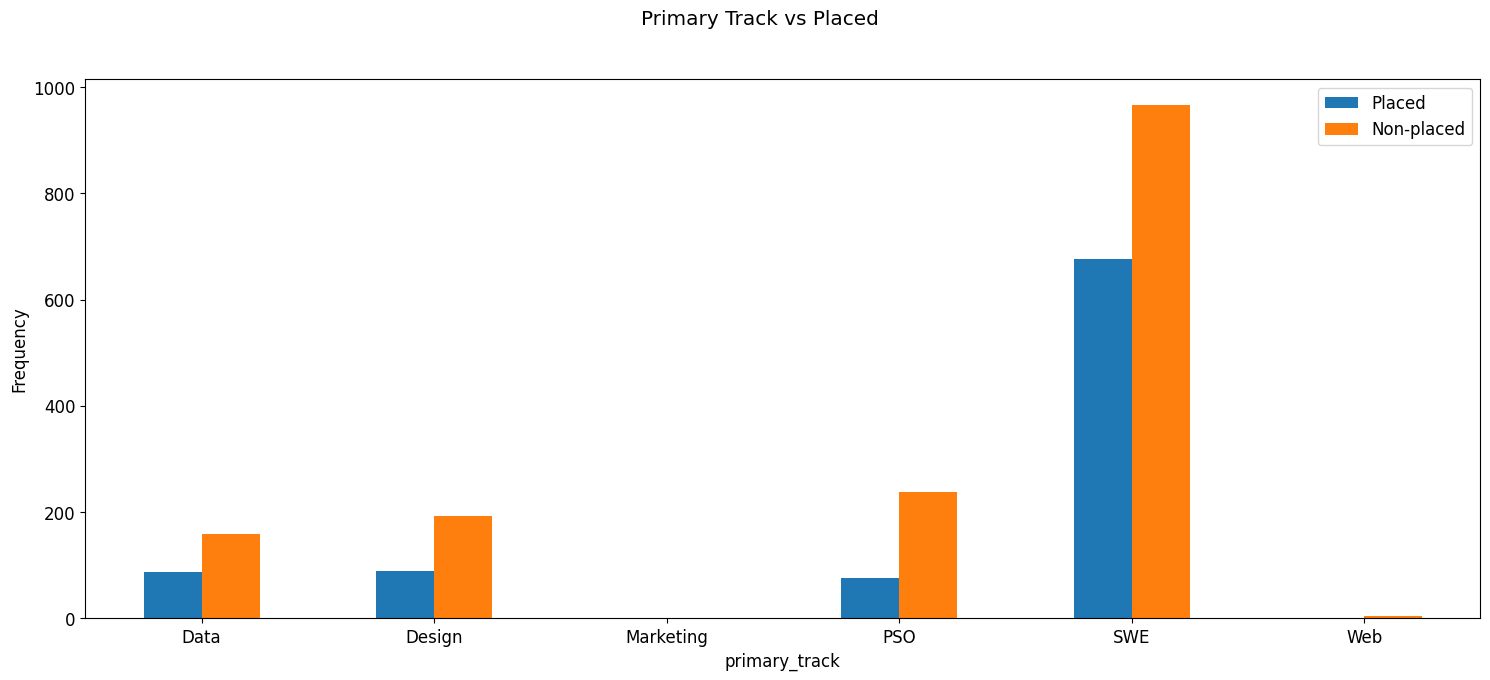

In [26]:
fig, ax = plt.subplots(figsize = (18, 7))
fig.suptitle('Primary Track vs Placed')
plt.ylabel('Frequency')
create_placed_vs_var_df('primary_track').plot.bar(ax = ax, rot = 0)
plt.show()

## Level of Education vs. Placed

In [27]:
placed_fellows_edu = placed_fellows_df.groupby('highest_level_of_education').size()
non_placed_fellows_edu = non_placed_fellows_df.groupby('highest_level_of_education').size()

edu_vs_placed_df = pd.concat([placed_fellows_edu, non_placed_fellows_edu], axis = 1)
edu_vs_placed_df = edu_vs_placed_df.rename(columns = {
    0: 'Placed',
    1: 'Non-placed'
})

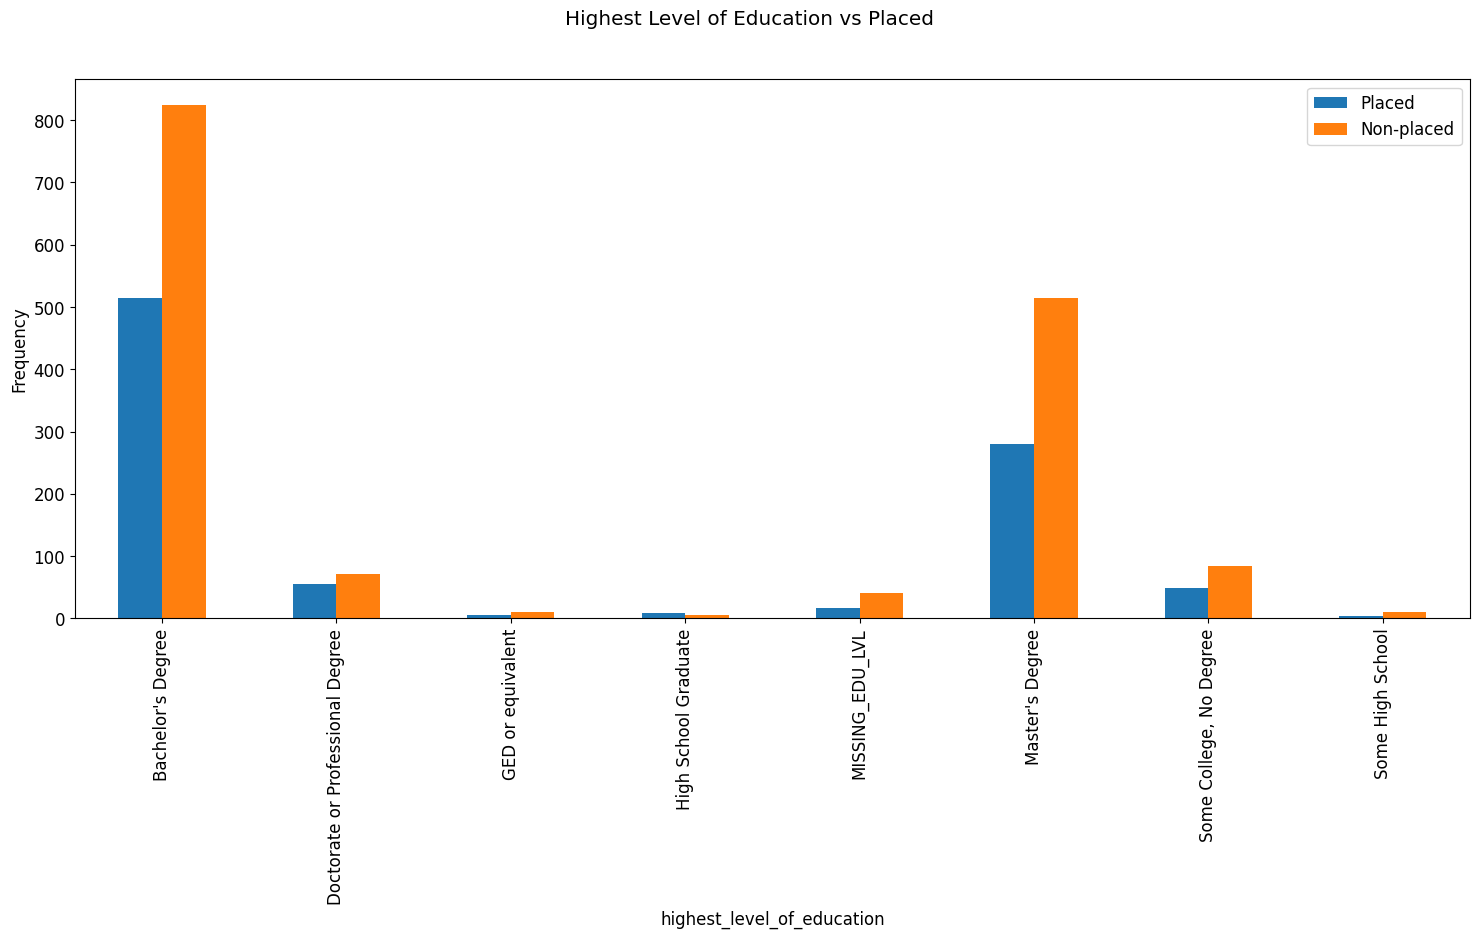

In [28]:
fig, ax = plt.subplots(figsize = (18, 7))
fig.suptitle('Highest Level of Education vs Placed')
plt.ylabel('Frequency')
create_placed_vs_var_df('highest_level_of_education').plot.bar(ax = ax, rot = 90)
plt.show()

## Professional Experience vs Placed

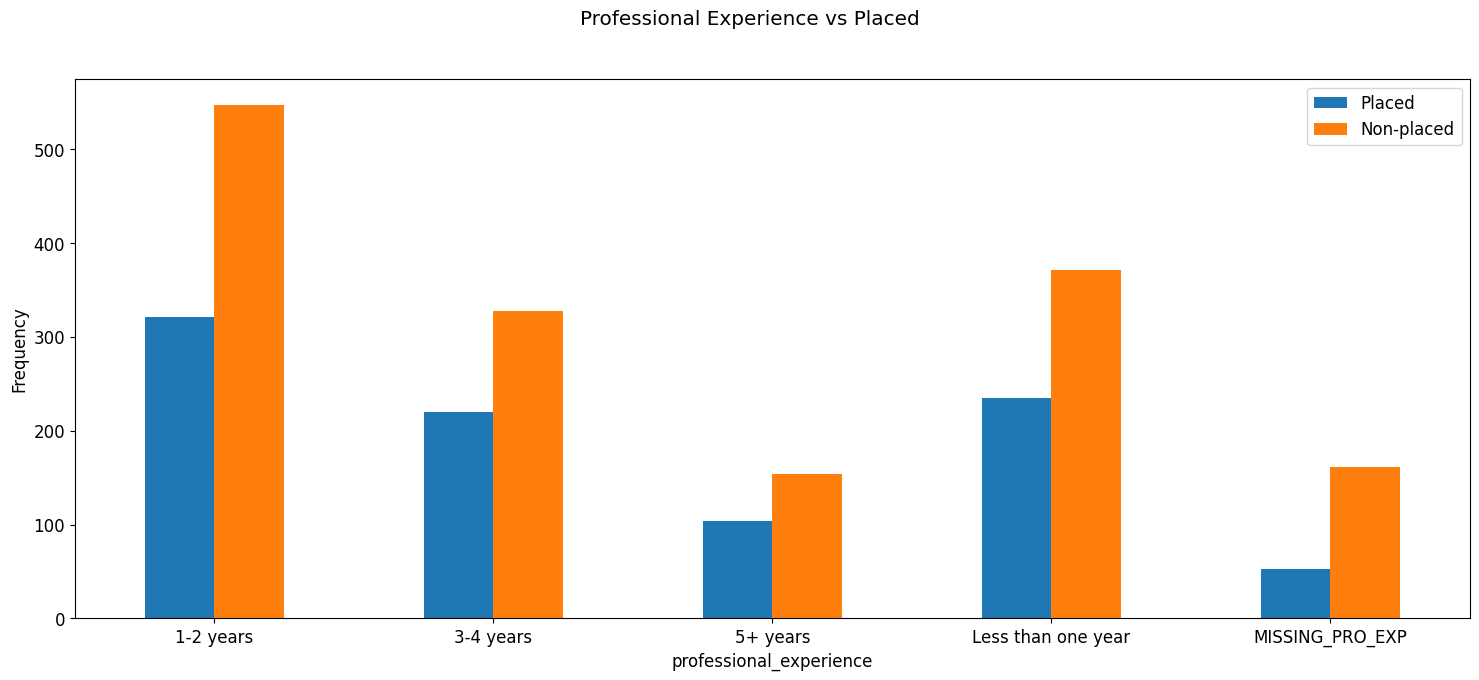

In [29]:
fig, ax = plt.subplots(figsize = (18, 7))
fig.suptitle('Professional Experience vs Placed')
plt.ylabel('Frequency')
create_placed_vs_var_df('professional_experience').plot.bar(ax = ax, rot = 0)
plt.show()

## Work Authorization Status vs Placed

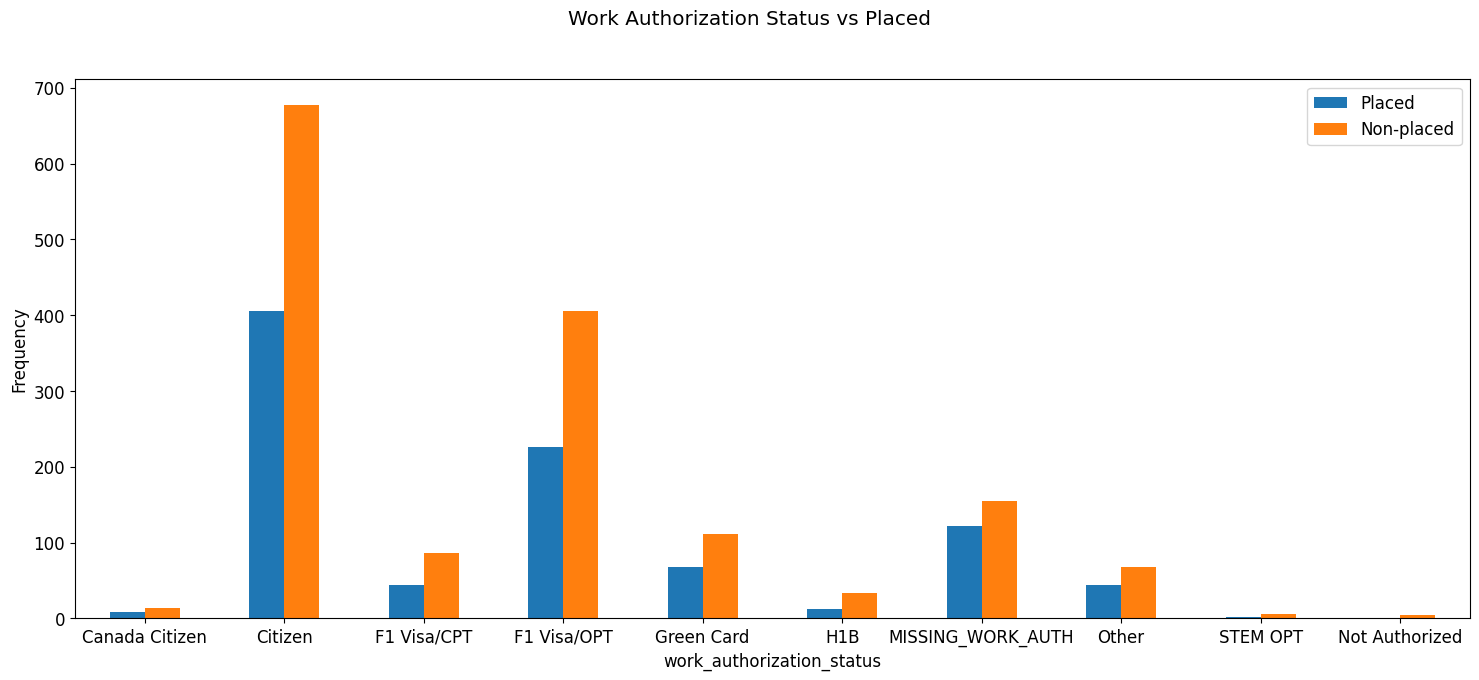

In [30]:
fig, ax = plt.subplots(figsize = (18, 7))
fig.suptitle('Work Authorization Status vs Placed')
plt.ylabel('Frequency')
plt.xlabel('Work Authorization Status')
create_placed_vs_var_df('work_authorization_status').plot.bar(ax = ax, rot = 0)
plt.show()

## Biggest Challenge vs Placed

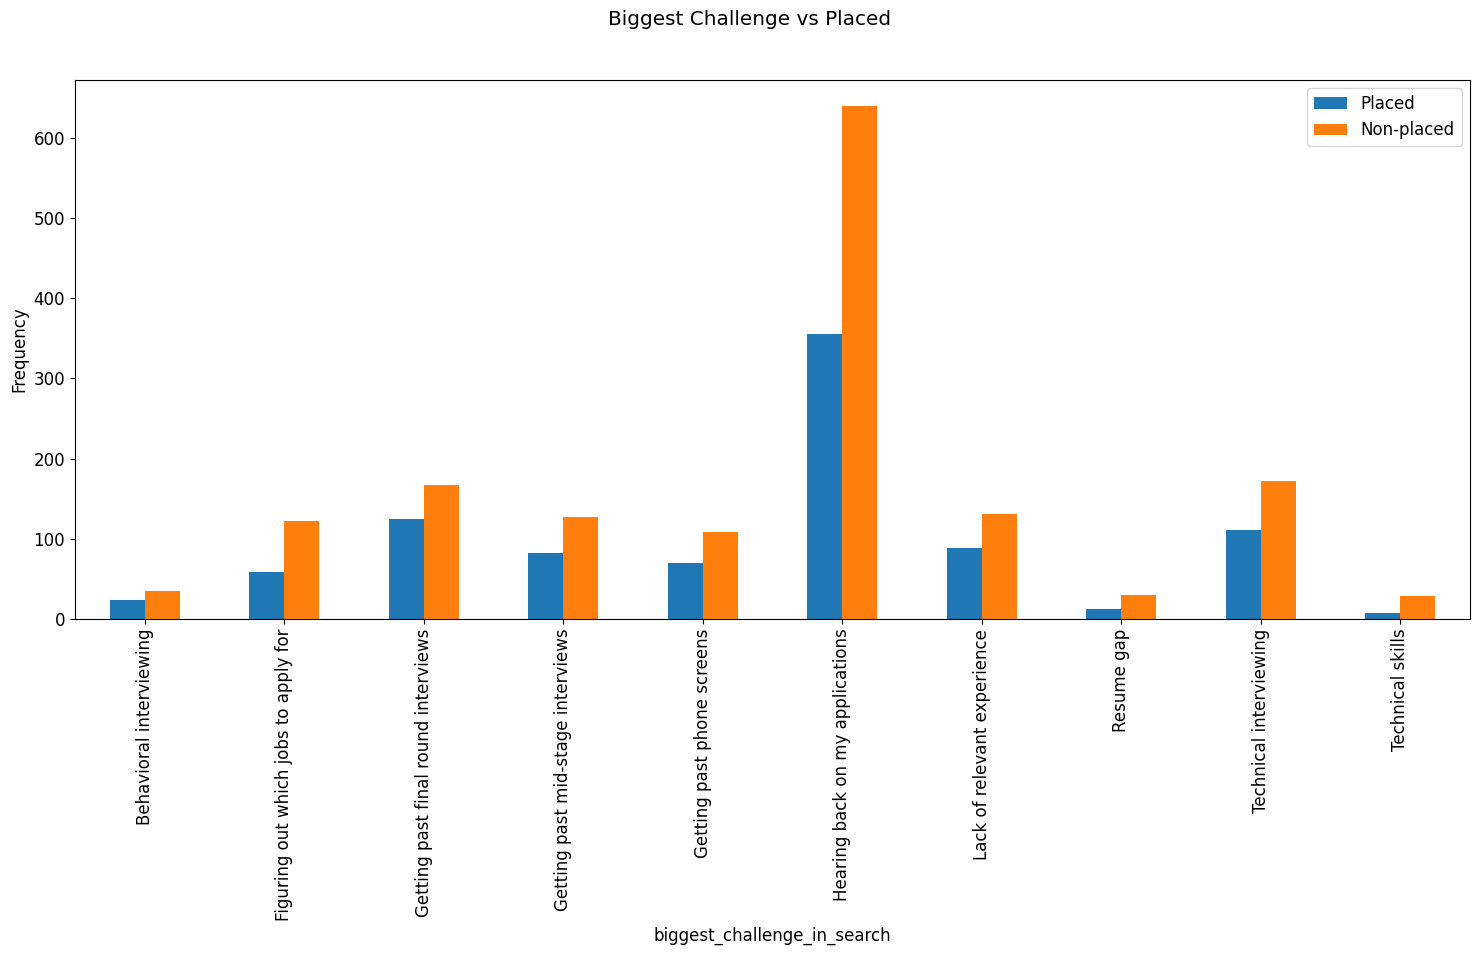

In [31]:
fig, ax = plt.subplots(figsize = (18, 7))
fig.suptitle('Biggest Challenge vs Placed')
plt.ylabel('Frequency')
create_placed_vs_var_df('biggest_challenge_in_search').plot.bar(ax = ax, rot = 90)
plt.show()

## Length of Job Search vs Placed

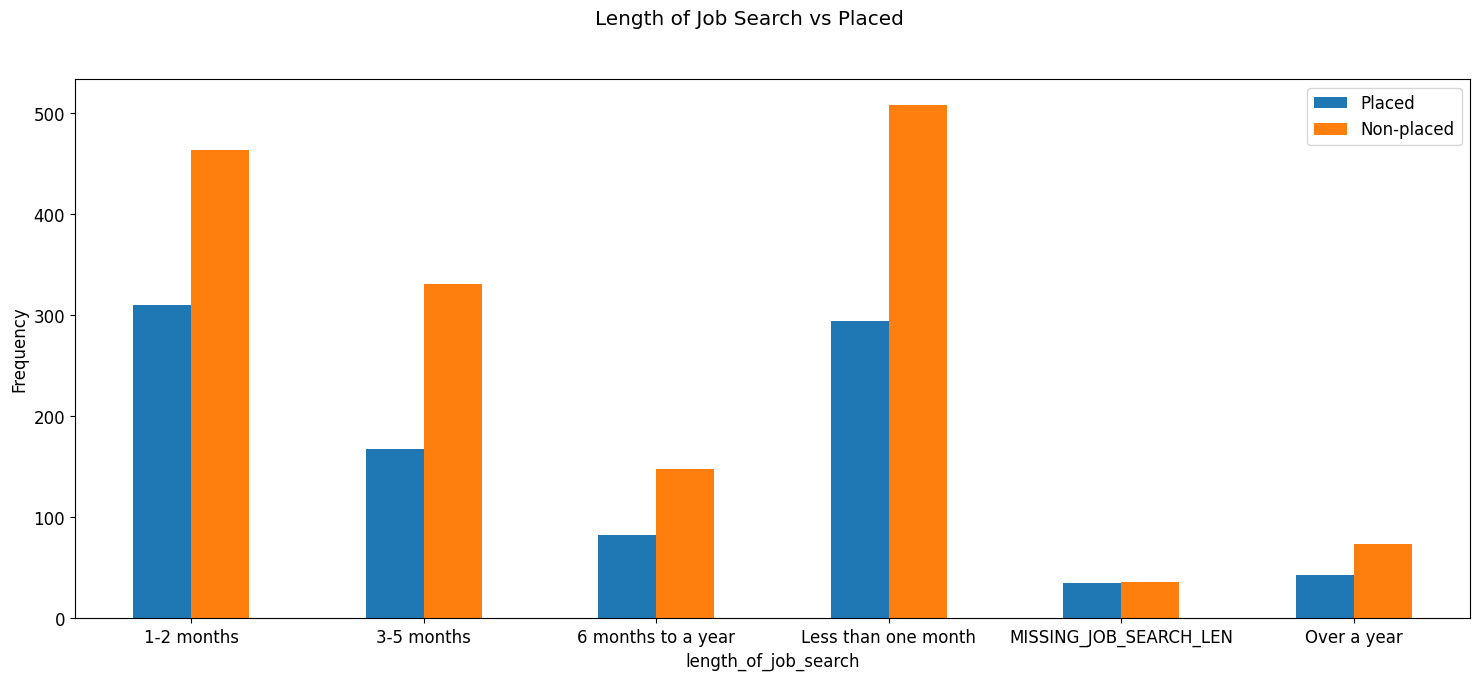

In [32]:
fig, ax = plt.subplots(figsize = (18, 7))
fig.suptitle('Length of Job Search vs Placed')
plt.ylabel('Frequency')
create_placed_vs_var_df('length_of_job_search').plot.bar(ax = ax, rot = 0)
plt.show()

## Ethnicity vs Placed

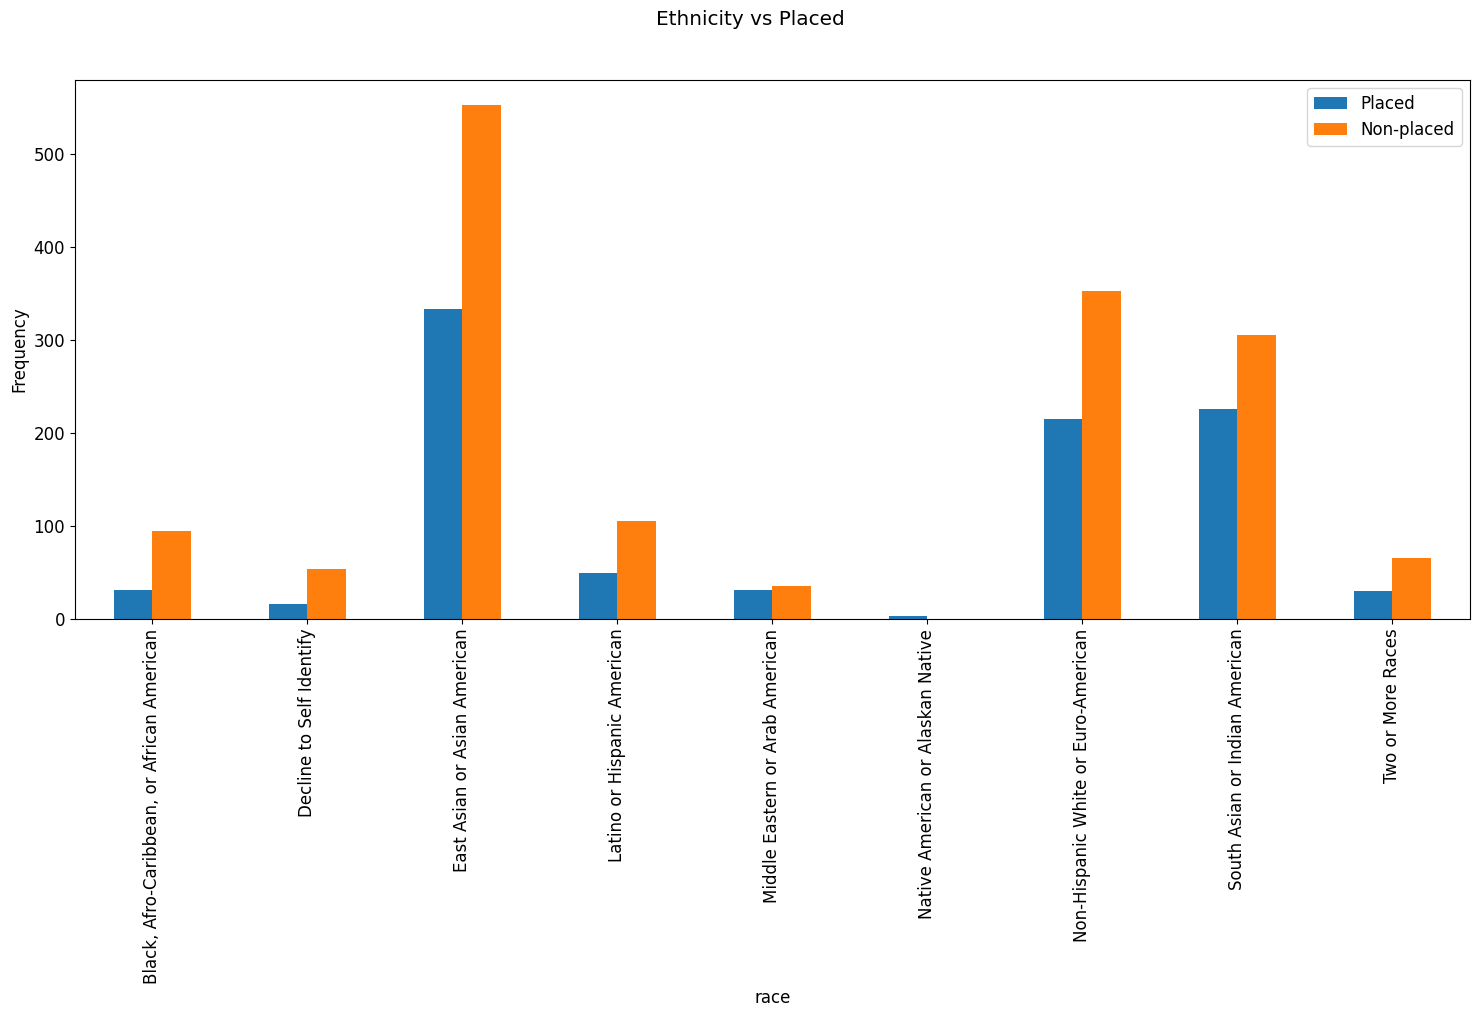

In [33]:
fig, ax = plt.subplots(figsize = (18, 7))
fig.suptitle('Ethnicity vs Placed')
plt.xlabel('Race')
plt.ylabel('Frequency')
create_placed_vs_var_df('race').plot.bar(ax = ax, rot = 90)
plt.show()

## Gender vs Placed

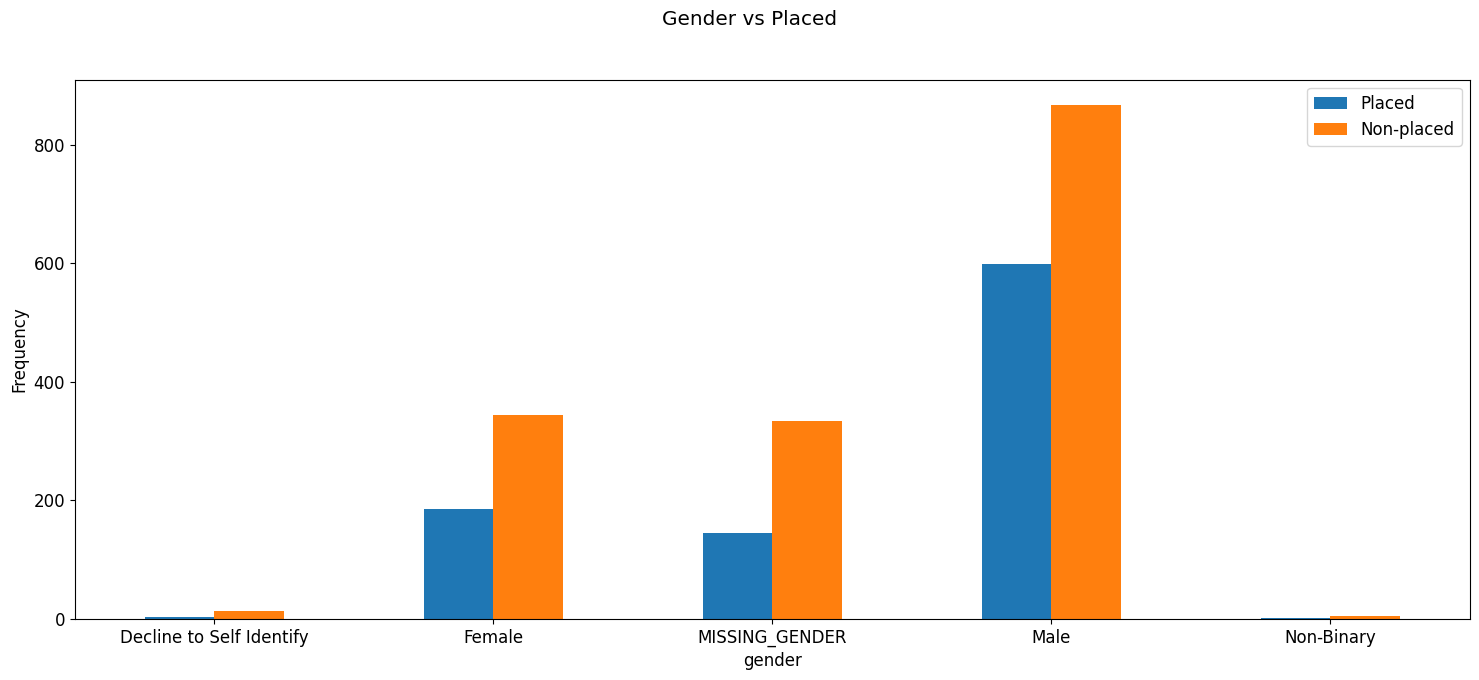

In [34]:
fig, ax = plt.subplots(figsize = (18, 7))
fig.suptitle('Gender vs Placed')
plt.ylabel('Frequency')
create_placed_vs_var_df('gender').plot.bar(ax = ax, rot = 0)
plt.show()

## Employment Status vs Placed

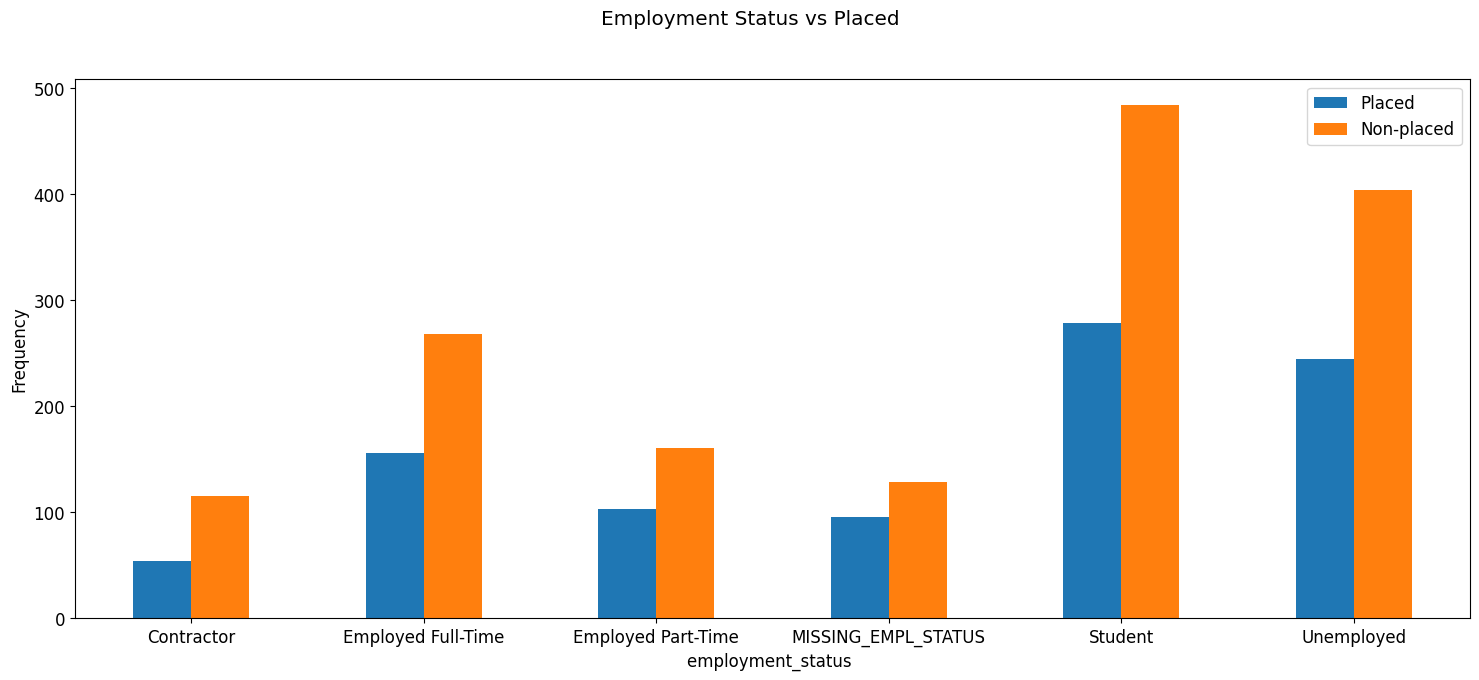

In [35]:
fig, ax = plt.subplots(figsize = (18, 7))
fig.suptitle('Employment Status vs Placed')
plt.ylabel('Frequency')
create_placed_vs_var_df('employment_status ').plot.bar(ax = ax, rot = 0)
plt.show()

## Number of Applications vs Placed

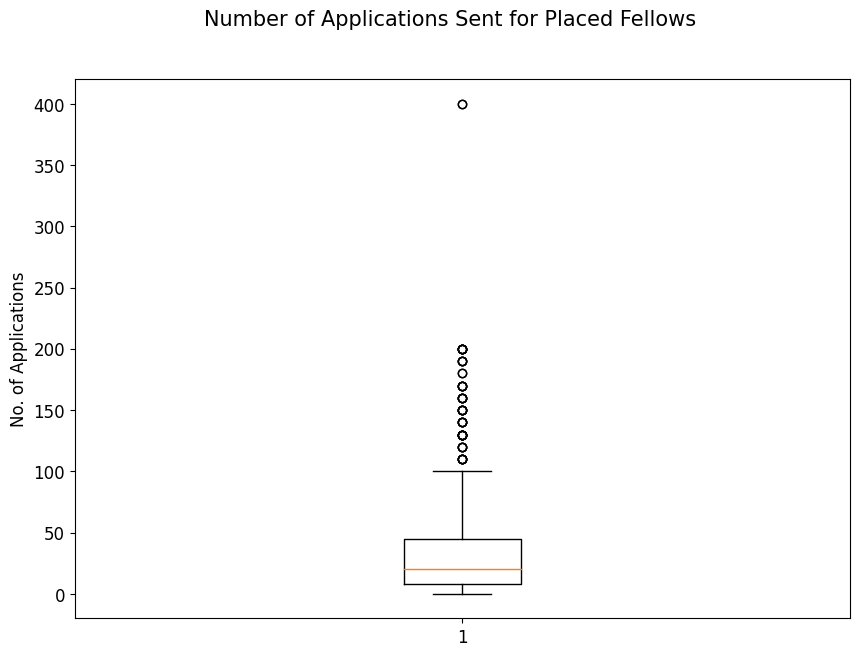

In [36]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Number of Applications Sent for Placed Fellows', fontsize = 15)
plt.boxplot(placed_fellows_df['number_of_applications'])
plt.ylabel('No. of Applications')
plt.show()

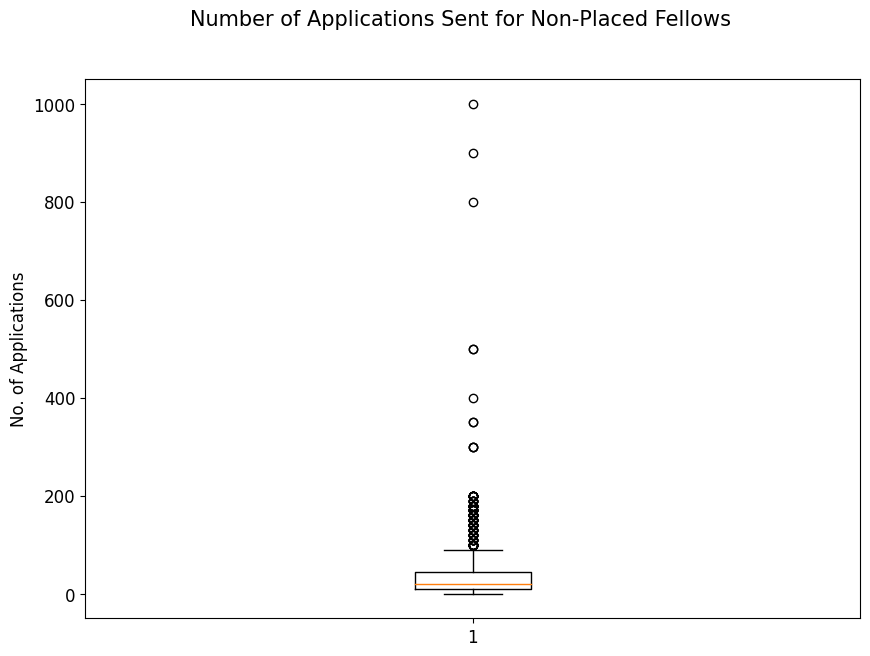

In [37]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Number of Applications Sent for Non-Placed Fellows', fontsize = 15)
plt.boxplot(non_placed_fellows_df['number_of_applications'])
plt.ylabel('No. of Applications')
plt.show()

## Number of Interviews vs Placed

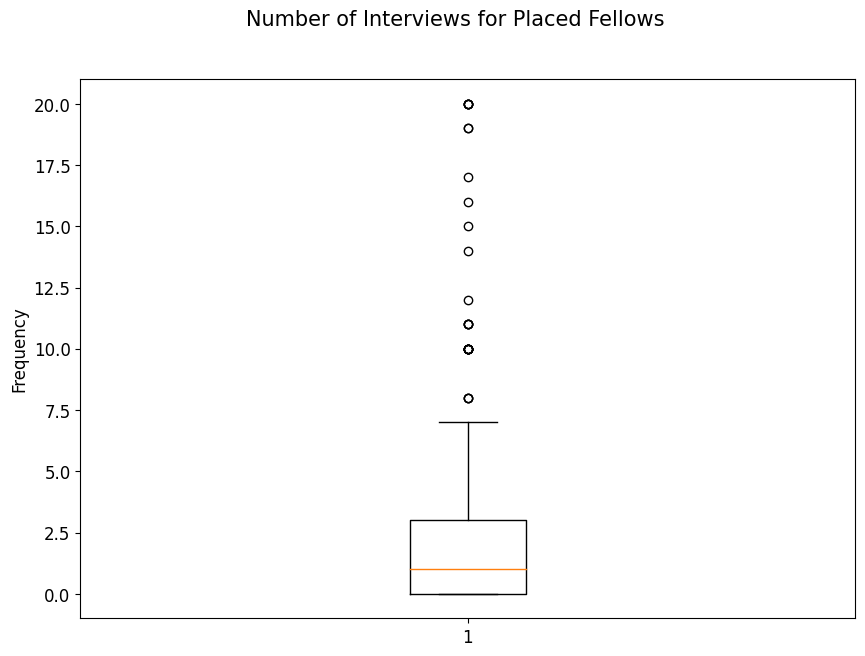

In [38]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Number of Interviews for Placed Fellows', fontsize = 15)
plt.boxplot(placed_fellows_df['number_of_interviews'])
plt.ylabel('Frequency')
plt.show()

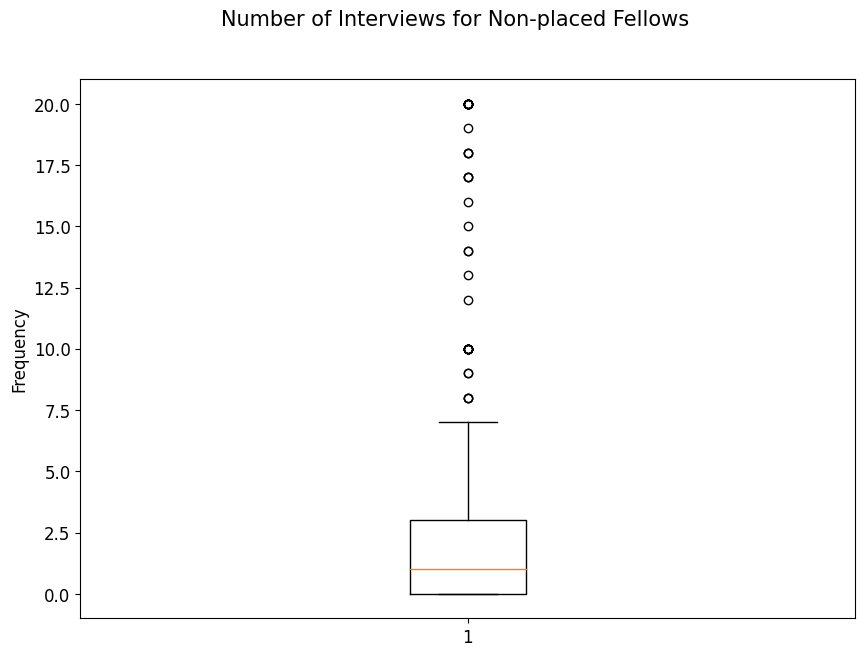

In [39]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Number of Interviews for Non-placed Fellows', fontsize = 15)
plt.boxplot(non_placed_fellows_df['number_of_interviews'])
plt.ylabel('Frequency')
plt.show()

## Insights

- Around 38% of fellows placed at companies.

- In general, the distribution of the variables I examined above against `placed` is similar for placed and non-placed fellows.

- Most placed fellows came from the SWE track, completed a Bachelor's Degree, have had less than a year to 2 years worth of professional experience, and are a US Citizen. Their biggest challenge was hearing back from applications, and prior to Pathrise they have been searching for a job from less than a month to 2 months. There seems to be lots of outliers in the number of applications they sent out and the number of interviews they recieved. The median was 20 and 2, respectively. 

- Most non-placed fellows follow a similar pattern. However, for the number of applications sent out, there are a lot more outliers for non-placed fellows than placed-fellows. There is a greater range for non-placed fellows for number of applications. 

<center><h1 style="color:red;border:1px solid blue;border-radius:20px;padding:10px 15px;line-height:27px">
   Looking at Placement Time
</h1></center>

To look at placement time, I'll perform an EDA on `program_duration_days`.

Earlier I mentioned that there were two ways of dealing with the missing data in `program_duration_days`. I could either ignore them and use it as a test set, or I can impute them.

I already did some digging into `program_duration_days` earlier. Here's those insights again:
- Almost 90% of the fellows missing this feature had a status of "Active". This means that Pathrise hasn't been able to get an accurate recording of how long they've been in the program. Maybe this is only recorded once enough time has passed or that fellow has left?
- Since a lot of active fellows are missing this feature, it might mess up my analysis further on. For example, I plan to use a one-way ANOVA test to determine the significance of different categorical variables against `program_duration_days`. If almost all of the data for Active fellows is missing, then I can't really get meaningful results from an ANOVA test.

According to this [paper on dealing with missing data from the University of Notre Dame](https://www3.nd.edu/~rwilliam/stats3/MD02.pdf), "the dependent variable in one part of the analysis may be an independent variable in a different part", and that I may go ahead and perform the imputation anyways. Also, almost 25% of the data is missing this feature, and I don't want to reduce the amount of data my model can train on by almost a quarter. 

With this in mind, I'll go ahead an impute `program_duration_days`. To determine how I'll impute it, I'll explore the data a bit more.

In [40]:
df['program_duration_days'].describe()

count    1889.000000
mean      135.966649
std       126.358170
min         0.000000
25%        14.000000
50%       111.000000
75%       224.000000
max       548.000000
Name: program_duration_days, dtype: float64

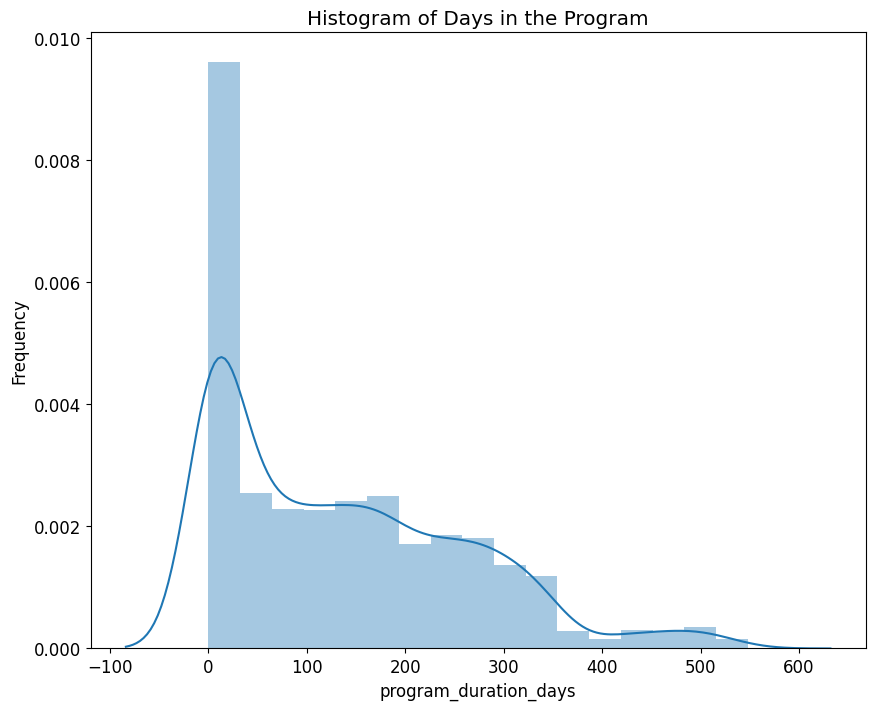

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Histogram of Days in the Program')
ax.set_ylabel('Frequency')
ax = sns.distplot(df['program_duration_days'])
plt.show()

In [42]:
print('Skewness:', df['program_duration_days'].skew())
print('Kurtosis:', df['program_duration_days'].kurtosis())

Skewness: 0.8216586627284554
Kurtosis: 0.008289061952525767


In [43]:
if is_normal(df['program_duration_days']):
    print('The data is normal.')
else:
    print('The data is NOT normal!')

The data is NOT normal!


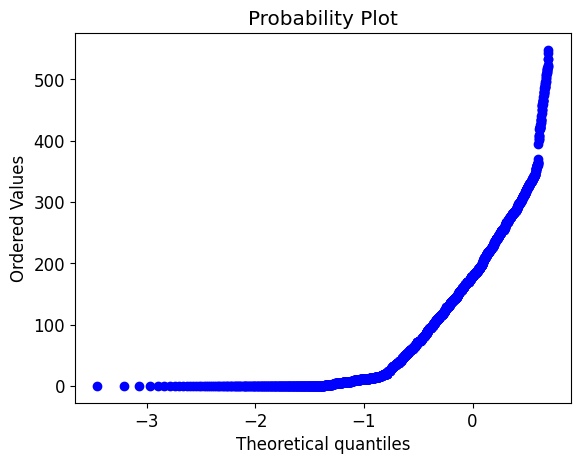

In [44]:
res = stats.probplot(df['program_duration_days'], plot = plt)

In [45]:
# Data isn't normal, so find median
df['program_duration_days'].median()

111.0

Here are some insights:
- The distribution of days in the Pathrise program, excluding missing values, is not normally distributed. It is a unimodal distribution skewed to the right.
- Again, 24.2% of fellows are missing this feature. 
- Fellows on average spent about 135 days in the program. However, the distribution is skewed, so a better measure of the center is the median, which is 111 days.
- Some fellows only spent 0 days in the program and got placed. This is interesting, and requires further investigation.
- The max amount of time a fellow has spent in the program was 548 days, or almost a year and a half.
- A positive skewness means that the distribution is positively skewed. A greater kurtosis means that there is a heavier tail. That's not really the case here.
- I also performed a normality test, and according to an $\alpha$ level of 0.05, the distribution is not normal. That can also be seen by the probability plot. This means I'm going to have to transform this variable.


## 0 days in the program?

Some fellows report having spent 0 days in the program. Let's look more into this.

In [46]:
# How many fellows spent 0 days in the program?
print('%.2f%% of fellows spent 0 days in the program.' % (100 * df[df['program_duration_days'] == 0].shape[0] / df[df['program_duration_days'].notnull()].shape[0]))

11.38% of fellows spent 0 days in the program.


In [47]:
# How many of these fellows have placed in a company?
print("%.2f%% of these fellows placed in a company." % (100 * df[(df['program_duration_days'] == 0) & (df['placed'] == 1)].shape[0] / df[df['program_duration_days'].notnull()].shape[0] ))

# Are active?
print("%.2f%% of these fellows are Active." % (100 * df[(df['program_duration_days'] == 0) & (df['pathrise_status'] == "Active")].shape[0] / df[df['program_duration_days'].notnull()].shape[0]))

# What's the most common status for these fellows?
print("The most common status for these fellows is %s." % df[df['program_duration_days'] == 0]['pathrise_status'].describe().top)
print("%.2f%% of these fellows are Closed Lost." % (100 * df[(df['program_duration_days'] == 0) & (df['pathrise_status'] == "Closed Lost")].shape[0] / df[df['program_duration_days'].notnull()].shape[0]))

0.05% of these fellows placed in a company.
0.00% of these fellows are Active.
The most common status for these fellows is Closed Lost.
9.53% of these fellows are Closed Lost.


The above print statements are based on the entirety of fellows not missing `program_duration_days`. A majority of these fellows have the status: Closed Lost.

I'm not too certain on what these means, but the fact that a majority of them are missing this and share a common status might be important. So, I won't change anything regarding fellows having a `program_duration_days` of 0.

## Imputing via modelling

I'll impute the missing data using a simple linear regression model, where the independent variables are all the other features in the dataset.

I'll include `placed` because it makes sense that this would impact how long the fellow has been in the program. [This StackOverflow post](https://stackoverflow.com/questions/57552951/imputing-missing-values-of-one-of-the-independent-variable-using-dependent-varia) goes more into how including the dependent variable in my imputation model won't lead to bias in estimating the important relationships. Also, `placed` can be considered a completely different problem i.e., in the context of solving my regression problem, `placed` is just another independent variable.

In [48]:
categ_vars = ['gender', 'race', 'pathrise_status', 'employment_status ', 
              'highest_level_of_education', 'length_of_job_search', 
              'professional_experience', 'work_authorization_status', 
              'primary_track', 'cohort_tag', 'placed']
quant_vars = ['number_of_interviews', 'number_of_applications']

In [49]:
# One-hot encode categ_vars
impute_df = pd.get_dummies(df[categ_vars])

# We don't need two placed columns
impute_df.drop(columns = ['pathrise_status_Placed'], inplace = True)

In [50]:
# Add in quantitative variables
impute_df[quant_vars] = df[quant_vars]

In [51]:
# Add in program_duration_days
impute_df['program_duration_days'] = df['program_duration_days']

In [52]:
# Linear Regression
## Train model on data not missing program_duration_days
## Use the model to predict the missing program_duration_days
# در اینجا میسینگ ولیوها رو بر اساس داده های موجود پیش بینی میکند

training_set = impute_df[impute_df['program_duration_days'].notnull()]
testing_set = impute_df[impute_df['program_duration_days'].isna()]

X_train = training_set.iloc[:, 0:-1]
y_train = training_set['program_duration_days']

# Train the model
lin_reg = LinearRegression().fit(X_train.values, y_train.values)

# Check out first 10 predictions
X_test = testing_set.iloc[:, 0:-1]
lin_reg.predict(X_test)[0:10]

array([5.14901731e+10, 5.14901731e+10, 5.14901731e+10, 5.14901732e+10,
       5.14901732e+10, 5.14901732e+10, 5.14901731e+10, 5.14901731e+10,
       5.14901732e+10, 5.14901731e+10])

Something's wrong, as these values are extremely large. Fellows are usually in the program for 135 days, and my linear model is making predictions for 5.55e+10, which is extremely high.

Instead, let's use LASSO Regression, as there are lots of features and not that many observations. LASSO Regression allows us to remove some features, as some coefficient estimates are shrunk down to 0.

In [53]:
clf = linear_model.Lasso(alpha = 0.1)
clf.fit(X_train.values, y_train.values)

# Check out first 10 predictions
clf.predict(X_test)[0:10]

array([ 66.84593002, 110.39915173, 119.19055335, 131.60563513,
       124.68582304, 134.87031306, 108.63102511, 114.57685358,
       134.66325538, 118.9622454 ])

This looks a lot better! Let's impute the missing data with these predictions, now.

In [54]:
df.loc[testing_set.index.values, "program_duration_days"] = clf.predict(X_test)

In [55]:
# Sanity check
df[df['program_duration_days'].isna()]

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race


## Log-Transformation

Since `program_duration_days` is not normal, let's perform a log transformation.

To transform to logarithms, you need positive values, 

ما به لاگ ترنسفورم نیاز داریم چون میخواهیم دیتامون نرمال بشه. چرا نرمال؟ چون دقت مدل ماشین لرنینگ ما افزایش پیدا میکند  ارگ داده هامون در یک رنج باشند. 

In [56]:
# Sanity check if imputations changed the normality
is_normal(df['program_duration_days'])

False

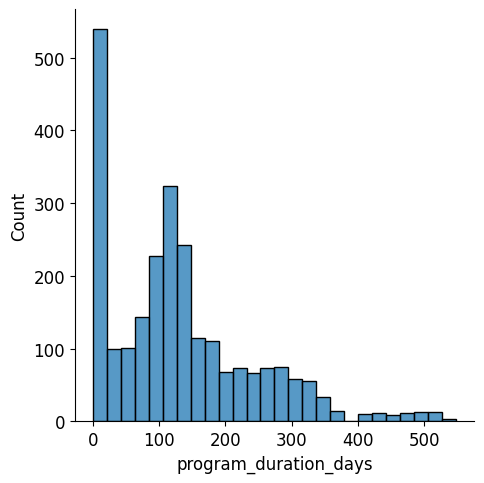

In [57]:
sns.displot(df['program_duration_days'])

In [58]:
# Log transform
df['log_program_duration_days'] = df['program_duration_days'].apply(lambda x: np.log(abs(x)) if x > 0 else 0)

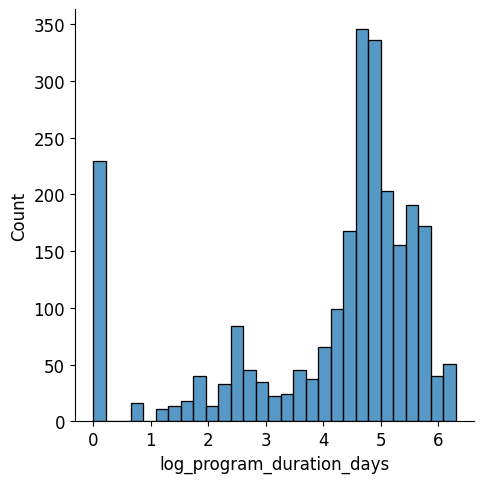

In [59]:
sns.displot(df['log_program_duration_days'])

In [60]:
df['log_program_duration_days'].head()

0    4.202390
1    4.704102
2    0.000000
3    0.000000
4    4.488636
Name: log_program_duration_days, dtype: float64

<center><h1 style="color:red;border:1px solid blue;border-radius:20px;padding:10px 15px;line-height:27px">
Defining the problem clearly
</h1></center>


I have one classification problem and one regression problem.

The classification problem is: **What factors lead to a fellow getting placed?**
- Dependent Variable: `placed`

The regression problem is: **What factors impact how long a fellow takes to get placed?**
- Dependent Variable: `program_duration_days`

<center><h1 style="color:red;border:1px solid blue;border-radius:20px;padding:10px 15px;line-height:27px">
The Independent Variables
</h1></center>


In this section I will analyze and encode the independent variables.

## Categorical Variables

I'll examine:
- `gender` 
- `race` 
- `pathrise_status`
- `employment_status`
- `highest_level_of_education`
- `length_of_job_search`
- `professional_experience`
- `work_authorization_status`
- `primary_track` 
- `cohort_tag` 
- `has_prior_interviews` -> I'll go more into this below

In [61]:
categ_vars = ['gender', 'race', 'pathrise_status', 'employment_status ', 
              'highest_level_of_education', 'length_of_job_search', 
              'professional_experience', 'work_authorization_status', 
              'primary_track', 'cohort_tag', 'has_prior_interviews']

In [62]:
one_hot_categ_vars_placed = [] # Holds the names of the one-hot 
                               # encoded variable names for the classification problem
one_hot_categ_vars_place_time = [] # Holds the names of the one-hot 
                                   # encoded variable names for the regression problem

def one_hot_enc(feature, for_placed = True):
    """
    Uses pandas' get_dummies() function to one-hot encode the given feature, 
    and attaches them to the dataframe. 
    
    Parameters:
    feature - The feature to encode.
    for_placed - Whether or not to append the encoded variables into the list of encoded
                 variables for placed i.e., the classification problem.
    
    Return: None
    """
    # Append the levels of the feature to appropriate list for classification or regression problem
    for uniq_feature in df[feature].unique():
        if for_placed: 
            one_hot_categ_vars_placed.append(uniq_feature)
        else:
            one_hot_categ_vars_place_time.append(uniq_feature)
    
    dummies_df = pd.get_dummies(df[feature])
    
    # Append the dummies dataframe to the original df
    df[dummies_df.columns] = dummies_df
    

### `gender`

There are a lot more males in the Pathrise fellowship than any other reported gender.

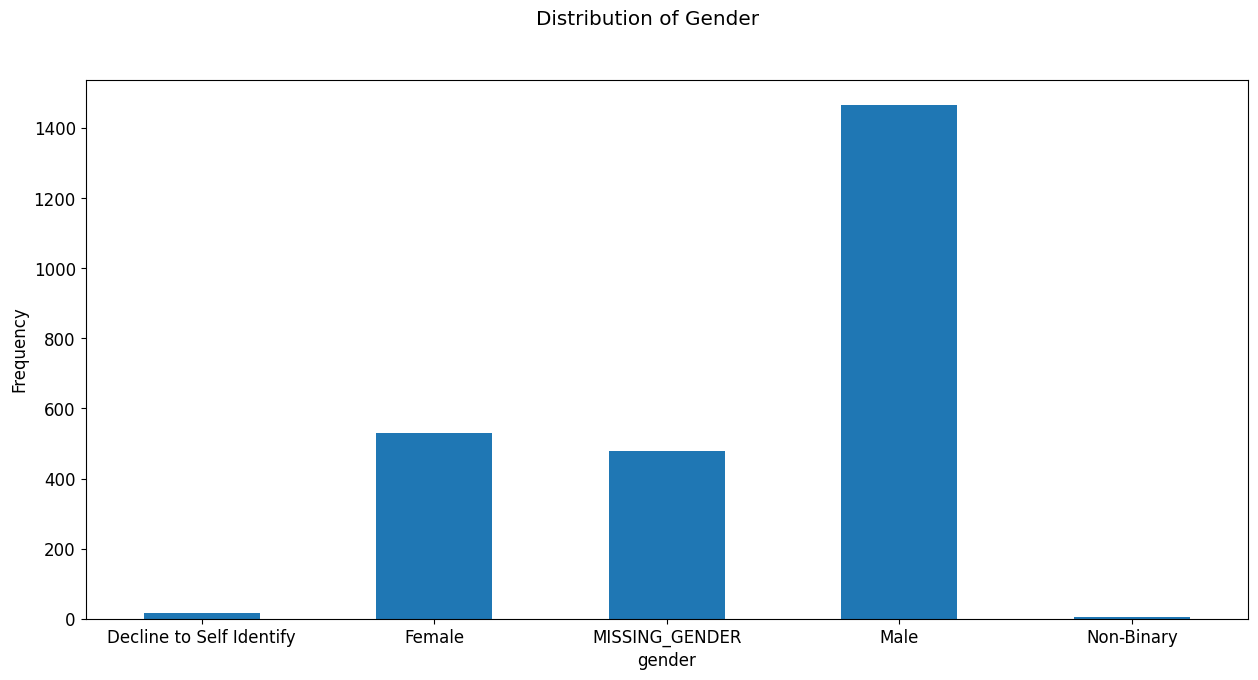

In [63]:
fig, ax = plt.subplots(figsize = (15, 7))
plt.suptitle('Distribution of Gender')
df.groupby('gender').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

### `race`

A majority of fellows are East Asian or Asian American. Following closely are Non-Hispanic White or Euro-American and South Asian or Indian American

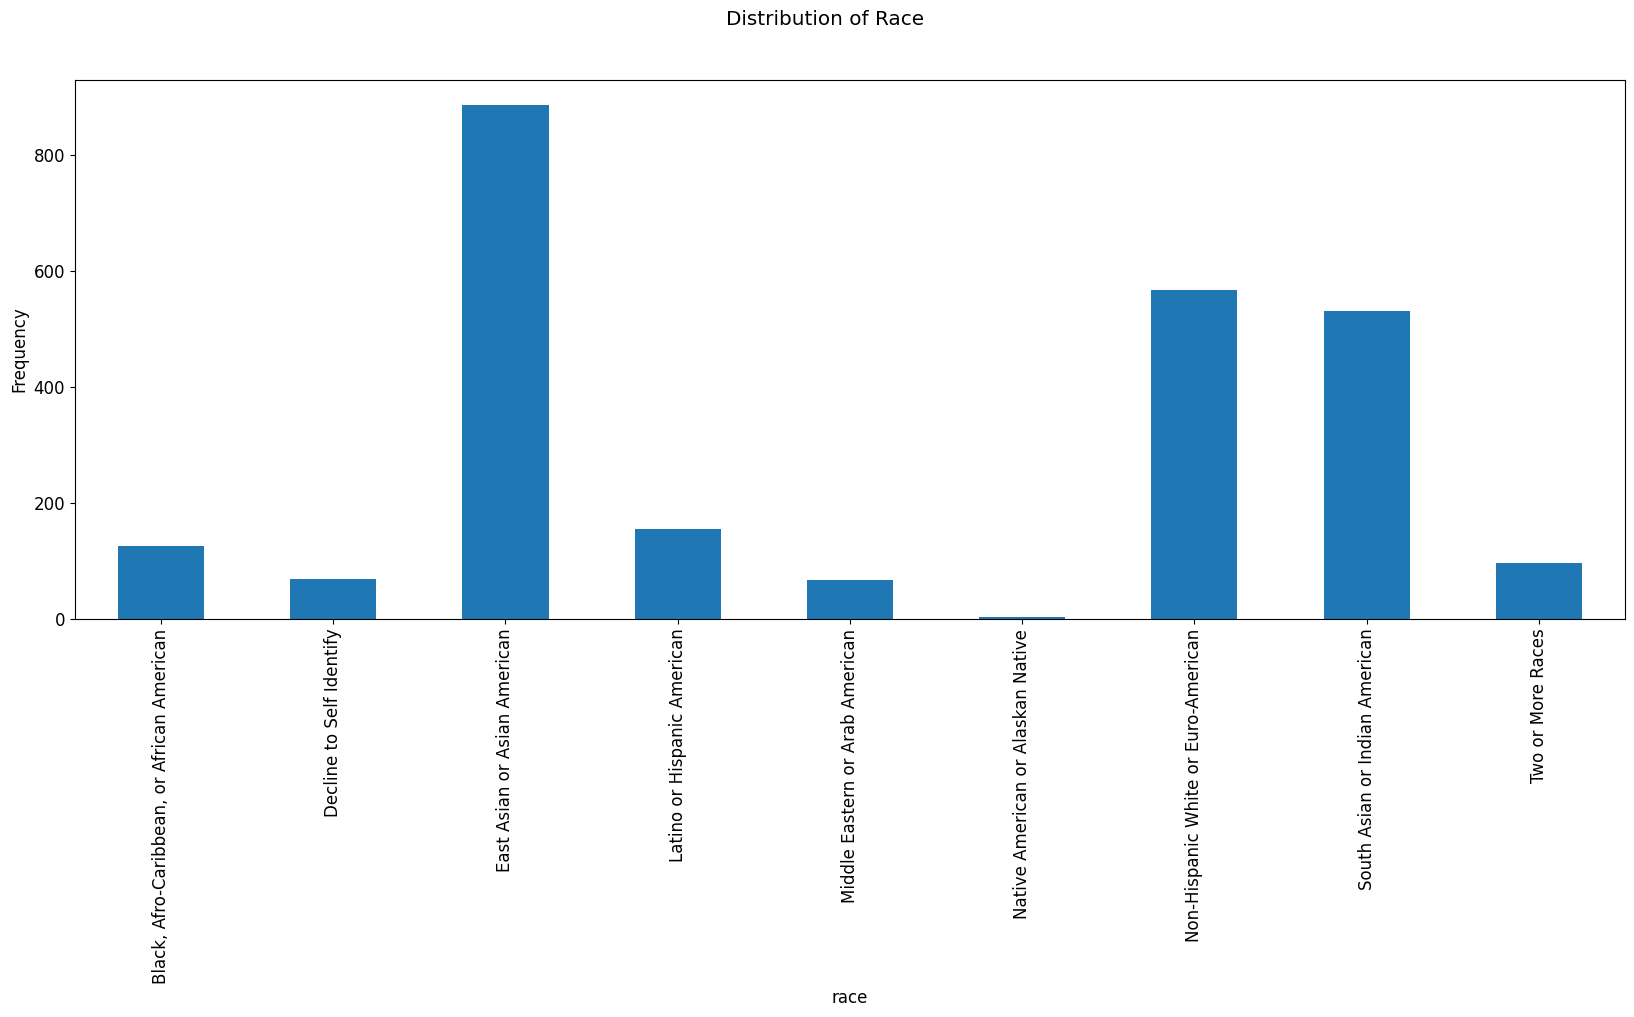

In [64]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Race')
df.groupby('race').size().to_frame().plot.bar(legend = False, ax = ax, rot = 90)
plt.ylabel('Frequency')
plt.show()

### `pathrise_status`

Looking at the graph, there are lots of fellows who were placed. However, this information is already captured by the `placed` variable. 

Other than that, a majority of fellows are still active in the program or have withdrawn either from the trial or midway through the program.

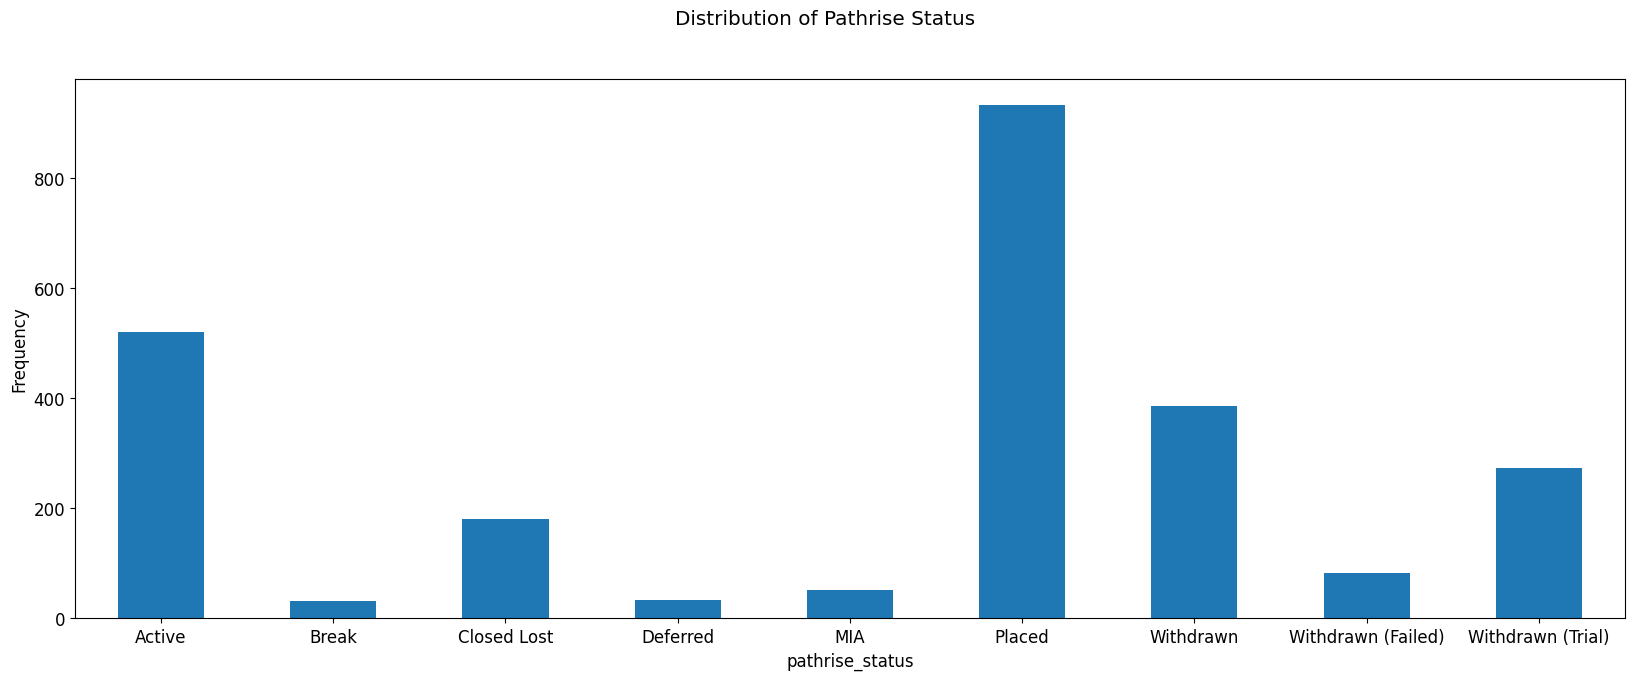

In [65]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Pathrise Status')
df.groupby('pathrise_status').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

### `employment_status`
Most fellows are students or unemployed. This makes sense, as I'd imagine that for people looking for their first job (students) or for people who are having trouble landing a job now (unemployed) would enroll in the Pathrise fellowship.

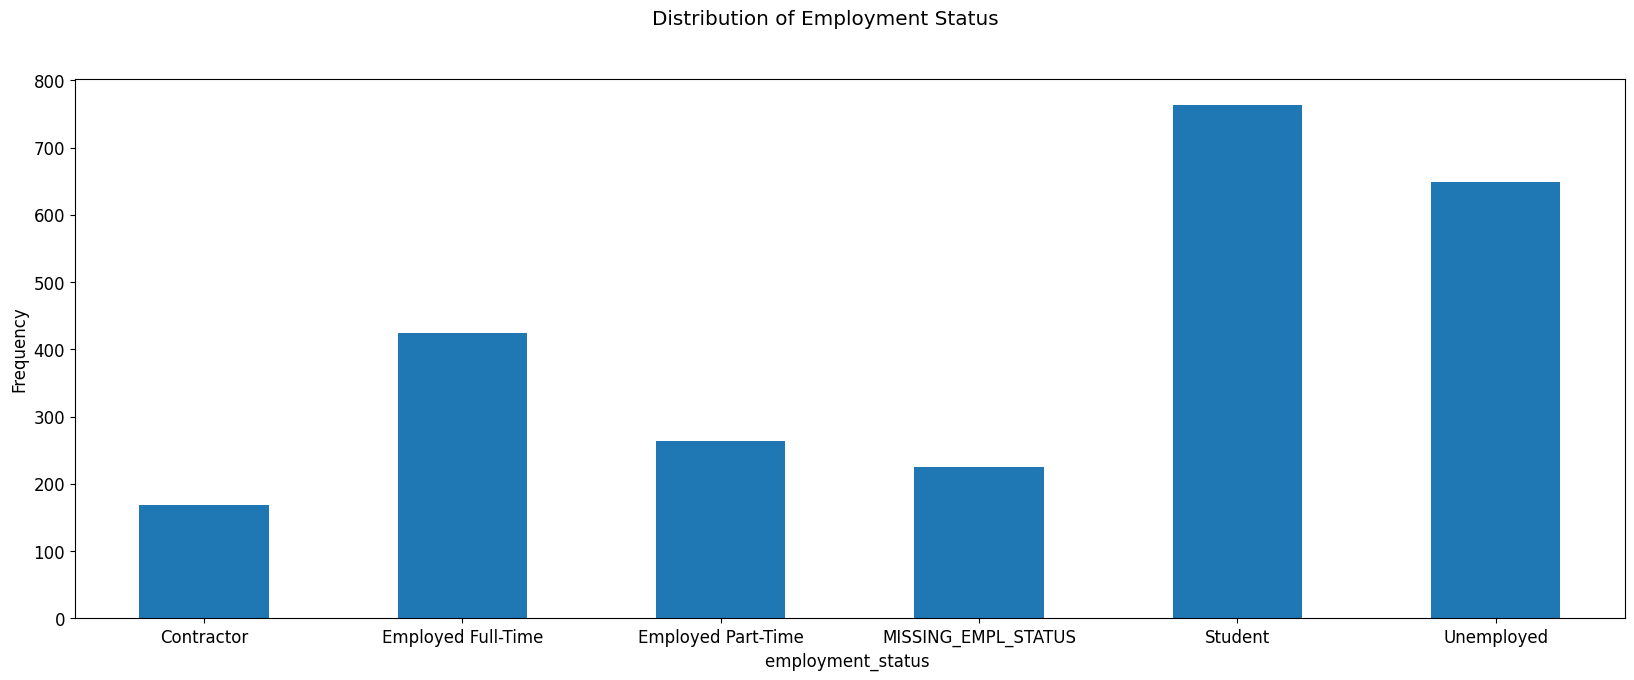

In [66]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Employment Status')
df.groupby('employment_status ').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

### `highest_level_of_education`

Most fellows have a Bachelor's Degree, again showing that most fellows are just fresh out of college and are most likely looking for their first job. 

The second most frequent level of education obtained is a Master's Degree, which could correspond to the unemployed fellows.

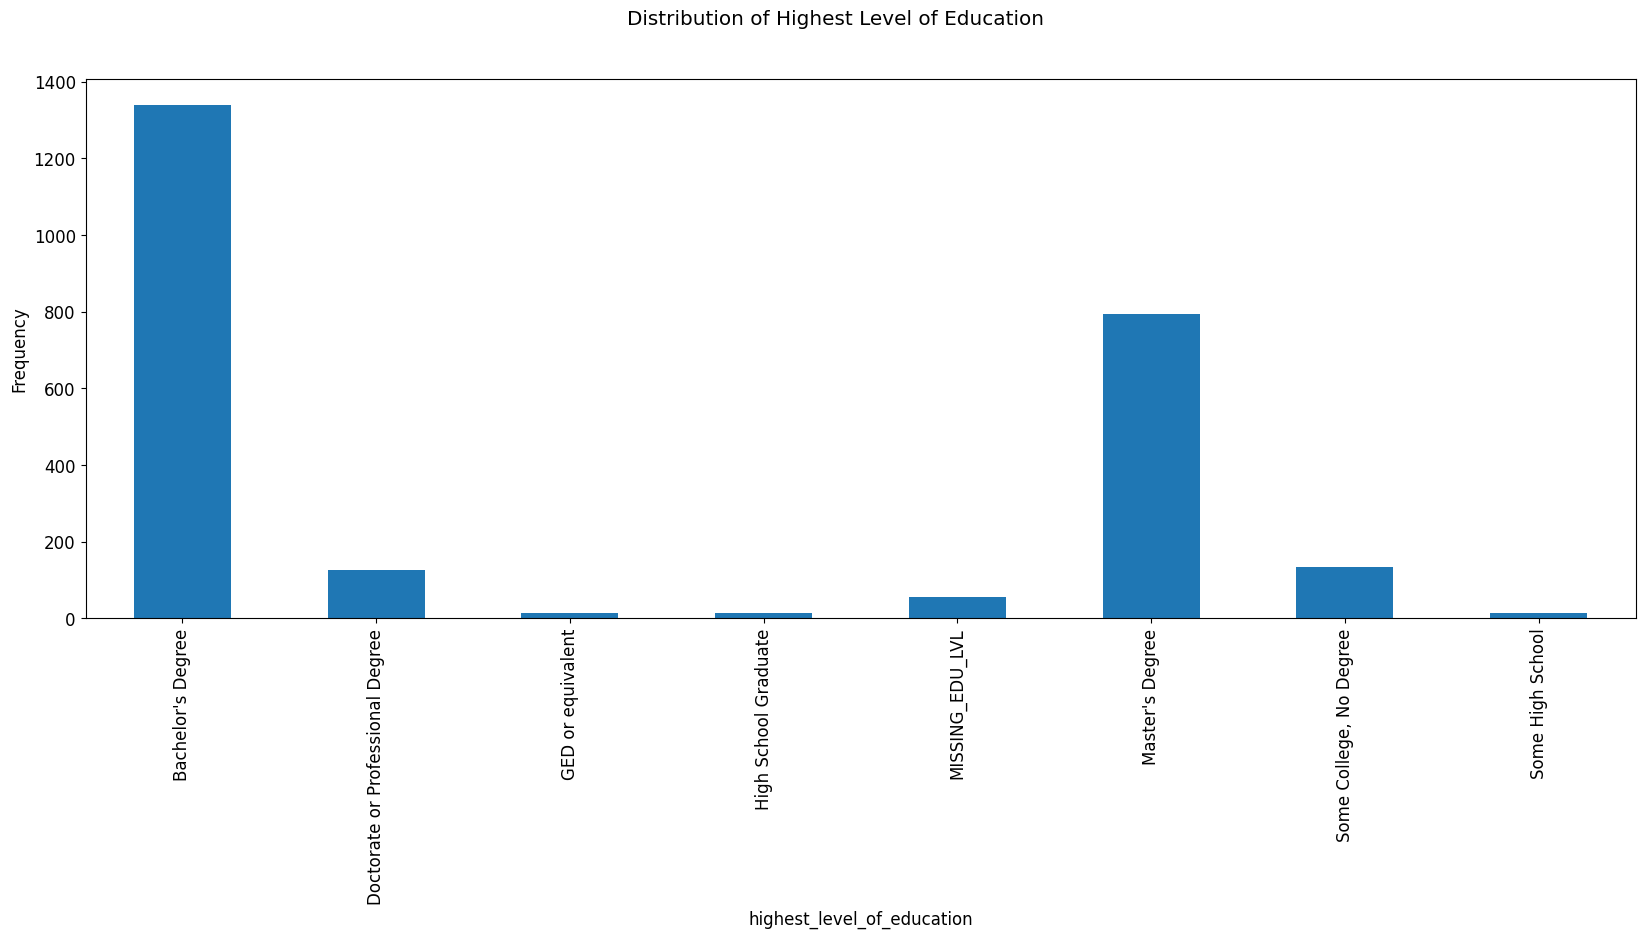

In [67]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Highest Level of Education')
df.groupby('highest_level_of_education').size().to_frame().plot.bar(legend = False, ax = ax, rot = 90)
plt.ylabel('Frequency')
plt.show()

**Question**: Of the fellows whose highest level of education is a Bachelor's Degree, what's the distribution like in terms of employment status?

Below is a Series showing the distribution of fellows with a Bachelor's Degree against their employment status. Most of the fellows with a Bachelor's were either a Student or Unemployed, which goes against what I said earlier.

In [68]:
df.groupby(['highest_level_of_education', 'employment_status ']).size()["Bachelor's Degree"]

employment_status 
Contractor              84
Employed Full-Time     241
Employed Part-Time     132
MISSING_EMPL_STATUS    128
Student                386
Unemployed             368
dtype: int64

**Question**: Of the fellows whose highest level of education is a Master's Degree, what's the distribution like in terms of employment status?

The Series below shows that most fellows with a Master's are Students. The second most common employment status would be unemployed. This goes against what I said earlier.

In [69]:
df.groupby(['highest_level_of_education', 'employment_status ']).size()["Master's Degree"]

employment_status 
Contractor              59
Employed Full-Time     114
Employed Part-Time      99
MISSING_EMPL_STATUS     58
Student                272
Unemployed             192
dtype: int64

### `length_of_job_search`

Most fellows spend less than a month to 1-2 months searching for a job. My assumption is that this is prior to accepting into the Pathrise fellowship.

Again, this goes along with my intuition that most fellows who enter the program are those looking for a new, or first, job.

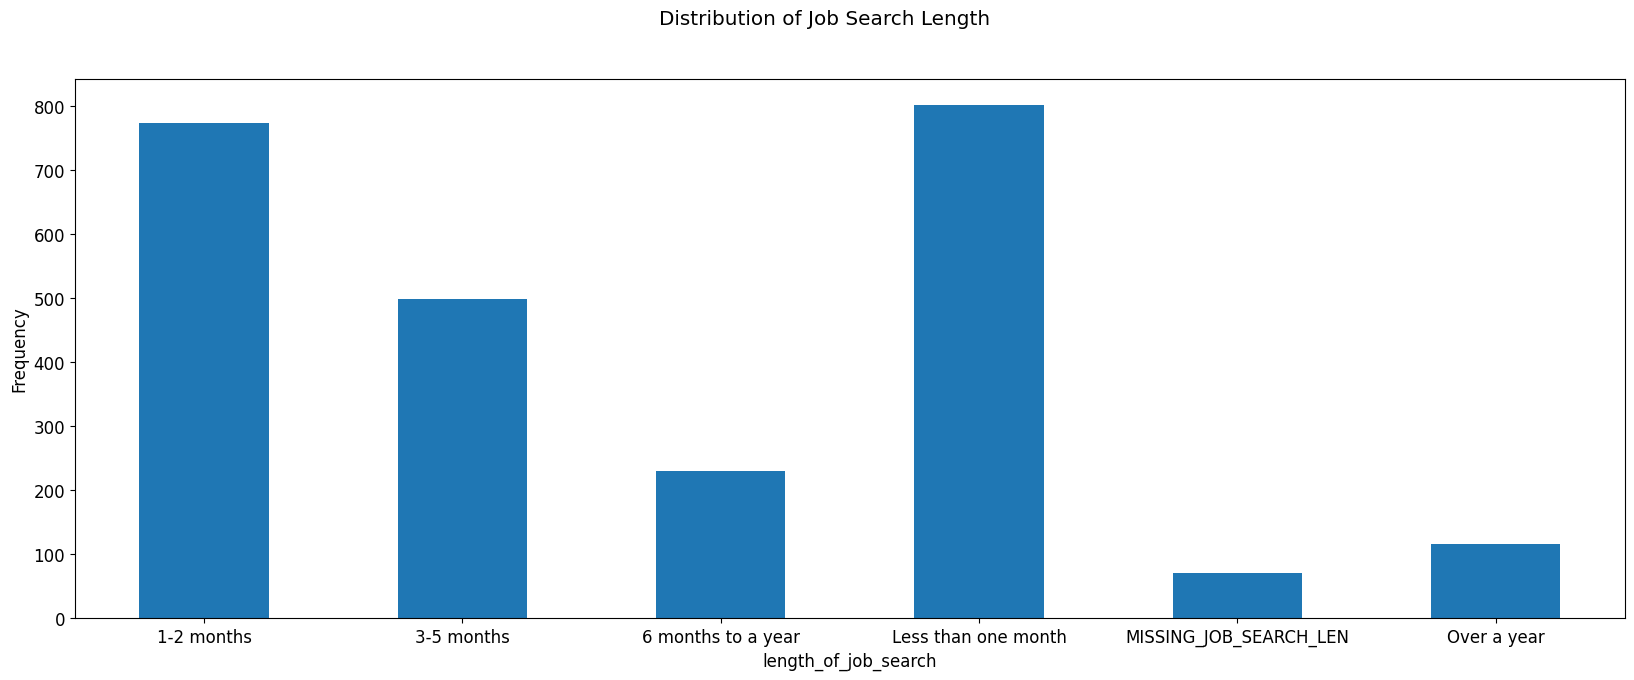

In [70]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Job Search Length')
df.groupby('length_of_job_search').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

### `professional_experience`

Again, we see this idea that most fellows are new to the job market scene, as most fellows have had less than a year of experience to 1-2 years.

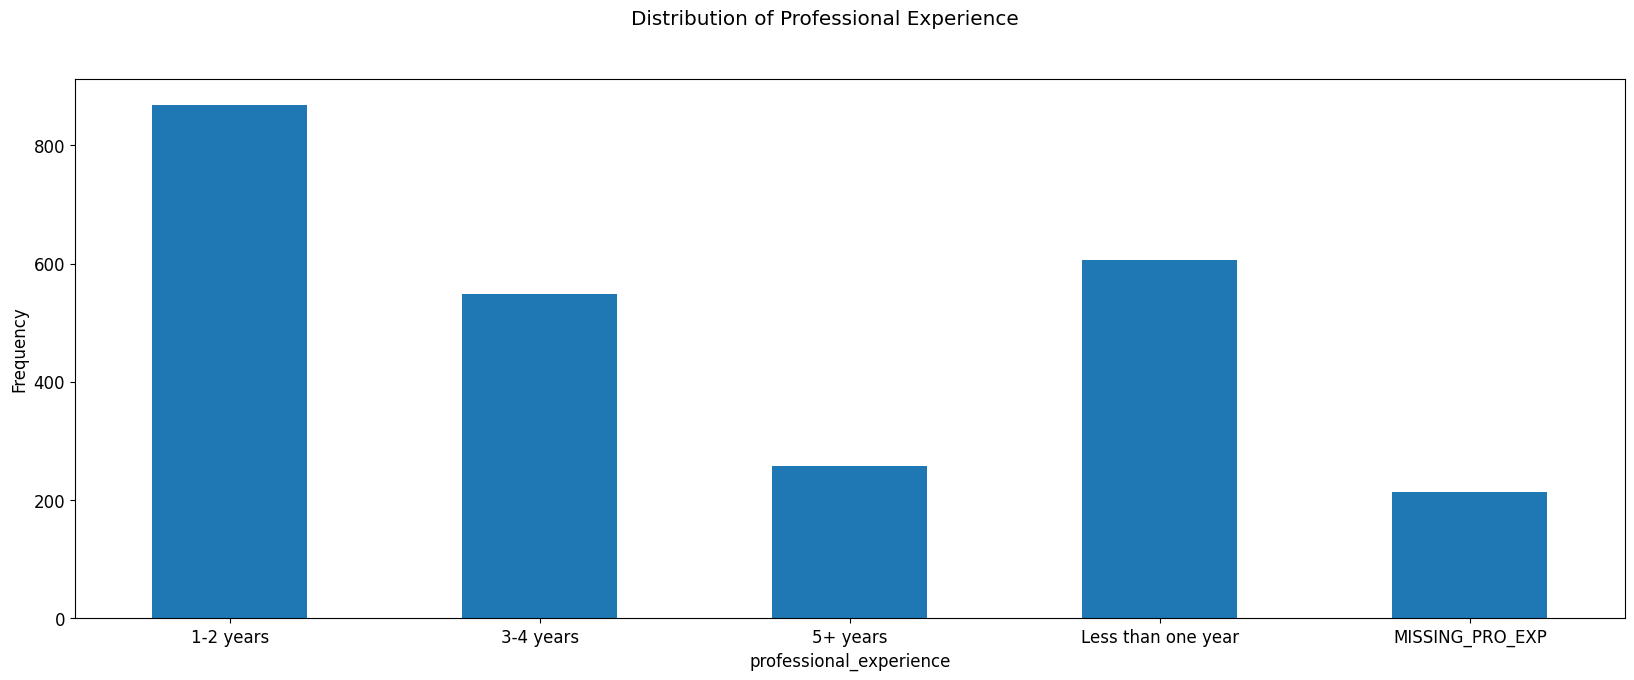

In [71]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Professional Experience')
df.groupby('professional_experience').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

### `work_authorization_status`

Most fellows are US Citizens. Being a US Citizen makes the job search process a bit easier, but more digging needs to be done if it were to actually impact a fellow being placed in a company.

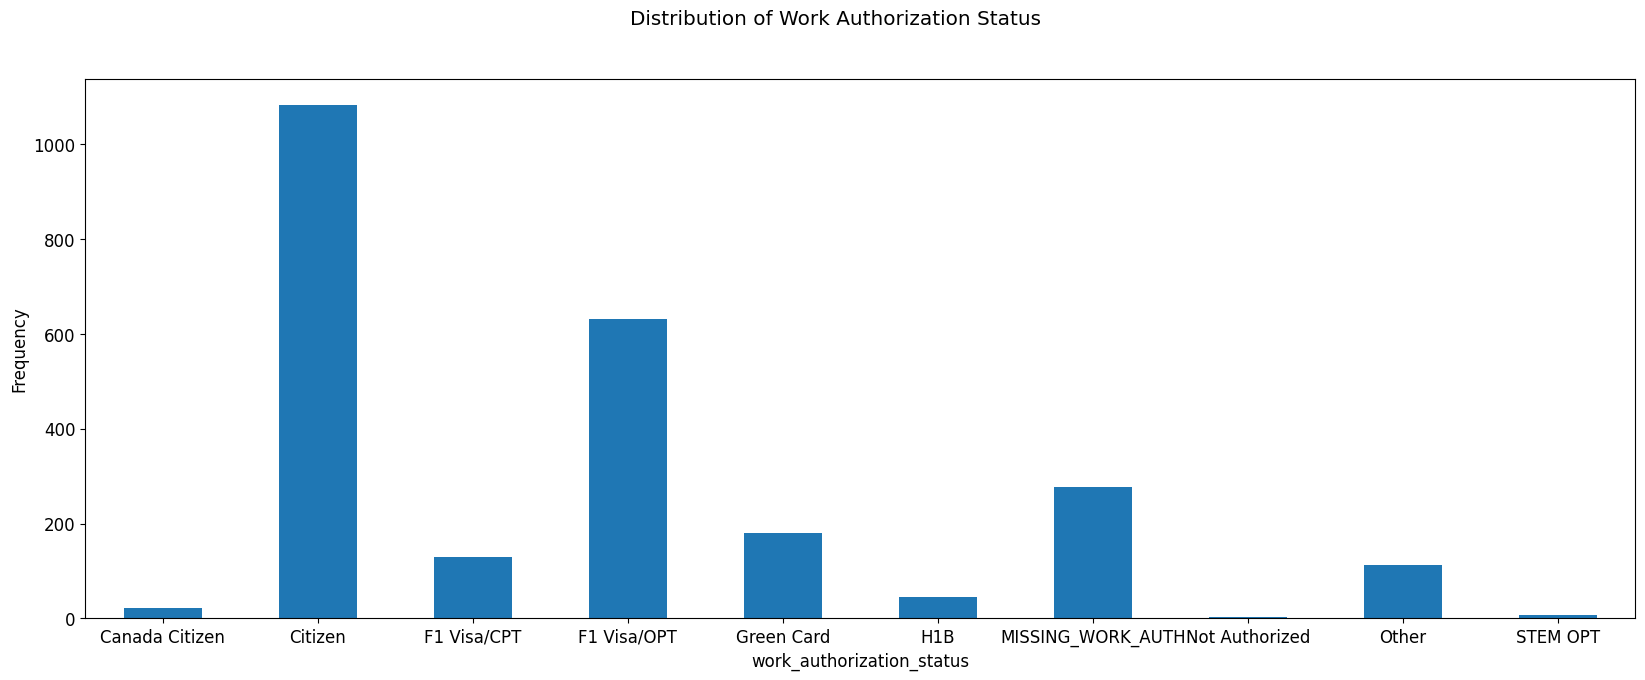

In [72]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Work Authorization Status')
df.groupby('work_authorization_status').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

### `primary_track`

A vast majority of fellows are in the Software Engineering Track. This makes sense, as Pathrise is mostly aimed towards helping up-and-coming software engineers to land a SWE role. A lot of Pathrise's resources are aimed at helping fellows land that SWE job.

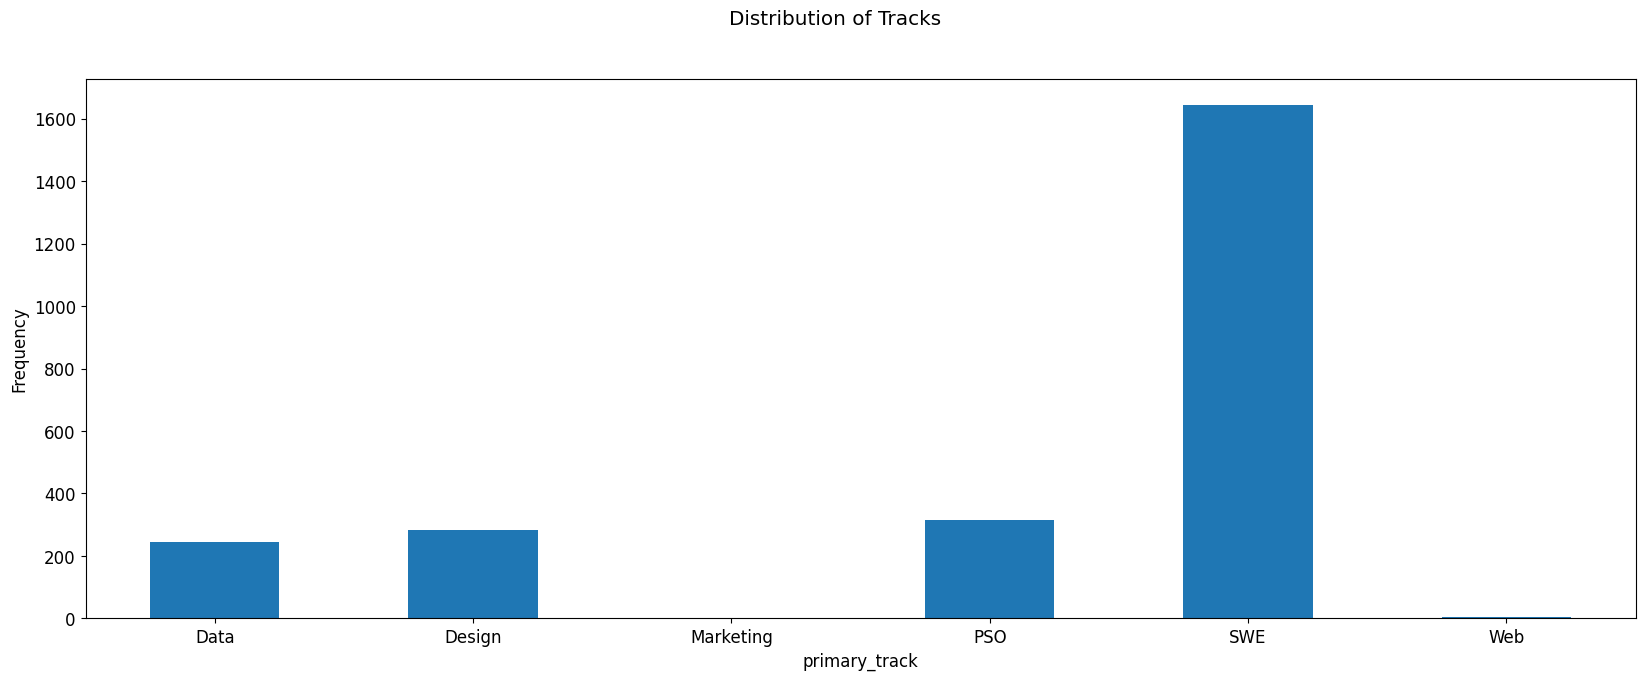

In [73]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Tracks')
df.groupby('primary_track').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

### `cohort_tag`

I'm going to engineer a new feature from this, which represents how recent the fellow was accepted into the program. This'll be done by scraping the year from the fellows `cohort_tag`. Getting to understand the amount of time the fellow was placed in the program could help in determining how long the fellow took to be placed, or in understanding how it might impact the fellow's status.

I'm not sure how this was tagged, but I assume that the first three characters correspond to the month, the next two digits correspond to the year, and the last character corresponds to the grouping.

In [74]:
df['cohort_tag'].unique()

array(['OCT19A', 'JAN20A', 'AUG19B', 'AUG19A', 'SEP19A', 'AUG19C',
       'DEC19A', 'FEB20A', 'NOV19A', 'NOV19B', 'JAN20B', 'FEB20B',
       'JUL19B', 'APR20A', 'OCT18A', 'SEP18C', 'OCT18B', 'JAN19A',
       'MAR19A', 'FEB19A', 'FEB19B', 'APR19A', 'AUG18A', 'DEC18A',
       'MAR19B', 'JAN19B', 'JUN19B', 'SEP18B', 'NOV18A', 'SEP18A',
       'APR19B', 'MAY19A', 'JUL19A', 'JUN19A', 'FEB18A', 'JUN18A',
       'MAR18A', 'APR18A', 'APR18B', 'MAY18A', 'OCT21A', 'SEP19B',
       'MAR20A', 'MAY19B', 'FEB20a', 'OCT19B', 'JAN18A'], dtype=object)

In [75]:
print("There are %d unique cohorts in this dataset." % len(df['cohort_tag'].unique()))

There are 47 unique cohorts in this dataset.


The oldest cohort is Group A from January, 2018.
The most recent cohort is Group A is from April, 2020.

There are some discrepencies. I see that there is one cohort tagged as "OCT21A". I also see two cohorts tagged as "FEB20A" and "FEB20a".

#### Fixing Discrepencies

In [76]:
# All cohorts tagged as FEB20a should be changed to FEB20A
df = df.replace({'cohort_tag': {'FEB20a': 'FEB20A'}})

In [77]:
# Look into OCT21A
df[df['cohort_tag'] == 'OCT21A']

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race,log_program_duration_days
364,365,Withdrawn,SWE,OCT21A,222.0,0,Employed Full-Time,Doctorate or Professional Degree,3-5 months,Hearing back on my applications,3-4 years,Citizen,2.0,40,Male,East Asian or Asian American,5.402677
2400,2401,Placed,SWE,OCT21A,257.0,1,Employed Full-Time,Bachelor's Degree,1-2 months,Lack of relevant experience,3-4 years,F1 Visa/CPT,0.0,3,Female,Non-Hispanic White or Euro-American,5.549076


There are only two rows where `cohort_tag` is "OCT21A". I could drop these rows, or I could try and change their cohort. 

In order to change the cohort effectively, my first line of thought was to use `program_duration_days` as a way to determine which cohort the fellow came from. For example, the first fellow in the above table was in the program for 222 days. 

In [78]:
df[df['program_duration_days'] == 222]

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race,log_program_duration_days
364,365,Withdrawn,SWE,OCT21A,222.0,0,Employed Full-Time,Doctorate or Professional Degree,3-5 months,Hearing back on my applications,3-4 years,Citizen,2.0,40,Male,East Asian or Asian American,5.402677
2118,2119,Placed,SWE,AUG19B,222.0,1,Employed Full-Time,Bachelor's Degree,Less than one month,Getting past mid-stage interviews,5+ years,MISSING_WORK_AUTH,1.0,3,Female,Two or More Races,5.402677
2470,2471,Placed,SWE,FEB20A,222.0,1,Student,Bachelor's Degree,3-5 months,Getting past final round interviews,MISSING_PRO_EXP,F1 Visa/OPT,3.0,30,MISSING_GENDER,Two or More Races,5.402677


In [79]:
df[df['program_duration_days'] == 257]

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race,log_program_duration_days
1435,1436,Placed,Data,JAN20A,257.0,1,Employed Part-Time,Master's Degree,1-2 months,Lack of relevant experience,1-2 years,F1 Visa/OPT,5.0,15,Male,East Asian or Asian American,5.549076
1757,1758,Placed,SWE,JUL19A,257.0,1,Student,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,1.0,15,Male,East Asian or Asian American,5.549076
2400,2401,Placed,SWE,OCT21A,257.0,1,Employed Full-Time,Bachelor's Degree,1-2 months,Lack of relevant experience,3-4 years,F1 Visa/CPT,0.0,3,Female,Non-Hispanic White or Euro-American,5.549076


Looking at other fellows with a similar amount of days in the program, I see that there is no consistency between the cohort and `program_duration_days`. The second fellow in the above list was placed in the AUG19B cohort and the third fellow was placed in the FEB20A cohort, yet both had a `program_duration_days` of 222. It's the same idea with looking at fellows with a `program_duration_days` of 257.

So, since only two fellows have a `cohort_tag` of OCT21A, then I'll just drop them from the dataset, as the cohort doesn't make sense. 

In [80]:
df.drop(df[df['cohort_tag'] == 'OCT21A'].index, inplace = True)
df['cohort_tag'].unique()

array(['OCT19A', 'JAN20A', 'AUG19B', 'AUG19A', 'SEP19A', 'AUG19C',
       'DEC19A', 'FEB20A', 'NOV19A', 'NOV19B', 'JAN20B', 'FEB20B',
       'JUL19B', 'APR20A', 'OCT18A', 'SEP18C', 'OCT18B', 'JAN19A',
       'MAR19A', 'FEB19A', 'FEB19B', 'APR19A', 'AUG18A', 'DEC18A',
       'MAR19B', 'JAN19B', 'JUN19B', 'SEP18B', 'NOV18A', 'SEP18A',
       'APR19B', 'MAY19A', 'JUL19A', 'JUN19A', 'FEB18A', 'JUN18A',
       'MAR18A', 'APR18A', 'APR18B', 'MAY18A', 'SEP19B', 'MAR20A',
       'MAY19B', 'OCT19B', 'JAN18A'], dtype=object)

### Feature engineering `has_prior_interviews`

This binary variable will be a 1 when the fellow has prior interviews coming into Pathrise i.e., they didn't use the Pathrise pipeline to record the amount of applications they sent out but already have some interviews coming along. More specifically, for fellows where their `number_of_interviews` is greater than their `number_of_applications`, then this'll be a 1. 

Prior to the program, these fellows have an interview already. They probably joined the program to get some tips on how to succeed. It's part of the reason why I joined Pathrise in the first place, too. 

It would be interesting to see if fellows who already have interviews coming up prior to Pathrise are more likely to withdraw after the trial or withdraw in general. I'll explore this question more later on.

In [81]:
def create_prior_interviews(x):
    """
    Returns whether or not the fellow has prior interviews. 
    This is determined by comparing the number of interviews the fellow has and
    the number of applications they sent out recorded by Pathrise. 
    
    Parameter:
    x - The Series to look through.
    
    Returns 1 if the fellow has prior interviews, 0 otherwise.
    """
    if x['number_of_interviews'] > x['number_of_applications']:
        return 1
    else:
        return 0

df['has_prior_interviews'] = df.apply(create_prior_interviews, axis = 1)

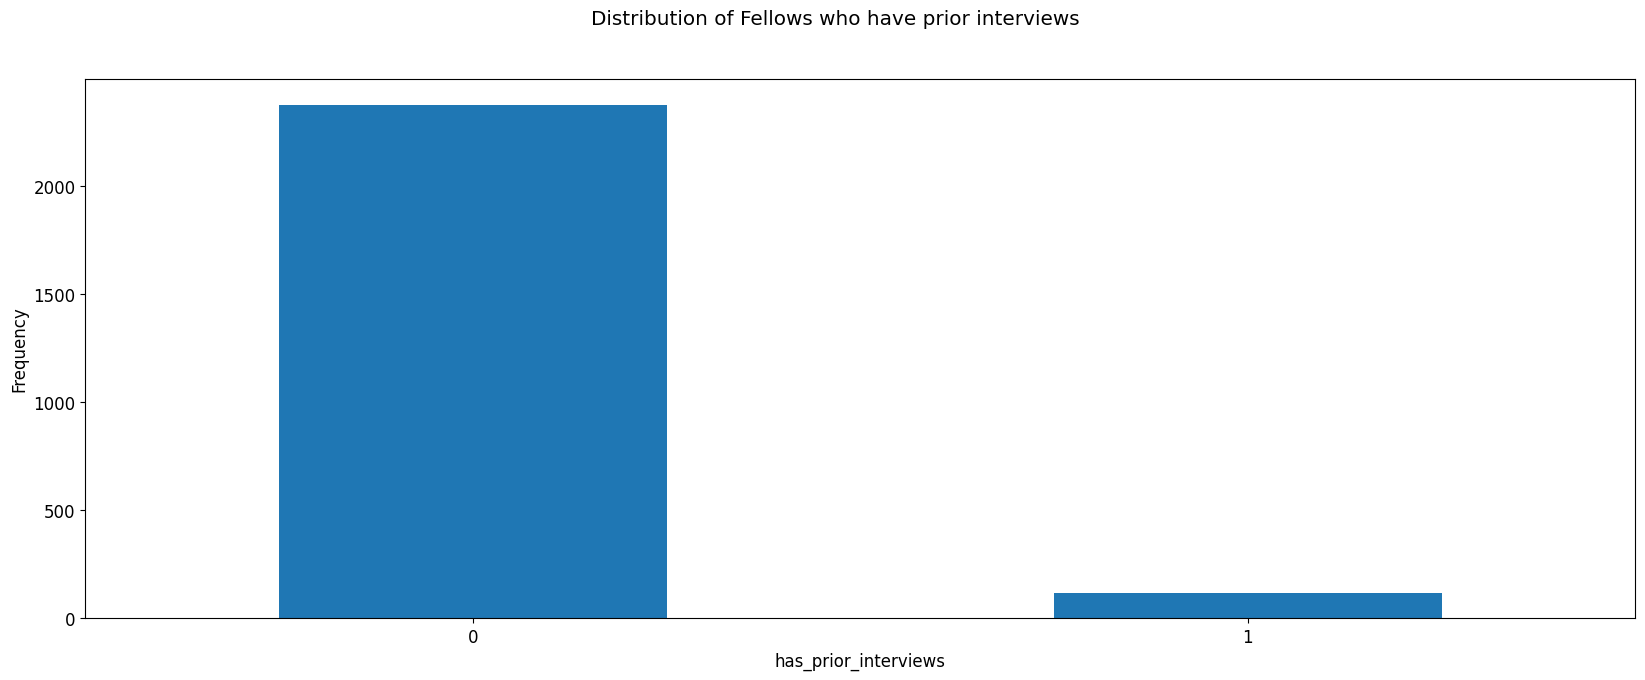

In [82]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Fellows who have prior interviews')
df.groupby('has_prior_interviews').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

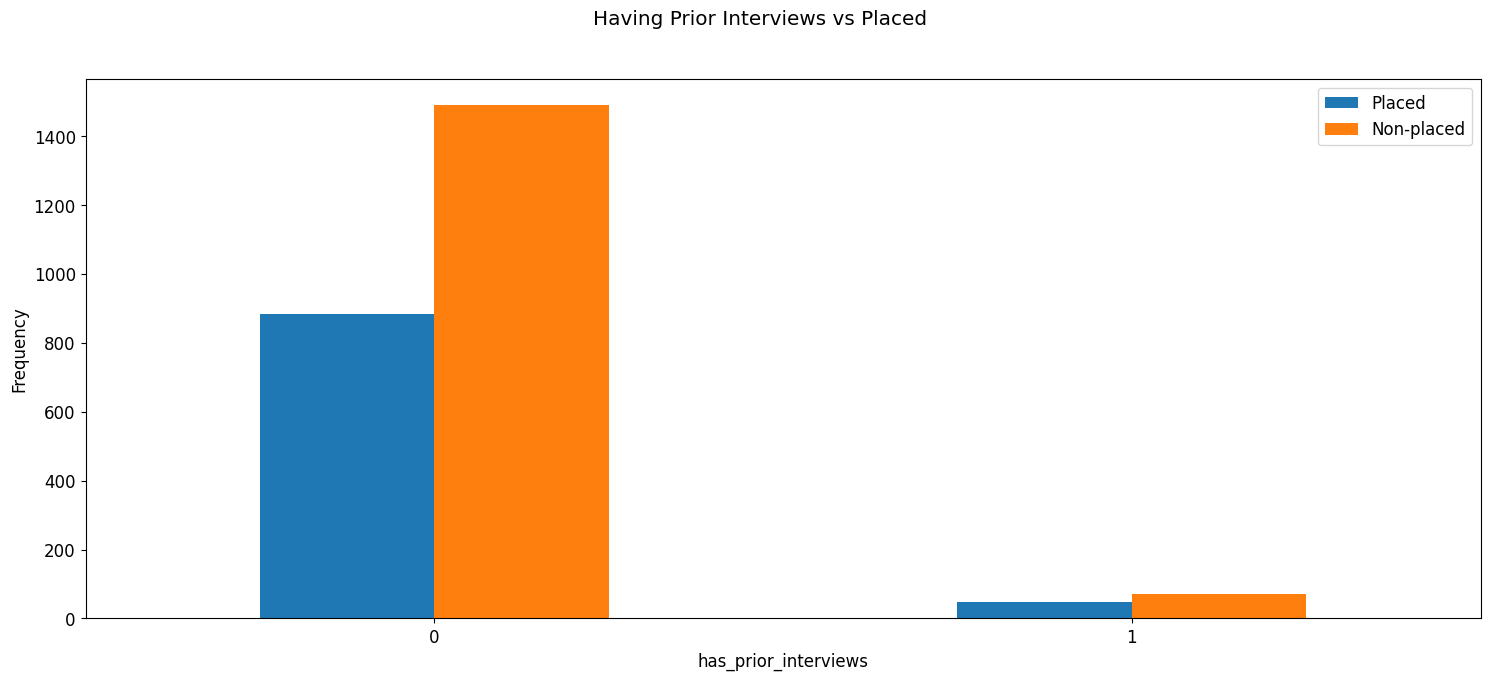

In [83]:
# Get distribution of placed and non-placed fellows against has_prior_interviews
placed_fellows_df = df[df['placed'] == 1]
non_placed_fellows_df = df[df['placed'] == 0]

fig, ax = plt.subplots(figsize = (18, 7))
fig.suptitle('Having Prior Interviews vs Placed')
plt.ylabel('Frequency')
create_placed_vs_var_df('has_prior_interviews').plot.bar(ax = ax, rot = 0)
plt.show()

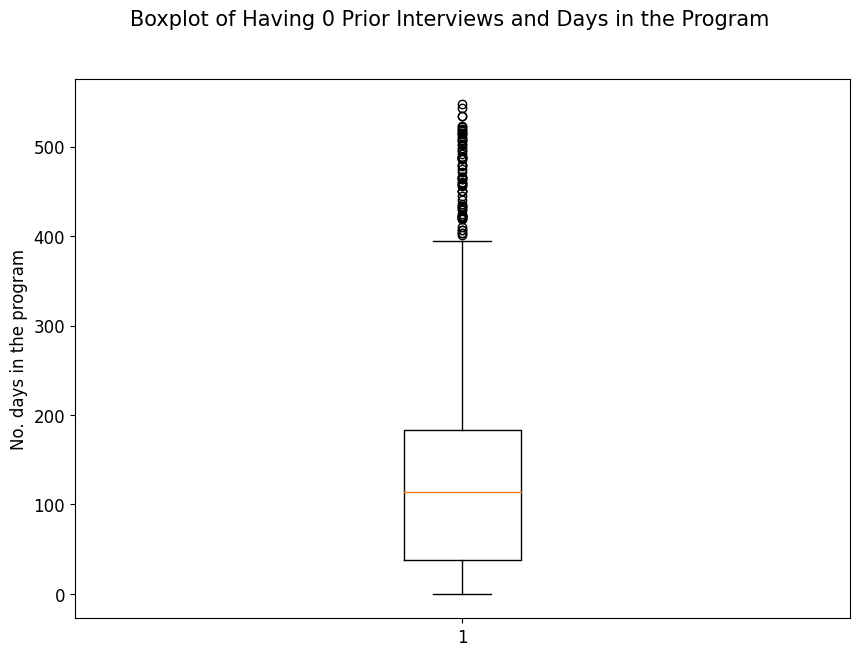

In [84]:
# Get distributions of having prior interviews vs program_duration_days
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Boxplot of Having 0 Prior Interviews and Days in the Program', fontsize = 15)
plt.boxplot(df[df['has_prior_interviews'] == 0]['program_duration_days'])
plt.ylabel('No. days in the program')
plt.show()

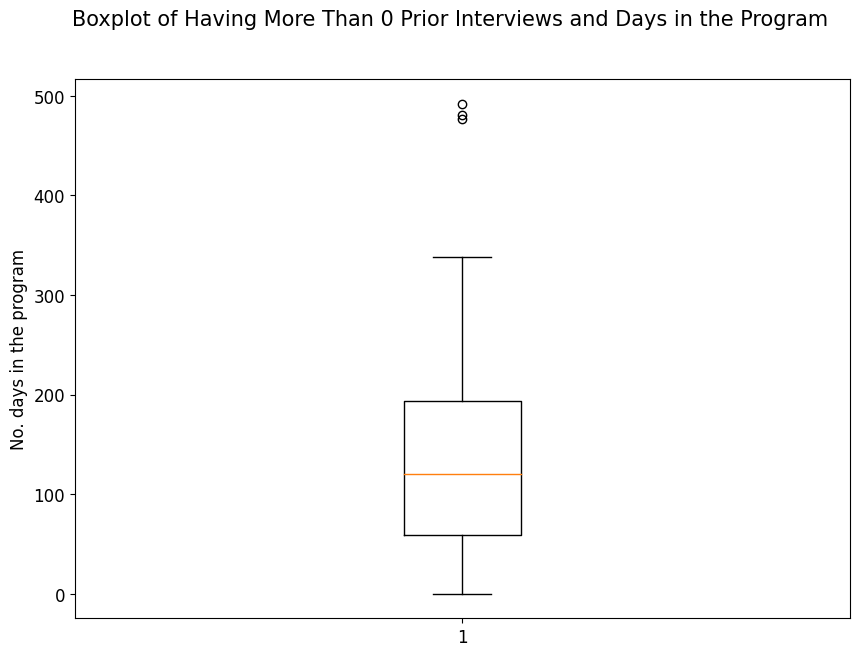

In [85]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Boxplot of Having More Than 0 Prior Interviews and Days in the Program', fontsize = 15)
plt.boxplot(df[df['has_prior_interviews'] == 1]['program_duration_days'])
plt.ylabel('No. days in the program')
plt.show()

A vast majority of fellows don't have interviews coming into the program. It makes sense, as the most common challenge for fellows was hearing back on applications.

Regardless, it seems that having a prior interview doesn't really impact how long you stay in the program, or whether or not you get placed. The distributions for both are very similar

Recall that there are two problems to solve here: a classification problem and a regression problem. In order to effectively model both, I'll have to determine the significance of the categorical variables for each of the two problems, since statistical significance depends on the dependent variable being examined. 

### Categorical Variables vs `placed`

Below I get an overview of the statistical significance of each of the categorical variables on `placed` by using a $\chi^2$ test.

A $\chi^2$ statistical test assumes that the null hypothesis $H_0$ is true i.e., that the observed frequencies for a categorical variable matches the expected frequencies for that categorical variable. When we run this test and see that the p-value is less than the significance level $\alpha$, which I've chosen to be 0.05 since it's the most standard value, then we reject $H_0$. In other words, the observed frequencies of the categorical variablesis different than the expected frequencies. Therefore, we can conclude that the two variables do interact with each other i.e., the categorical variable is statistically significant in determining `placed`, or that `placed` is dependent on the categorical variable.

I'll do a $\chi^2$ test for each of the categorical variables I went through above.


Description of p-value:

The p-value is the probability that the null hypothesis is true. (1 – the p-value) is the probability that the alternative hypothesis is true. A low p-value shows that the results are replicable. A low p-value shows that the effect is large or that the result is of major theoretical, clinical or practical importance.

Null hypothesis: there is no difference in longevity between the two groups.

Alternative hypothesis: there is a difference in longevity between the two groups.

The below code displays the relevancy of feaures.

In [86]:
stat_sig_categ_vars_placed = [] # Holds stat. significant features for classification problem

for categ_var in categ_vars:    
    data_crosstab = pd.crosstab((df[categ_var]), df['placed'],  margins = False)
    stat, p, dof, expected = stats.chi2_contingency(data_crosstab.values)
    
    '''
    Returns
    
    chi2float
    The test statistic.

    pfloat
    The p-value of the test

    dofint
    Degrees of freedom

    expectedndarray, same shape as observed
    The expected frequencies, based on the marginal sums of the table.
    
    '''
    
    # Check if statistically significant by comparing p-value to alpha = 0.05
    if p < 0.05:
        stat_sig_categ_vars_placed.append(categ_var)

In [87]:
stat_sig_categ_vars_placed

['gender',
 'race',
 'pathrise_status',
 'professional_experience',
 'primary_track',
 'cohort_tag']

Above are the categorical variables deemed statistically significant by my $\chi^2$ test. It's surprising to see that `employment_status`, `highest_level_of_education`, `length_of_job_search`, and `work_authorization_status` didn't make the cut. This might be due to how I chose my $\alpha$ level, or some other reason not captured in the data. So, for my modelling, I'll only encode and use the statistically significant categorical variables.

Also, my feature-engineered `has_prior_interviews` didn't make the cut. This might be due to me misinterpreting the information present in the data.

In [88]:
for stat_sig_categ_var in stat_sig_categ_vars_placed:
    one_hot_enc(stat_sig_categ_var, True)
    
# Drop Placed from one-hot encoding pathrise_status, 
# since this is already captured by placed (the dependent variable)
one_hot_categ_vars_placed.remove('Placed')
df.drop(columns = ['Placed'], inplace = True)

### Categorical Variables vs `program_duration_days`

Let's determine which of the categorical variables are statistically significant for the regression problem of determining how long it takes a fellow to be placed using a One-Way ANOVA test. 

This test is used to determine whether there are any statistically significant differences between the means of different groups/ levels. $H_0$ would then be that the means of these different groups are the same. If the calculated p-value were less than 0.05, then we reject $H_0$.

In [89]:
def determine_sig_anova(categ_var, dv):
    """
    Determines the significance of a categorical variable using an ANOVA test.
    
    Parameters:
    categ_var - The feature to test on.
    dv - The feature to test against.
    
    Returns True if the groups are different, False otherwise
    """
    levels = df[categ_var].unique()
    all_types = [] # List of lists for each level's program_duration_days
    for level in levels:
        prog_dur_days = df[df[categ_var] == level][dv].values
        all_types.append(prog_dur_days)
    
    # Reject H0?
    pval = stats.f_oneway(*all_types)[1]
    if pval < 0.05:
        return True
    else:
        return False

In [90]:
stat_sig_categ_vars_place_time = [] # Holds statistically significant variables for regression problem

for categ_var in categ_vars:
    if determine_sig_anova(categ_var, 'program_duration_days'):
        stat_sig_categ_vars_place_time.append(categ_var)

In [91]:
stat_sig_categ_vars_place_time

['gender', 'pathrise_status', 'cohort_tag']

In [92]:
# Encode variables above
for stat_sig_categ_var in stat_sig_categ_vars_place_time:
    one_hot_enc(stat_sig_categ_var, False)

For the classification problem, the statistically significant categorical variables are:
- `gender`
- `race`
- `pathrise_status`
- `professional_experience`
- `primary_track`
- `cohort_tag`

For the regression problem, they are:
- `gender`
- `pathrise_status`
- `cohort_tag`

It's interesting to see that some categorical variables are excluded from either list, and some, like `work_authorization_status`, are completely neglected. Also, `cohort_tag` is more important that I had initially thought. 

A future experiment can go into including these variables in our analysis, or changing up my $\alpha$ values.

## Quantitative Variables

The quantitative variables include:
- `years_in_cohort`, which I go into more detail below
- `number_of_interviews`
- `number_of_applications`
- `interview_turnout`, which I go into more detail below

In [93]:
quant_vars = ['number_of_interviews', 'number_of_applications', 'years_in_cohort', 'interview_turnout']

In [94]:
quant_enc_vars = [] # Holds the names of the encoded quantitative variables

### Feature Engineering `years_in_cohort`

Here, I will use `cohort_tag` to determine how long the fellow was in the cohort at Pathrise. Again, the most recent cohort is APR20A. So, the year inherent in other fellows' `cohort_tag` will be subtracted from APR20A to get an estimate of the amount of time the fellow was in a cohort with Pathrise.

This new feature might give more insight into how a fellow's placement time may be influenced by how long they've been in a cohort at Pathrise. Although `program_duration_days` explains this aspect of the data more, some values from there are missing, and so this hand-engineered feature might provide some more insight into that missing data. 

My intuition is that those who just got into the program may not be placed yet, whereas those who have been in a cohort longer would be more likely to be placed. 

In [95]:
def create_years_in_cohort(cohort_tag):
    """
    Uses the given cohort_tag, strips off the year, and subtracts it from 20 to get the number of years
    the fellow was in the cohort at Pathrise. 
    """
    cohort_year = int(cohort_tag[3:-1]) # Year is always the 4th and 5th characters in the cohort_tag
    return 20 - cohort_year 

In [96]:
df['years_in_cohort'] = df['cohort_tag'].apply(create_years_in_cohort)

In [97]:
df['years_in_cohort'].describe()

count    2492.000000
mean        1.152488
std         0.645540
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: years_in_cohort, dtype: float64

On average, fellows were in a cohort for over a year. 
Below, we can see that a majority of fellows have been in their cohort for a year.
Half of that amount constitutes the fellows who have been in the cohort for 2 years, and there are not a lot of 2020 fellows. 

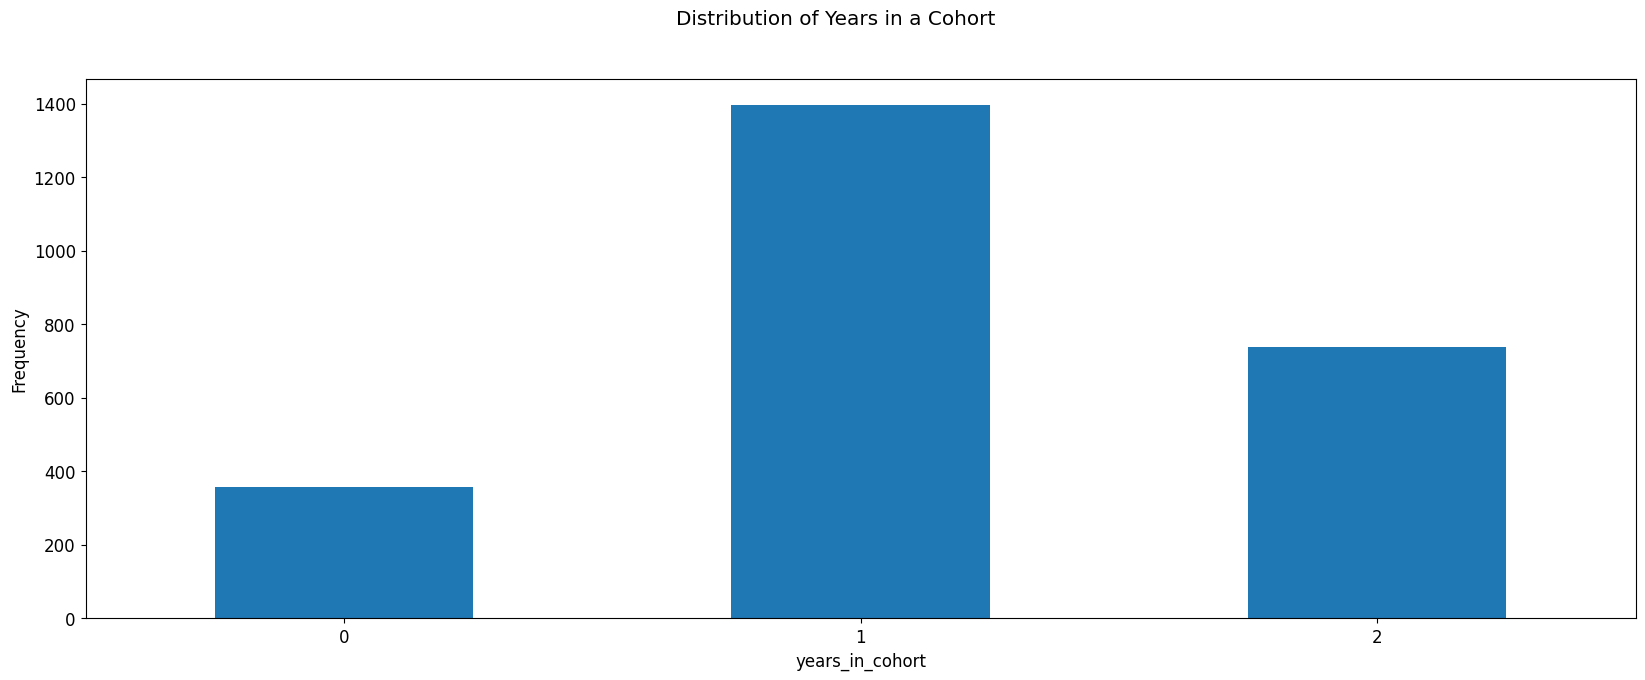

In [98]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Years in a Cohort')
df['years_in_cohort'].astype('object').to_frame().groupby('years_in_cohort').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

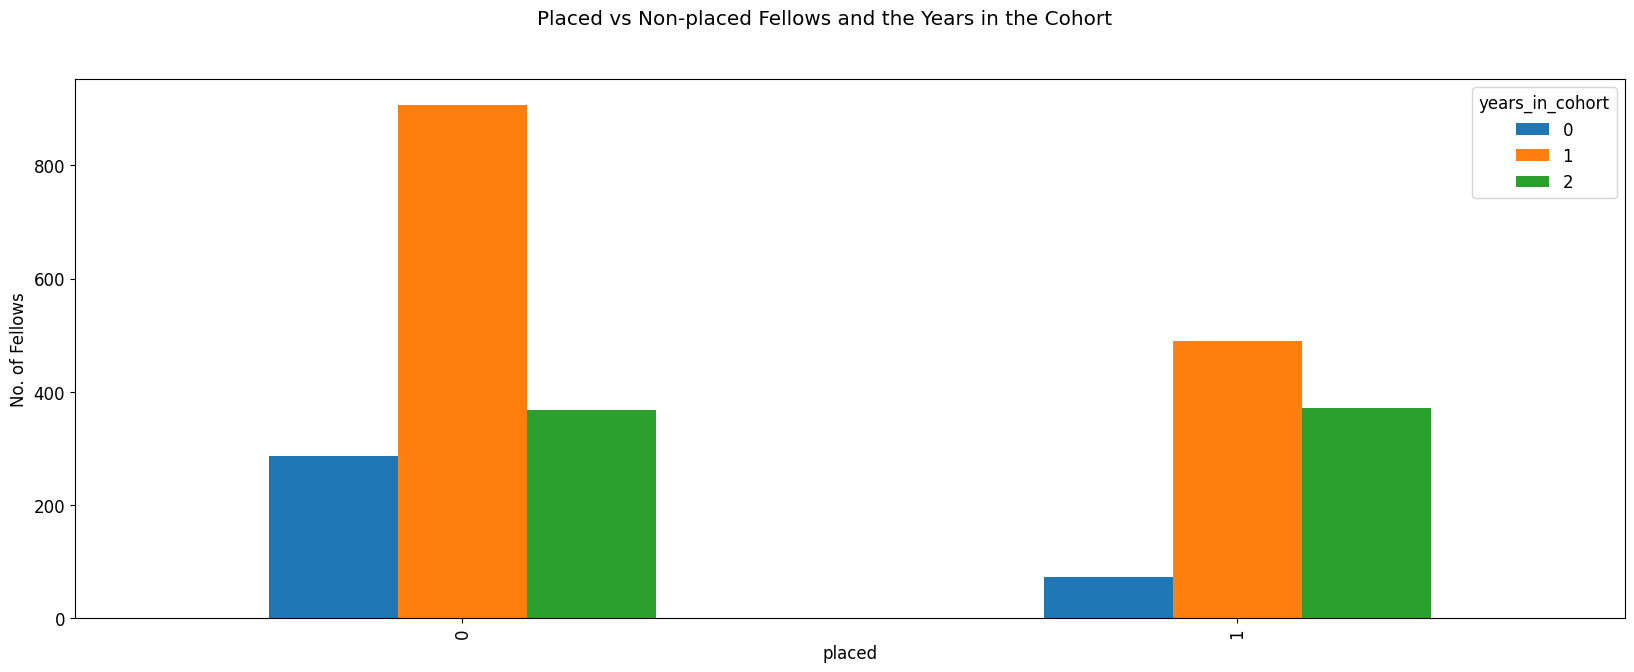

In [99]:
# Distribution of placed and non-placed fellows
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Placed vs Non-placed Fellows and the Years in the Cohort')
df.groupby(['placed', 'years_in_cohort']).size().unstack().plot.bar(ax = ax)
plt.ylabel('No. of Fellows')
plt.show()

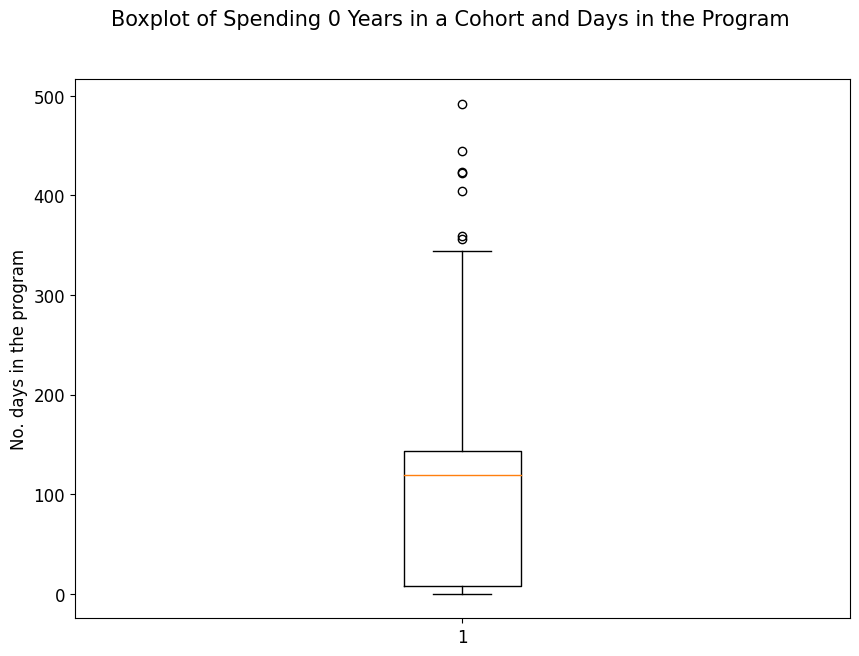

In [100]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Boxplot of Spending 0 Years in a Cohort and Days in the Program', fontsize = 15)
plt.boxplot(df[df['years_in_cohort'] == 0]['program_duration_days'])
plt.ylabel('No. days in the program')
plt.show()

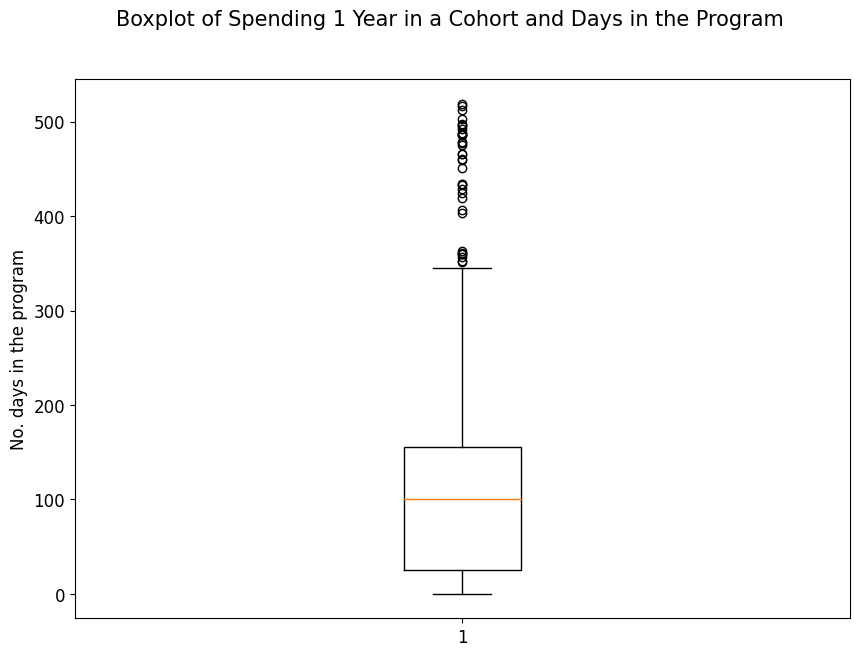

In [101]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Boxplot of Spending 1 Year in a Cohort and Days in the Program', fontsize = 15)
plt.boxplot(df[df['years_in_cohort'] == 1]['program_duration_days'])
plt.ylabel('No. days in the program')
plt.show()

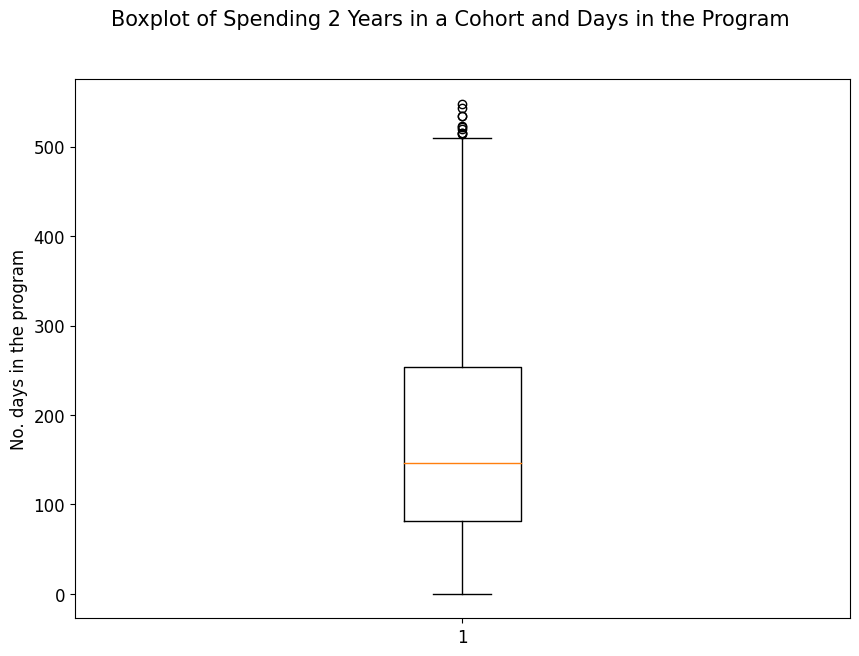

In [102]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Boxplot of Spending 2 Years in a Cohort and Days in the Program', fontsize = 15)
plt.boxplot(df[df['years_in_cohort'] == 2]['program_duration_days'])
plt.ylabel('No. days in the program')
plt.show()

A vast majority of unplaced fellows are in the most recent cohort. This means that fellows don't typically place in a company right away after being with Pathrise - it takes time. In terms of placement time, it seems that 2018 cohorts spend more time in the program, which makes sense. 

What's interesting to see is the fact that these number of years exist in the first place - Pathrise explicitly states that a fellow's contract is terminated if no position can be found within a year, with some exceptions. So, fellows who have been in a cohort for two years should be exceptions to contract termination. 

If the `years_in_cohort` is 1, then I'll be a bit more lenient in those cases, as I simply subtracted 2020 from the year in their cohort_tag. For example, being in the DEC19A cohort means that, per my imputations, you'll be recorded as having a 1 in `years_in_cohort` when in reality, this isn't the case. More tidier imputations could be investigated in the future.

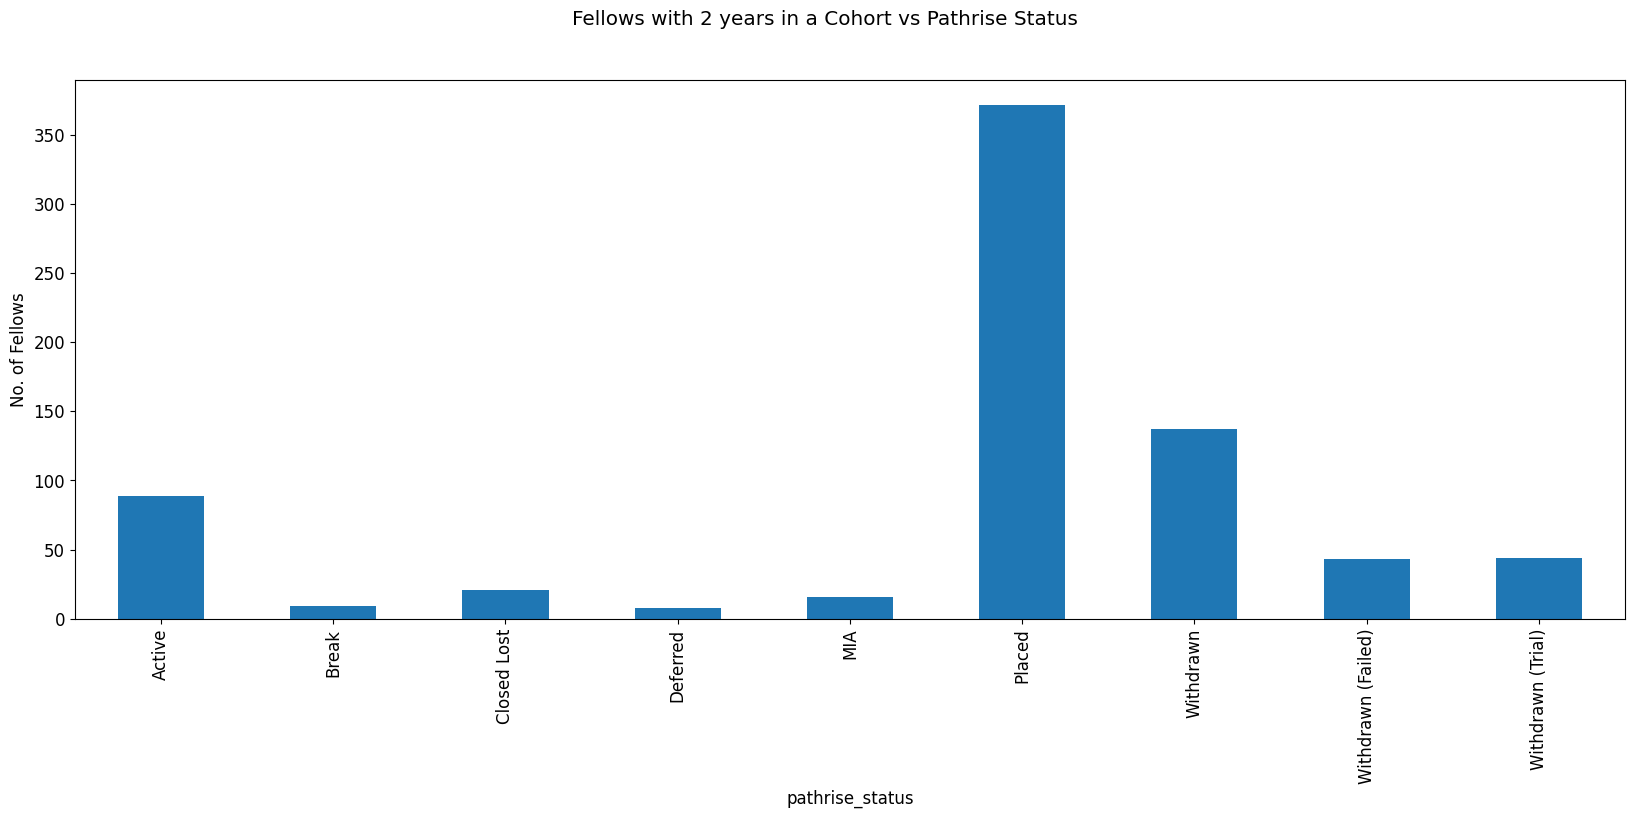

In [103]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Fellows with 2 years in a Cohort vs Pathrise Status')
df[df['years_in_cohort'] == 2].groupby('pathrise_status').size().plot.bar(ax = ax)
plt.ylabel('No. of Fellows')
plt.show()

A majority of fellows with 2 years in a cohort have placed at a company. Otherwise, they have withdrawn from the program, or are on break, etc. There is also a small number of them who are still active. Pathrise states that the contract can be expanded if the fellow is on a break, meaning that these fellows must've been on a break in the past and are still able to continue their fellowship with Pathrise. 

This graph, upon first glance, shows that a majority of fellows with 2 years in a cohort have been placed, going along with my initial intuition that being in Pathrise longer helps you get placed. However, that isn't really the case. Let's look at the average `program_duration_days` for placed fellows who have spent 0, 1, and 2 years in a cohort.

In [104]:
print("Placed fellows with 0 years in a cohort spent %d days on average in the program." % df[(df['years_in_cohort'] == 0) & (df['placed'] == 1)]['program_duration_days'].describe()['mean'])

Placed fellows with 0 years in a cohort spent 193 days on average in the program.


In [105]:
print("Placed fellows with 1 year in a cohort spent %d days on average in the program." % df[(df['years_in_cohort'] == 1) & (df['placed'] == 1)]['program_duration_days'].describe()['mean'])

Placed fellows with 1 year in a cohort spent 148 days on average in the program.


In [106]:
print("Placed fellows with 2 years in a cohort spent %d days on average in the program." % df[(df['years_in_cohort'] == 2) & (df['placed'] == 1)]['program_duration_days'].describe()['mean'])

Placed fellows with 2 years in a cohort spent 171 days on average in the program.


These lines show that regardless of the amount of days spent in a cohort, all placed fellow, regardless of their initial cohort, spent a similar amount of time in the program to get placed: a little over 4 months.

So, my initial intuition is half-right, half-wrong. I was right in thinking that most 2020 fellows have not been placed yet, as it takes time to "get the ball rolling" in terms of job applications. They just got into the program, and so it makes sense that they wouldn't be placed right away.

However, I was wrong in thinking that fellows from an older cohort have a higher chance of getting placed. Looking at the above statements, it takes about the same amount of time for a 2018 fellow and a 2019 fellow to be placed. Being from an older cohort doesn't necessarily mean you'll be able to be placed at a company sooner.  

### `number_of_interviews`

Below are some statistics regarding `number_of_interviews`, as well as a histogram of the distribution of number of interviews.

The distribution seems skewed towards positive values, and so the median would be more appropriate, which in this case is 1 interview. Running my normality test and looking at the kurtosis and skewness confirms that this distribution isn't normal.



In [107]:
df['number_of_interviews'].describe()

count    2492.000000
mean        2.082263
std         2.851900
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        20.000000
Name: number_of_interviews, dtype: float64

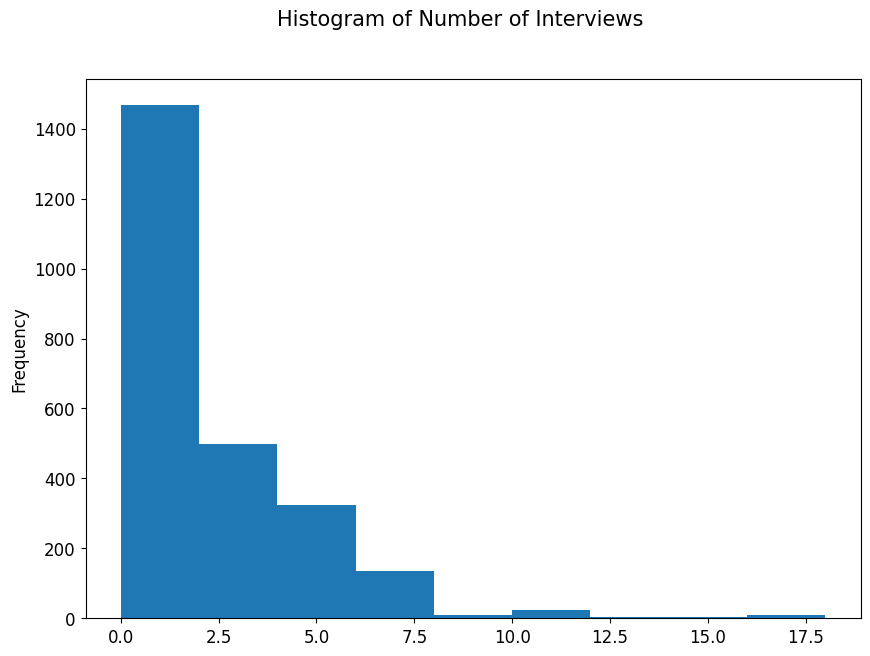

In [108]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Histogram of Number of Interviews', fontsize = 15)
plt.hist(df['number_of_interviews'], bins = np.arange(0, 20, 2))
plt.ylabel('Frequency')
plt.show()

In [109]:
# Run normality test
print("Is this distribution normal?", is_normal(df['number_of_interviews']))
print('Skewness:', df['number_of_interviews'].skew())
print('Kurtosis:', df['number_of_interviews'].kurtosis())

Is this distribution normal? False
Skewness: 3.194844920892175
Kurtosis: 14.690323383032965


### `number_of_applications`

Below are some statistics regarding `number_of_applications`, as well as a histogram of the distribution of number of interviews.

Again, the distribution seems skewed towards positive values, and so the median would be more appropriate, which in this case is 20 applications. Running my normality test and looking at the kurtosis and skewness confirms that this distribution isn't normal. The tail is extremely long in this case, meaning that there could potentially be lots of outliers.

In [110]:
df['number_of_applications'].describe()

count    2492.000000
mean       36.353933
std        53.671645
min         0.000000
25%         9.000000
50%        20.000000
75%        45.000000
max      1000.000000
Name: number_of_applications, dtype: float64

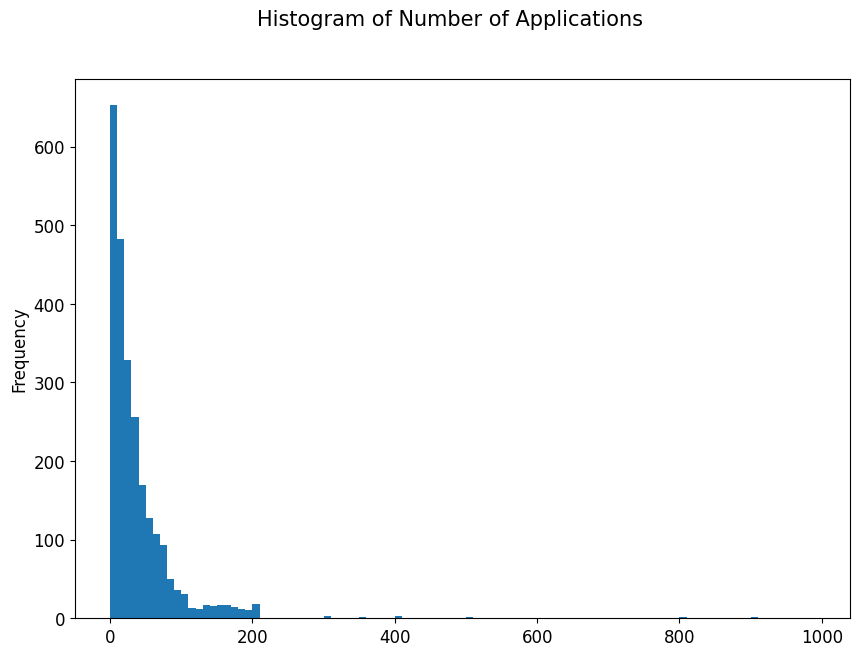

In [111]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Histogram of Number of Applications', fontsize = 15)
plt.hist(df['number_of_applications'], bins = np.arange(0, 1000, 10))
plt.ylabel('Frequency')
plt.show()

In [112]:
# Run normality test
print("Is this distribution normal?", is_normal(df['number_of_applications']))
print('Skewness:', df['number_of_applications'].skew())
print('Kurtosis:', df['number_of_applications'].kurtosis())

Is this distribution normal? False
Skewness: 7.0755221405440025
Kurtosis: 92.9362432000606


### Feature Engineering `interview_turnout`

This feature is calculated as `number_of_interviews` / `number_of_applications`. This is a number from $[0, 1]$ and is meant to capture the proportion of applications that turned into interviews for each fellow. I'm curious to see how this differs for placed and non-placed fellows. 

First off, let's see if using this calculation makes sense.

In [113]:
(df['number_of_interviews'] / df['number_of_applications']).head()

0    0.002222
1         inf
2         NaN
3    0.200000
4    0.100000
dtype: float64

In [114]:
df[['number_of_interviews', 'number_of_applications']].head()

,number_of_interviews,number_of_applications
0,2.0,900
1,6.0,0
2,0.0,0
3,5.0,25
4,10.0,100


Right off the bat we can see some weird values, like $\infty$ and NaN. Looking closely we can see that some fellows sent out 0 applications and/or recieved more interviews than applications sent out.

I explained before when I feature-engineered `has_prior_interviews` why this might be the case.

So, here's what I'll do for `interview_turnout`:

For fellows who sent out 0 applications and got 0 interviews i.e., the third fellow in the above table, I'll impute `interview_turnout` as a 0, since they haven't done anything yet.

As for fellows where `number_of_interviews` > `number_of_applications`, I'll also impute `interview_turnout` as 0, since I already have another binary feature `has_prior_interviews`, which will be a 1 if the fellow does have prior interviews, and a 0 if the fellow doesn't.

In [115]:
def calculate_interview_turnout(x):
    """
    Calculates the interview turnout for a fellow by dividing number of interviews they sent out by the
    number of applications.
    For fellows who have prior interviews, this will be a 0 since that information is already captured
    by has_prior_interviews. For fellows with 0 interviews and 0 applications sent, this will also be 0.
    
    Parameters:
    x - The Series to look through.
    
    Returns 0 if the fellow falls into the criteria explained above, or the number of interviews divided by
    the number of applications otherwise.
    """
    if x['has_prior_interviews'] == 1 or (x['number_of_interviews'] == 0  and x['number_of_applications'] == 0):
        return 0
    else:
        return x['number_of_interviews'] / x['number_of_applications']

In [116]:
df['interview_turnout'] = df.apply(calculate_interview_turnout, axis = 1)

In [117]:
df['interview_turnout'].describe()

count    2492.000000
mean        0.118574
std         0.206157
min         0.000000
25%         0.000000
50%         0.033333
75%         0.133333
max         1.000000
Name: interview_turnout, dtype: float64

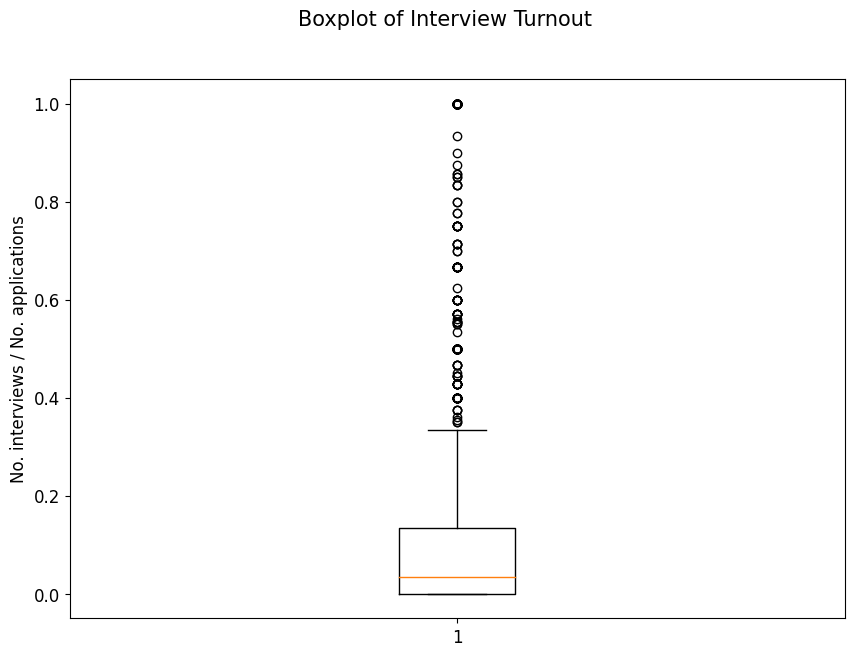

In [118]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Boxplot of Interview Turnout', fontsize = 15)
plt.boxplot(df['interview_turnout'])
plt.ylabel('No. interviews / No. applications')
plt.show()

In [119]:
# Run normality test
print("Is this distribution normal?", is_normal(df['interview_turnout']))
print('Skewness:', df['interview_turnout'].skew())
print('Kurtosis:', df['interview_turnout'].kurtosis())

Is this distribution normal? False
Skewness: 2.7059426515654343
Kurtosis: 7.549918283527583


This distribution is not normal, and there seems to be lots of outliers. Looking at the skewness and kurtosis and the normality test proved my point. So using the median `interview_turnout`, which is 0.03 or 3% interview turnout, is a better measure of central tendency.

### Quantitative Variables vs `placed`

Let's check the statistical significance of these quantitative variables against `placed` for my classification problem. 

In [120]:
quant_vars.append('program_duration_days') # This feature is just another independent variable for my classification problem
stat_sig_quant_vars_placed = []

for quant_var in quant_vars:
    if determine_sig_anova('placed', quant_var):
        stat_sig_quant_vars_placed.append(quant_var)

In [121]:
stat_sig_quant_vars_placed

['years_in_cohort', 'program_duration_days']

What's surprising here is to see that `number_of_interviews` and `number_of_applications` aren't considered statistically significant with an $\alpha$ of 0.05 for a one-way ANOVA test. Also, `interview_turnout` wasn't considered. This could be because of how I engineered it to come from other statistically insignificant variables.

This suggests that fellows, regardless of being placed or not, submit almost an equal amount of applications and get an equal amount of interviews. Both types of fellows try similarly in terms of physically sending out applications, and also get a similar amount of interviews back. 

$\alpha$ could be altered, but regardless this is interesting. 
So, I'll only include `years_in_cohort` and `program_duration_days` in my model. A follow-up to this project could look into how the model is influenced by including these other quantitative variables.

### Quantitative Variables vs `program_duration_days`

Let's see how the quantitative variables are correlated with `program_duration_days`.

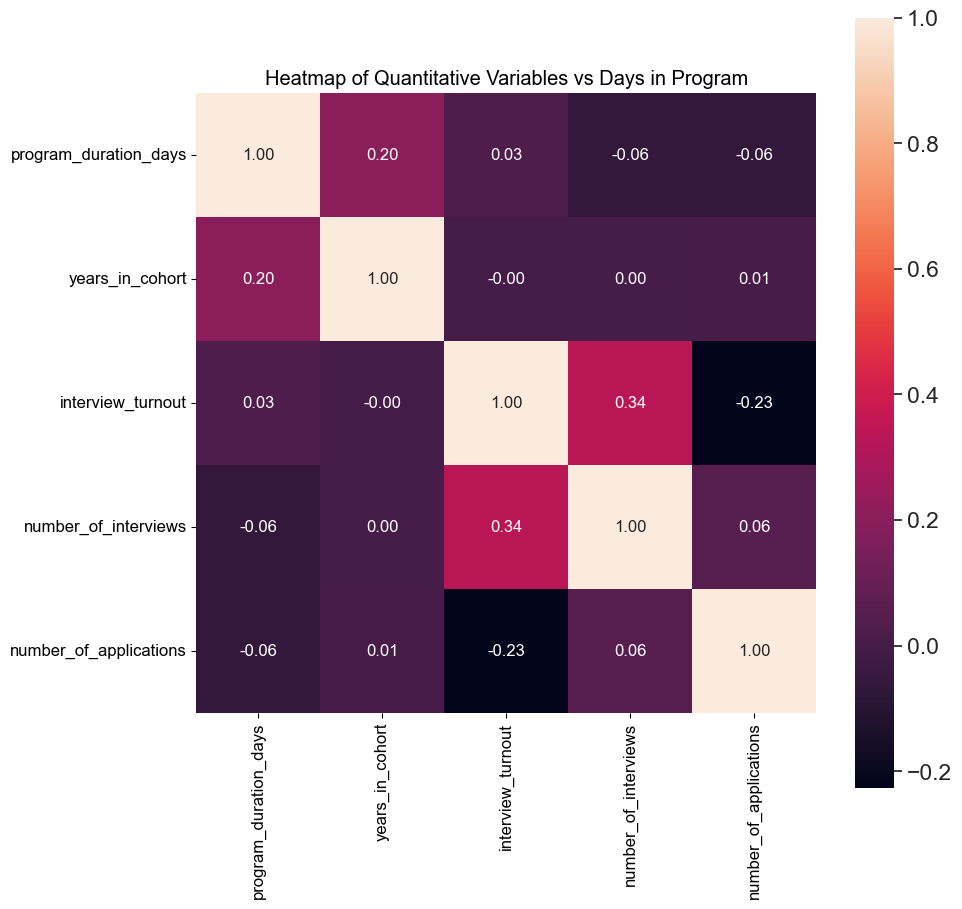

In [122]:
# Get a quick look at the correlations between the quantitative variables and price
corrmat = df[['program_duration_days', 'number_of_interviews', 'number_of_applications', 'years_in_cohort', 
              'interview_turnout']].corr()

f, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Heatmap of Quantitative Variables vs Days in Program')
k = 10 
cols = corrmat.nlargest(k, 'program_duration_days')['program_duration_days'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Looking at the correlational heatmap gives some interesting insights:

- `years_in_cohort` is the strongest in terms of being correlated with `program_duration_days`.
- `number_of_interviews` and `number_of_applications` are both weakly, negatively correlated with `program_duration_days`. That means more interviews and applications for a fellow is very weakly correlated with a decrease in `program_duration_days`. 
- There is multicollinearity between `number_of_applications`, `number_of_interviews`, and `interview_turnout`, but that's because of how I calculated `interview_turnout`. 

For modelling, I'll only keep `years_in_cohort`, since it's the strongest in terms of correlation with `program_duration_days`. Further experiments can look into how the other quantitative variables do. Let's look into encoding it now.

In [123]:
# Check if normal, encode if not normal
if is_normal(df['years_in_cohort']):
    print('The data is normal.')
else:
    print('The data is NOT normal!')

The data is NOT normal!


In [124]:
# Encode and append to list of quantitative variables to use for modelling
df['enc_years_in_cohort'] = df['years_in_cohort'].apply(lambda x: np.log(abs(x)) if x > 0 else 0)
quant_enc_vars.append('enc_years_in_cohort')

In [125]:
quant_enc_vars

['enc_years_in_cohort']

For both the classification and regression problem, only `years_in_cohort` is significant.

## Other things to consider

**Question**: Are fellows with interviews on the line already coming into Pathrise more likely to withdraw?

I asked this question earlier, so now let's try to answer this.

In [126]:
print("%.2f%% of fellows have interviews prior to coming to Pathrise. " % (100 * df['has_prior_interviews'].sum() / df.shape[0]))
pd.crosstab(df['has_prior_interviews'], df['pathrise_status'])

4.74% of fellows have interviews prior to coming to Pathrise. 


pathrise_status,Active,Break,Closed Lost,Deferred,MIA,Placed,Withdrawn,Withdrawn (Failed),Withdrawn (Trial)
has_prior_interviews,,,,,,,,,
0,493,31,176,33,51,884,366,79,261
1,28,1,4,1,1,48,20,3,12


Above we see that 20 + 12 = 32 of the 118 fellows that have an interview prior to Pathrise have withdrawn from the program. That's almost 30%. I exclude the 3 from "Withdrawn (Failed)" because that means they stayed in the program for a year but their contract was terminated. On the other hand, about 40% of these fellows were placed at a company.

More testing could be done to see if these results are statistically significant, but let's keep this in mind as we come to our conclusions.

**Question:** A pathrise_status of "Withdrawn (Failed)" means that a fellow had an entire year with Pathrise and still was not placed. It makes sense that Pathrise wants to avoid these situations. What do these fellows look like?

In [127]:
failed_fellows_df = df[df['pathrise_status'] == 'Withdrawn (Failed)']
failed_fellows_df.head()

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,...,OCT19B,SEP18A,SEP18B,SEP18C,SEP19A,SEP19B,Placed,years_in_cohort,interview_turnout,enc_years_in_cohort
7,8,Withdrawn (Failed),SWE,AUG19A,19.0,0,Employed Part-Time,Bachelor's Degree,Less than one month,Getting past final round interviews,...,0,0,0,0,0,0,0,1,0.266667,0.000000
75,76,Withdrawn (Failed),SWE,JAN19A,27.0,0,Contractor,Bachelor's Degree,Over a year,Hearing back on my applications,...,0,0,0,0,0,0,0,1,0.666667,0.000000
100,101,Withdrawn (Failed),SWE,DEC18A,274.0,0,Employed Full-Time,Bachelor's Degree,3-5 months,Technical interviewing,...,0,0,0,0,0,0,0,2,0.050000,0.693147
160,161,Withdrawn (Failed),SWE,NOV18A,185.0,0,Employed Part-Time,Bachelor's Degree,1-2 months,Getting past mid-stage interviews,...,0,0,0,0,0,0,0,2,0.000000,0.693147
197,198,Withdrawn (Failed),Design,DEC18A,430.0,0,Employed Full-Time,Bachelor's Degree,Less than one month,Behavioral interviewing,...,0,0,0,0,0,0,0,2,0.000000,0.693147


In [128]:
print('%.2f%% of fellows have had their contract terminated.' % (100 * failed_fellows_df.shape[0] / df.shape[0]))

3.29% of fellows have had their contract terminated.


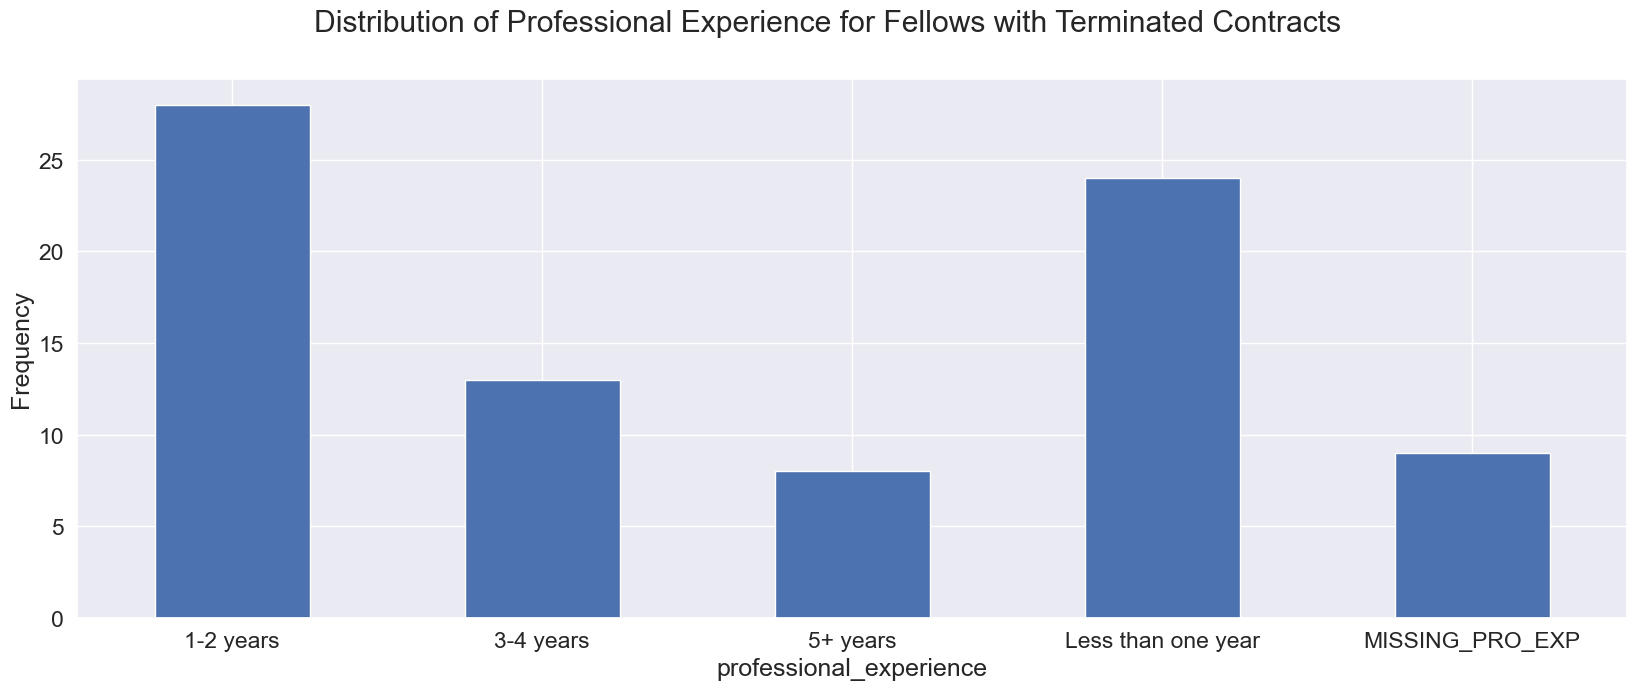

In [129]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Professional Experience for Fellows with Terminated Contracts')
failed_fellows_df.groupby('professional_experience').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

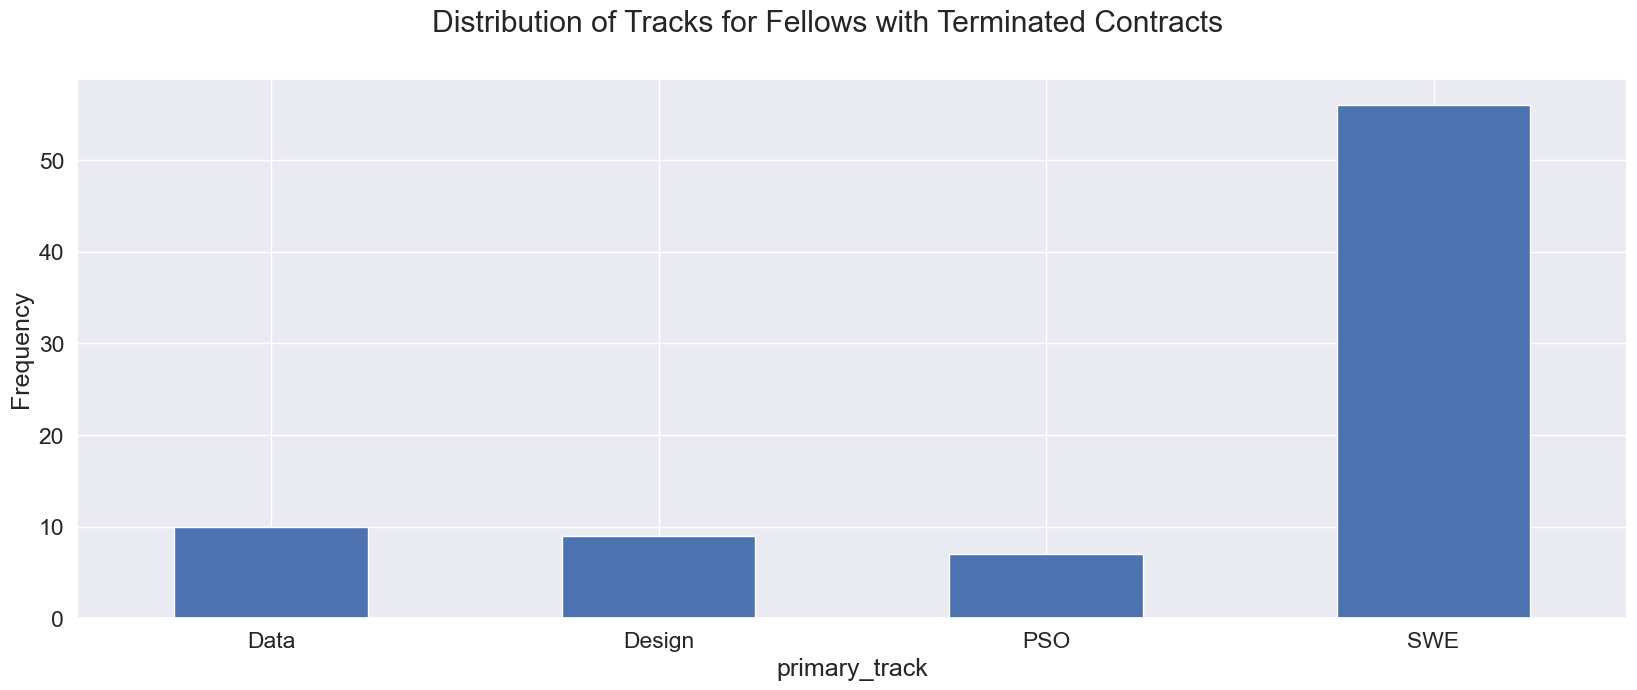

In [130]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Tracks for Fellows with Terminated Contracts')
failed_fellows_df.groupby('primary_track').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

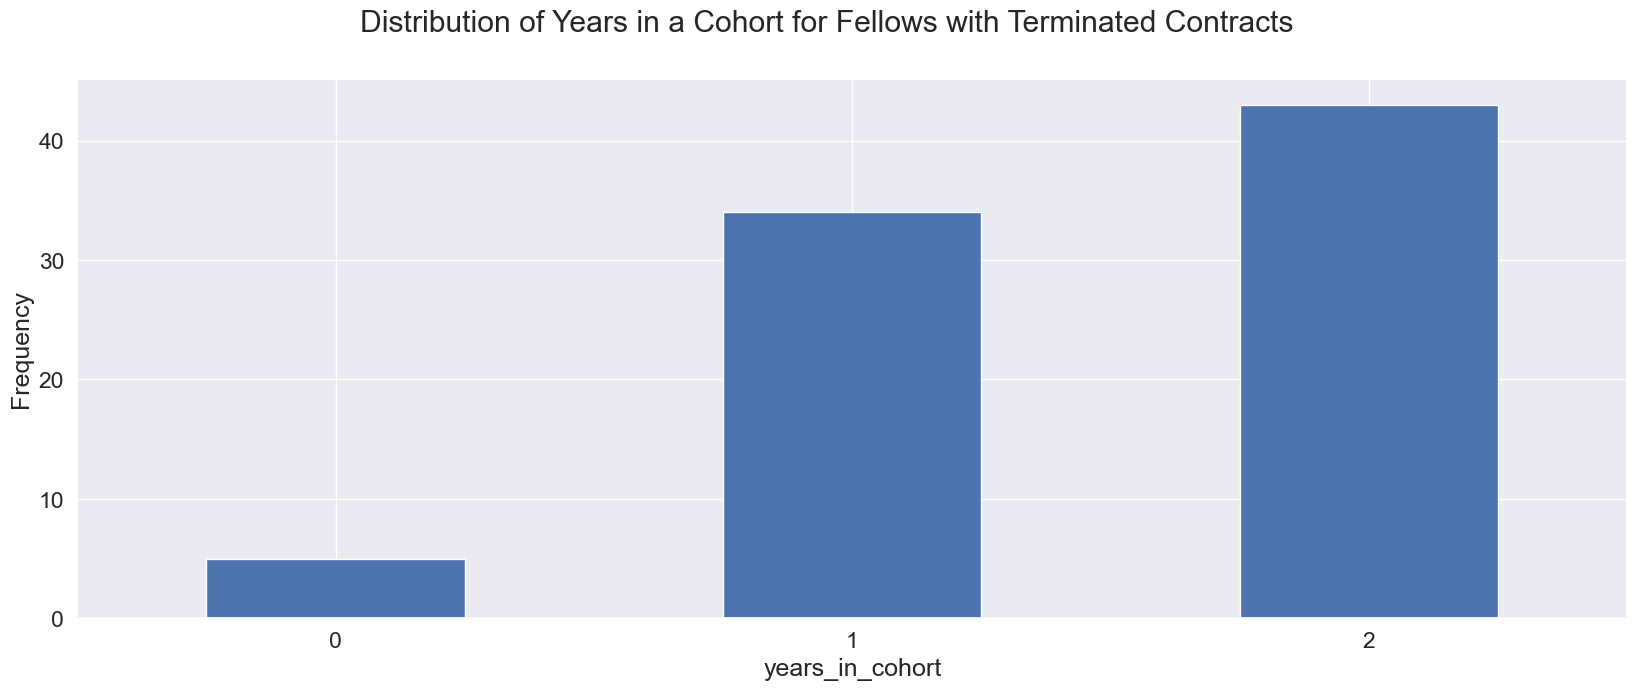

In [131]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Years in a Cohort for Fellows with Terminated Contracts')
failed_fellows_df['years_in_cohort'].astype('object').to_frame().groupby('years_in_cohort').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

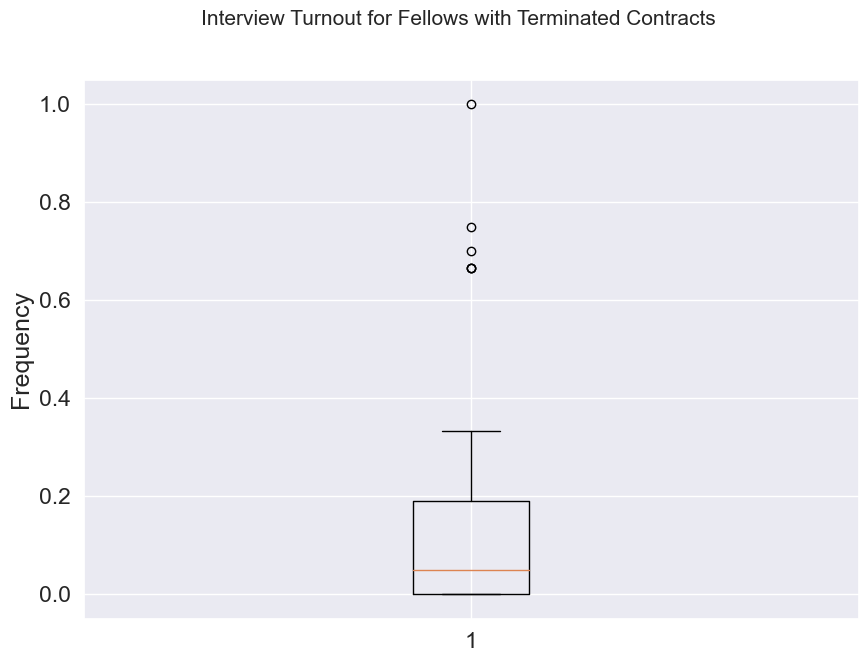

In [132]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Interview Turnout for Fellows with Terminated Contracts', fontsize = 15)
plt.boxplot(failed_fellows_df['interview_turnout'])
plt.ylabel('Frequency')
plt.show()

The distribution of some of these graphs looks similar to other fellows with different statuses. Most were SWE fellows with 1-2 years of professional experience. What differs is the amount of time they spent in their cohort, which for a majority of them was 2 years. 

Again, more analysis could be done to look into how the distribution of these fellows look like.

**Question**: How do fellows similar to me do in the program?

I'm in the Data track and just finished my Bachelor's Degree.

In [133]:
fellows_like_me_df = df[(df['primary_track'] == 'Data')
                        & (df['highest_level_of_education'] == "Bachelor's Degree")]

print('There are %d fellows who have a similar background to me.' % fellows_like_me_df.shape[0])
print('%.2f%% of those fellows placed at a company.' % (100 * fellows_like_me_df['placed'].sum() / fellows_like_me_df.shape[0]))
print('%.2f%% of those fellows were withdrawn after failing.' % (100 * fellows_like_me_df[fellows_like_me_df['pathrise_status'] == 'Withdrawn (Failed)'].shape[0] / fellows_like_me_df.shape[0]))

There are 137 fellows who have a similar background to me.
40.15% of those fellows placed at a company.
3.65% of those fellows were withdrawn after failing.


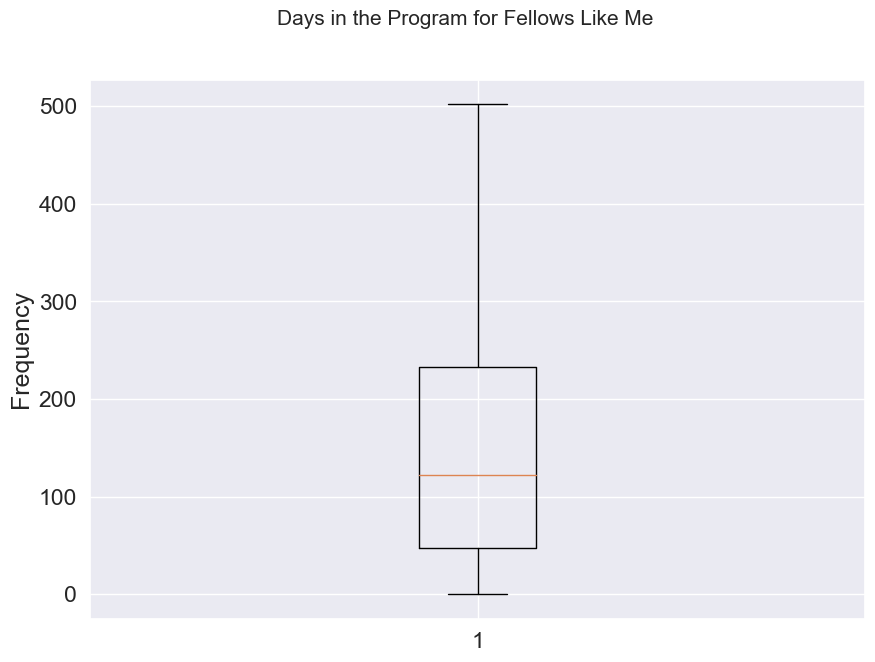

In [134]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Days in the Program for Fellows Like Me', fontsize = 15)
plt.boxplot(fellows_like_me_df['program_duration_days'])
plt.ylabel('Frequency')
plt.show()

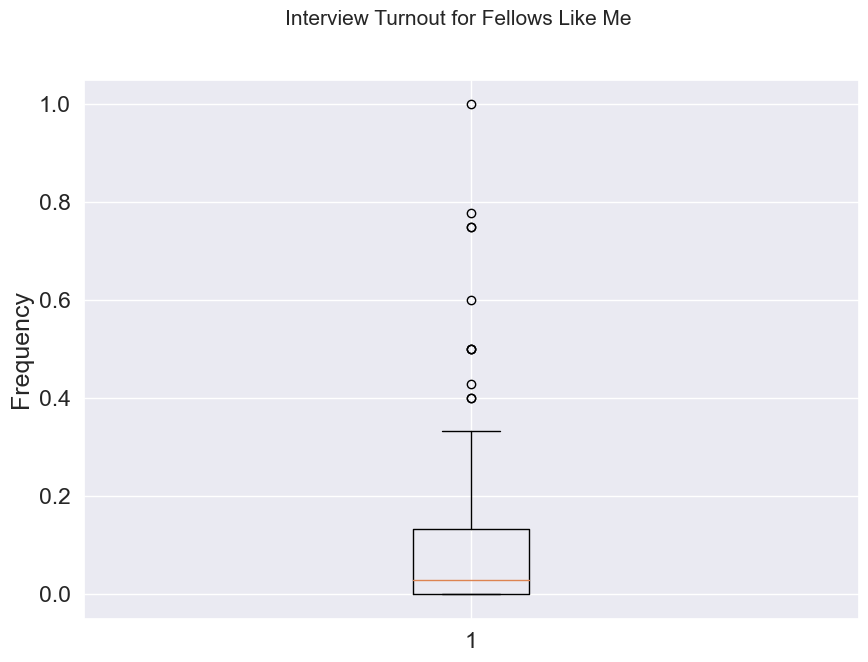

In [135]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Interview Turnout for Fellows Like Me', fontsize = 15)
plt.boxplot(fellows_like_me_df['interview_turnout'])
plt.ylabel('Frequency')
plt.show()

40% of fellows with a similar background to my own have been able to place at a company. As for the interview turnout, it seems that most have been able to get at least 5% to 10% of their applications to turnover into an interview. The median amount of days to spend in this program is a little over 100 days, which is about 3.5 months. This gives me some comfort in my place in the program, as I was always anxious seeing so many other people in my track with tons of experience. 

<center><h1 style="color:red;border:1px solid blue;border-radius:20px;padding:10px 15px;line-height:27px">
Modeling the Data
</h1></center>


In [136]:
# Get appropriate features for classification and regression problems
placed_model_features = one_hot_categ_vars_placed + quant_enc_vars 
placed_model_features.append('log_program_duration_days') # Include program_duration_days because it's an independent variable in this problem

placement_time_model_features = one_hot_categ_vars_place_time + quant_enc_vars

# Split the data
placed_X_train_val, placed_X_test, placed_y_train_val, placed_y_test = train_test_split(df[placed_model_features].values, 
                                                                                        df['placed'].values, 
                                                                                        test_size = 0.2, 
                                                                                        random_state = 42)

placement_time_X_train_val, placement_time_X_test, placement_time_y_train_val, placement_time_y_test = train_test_split(df[placement_time_model_features].values, 
                                                                                                                        df['log_program_duration_days'].values, 
                                                                                                                        test_size = 0.2, random_state = 42)

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
lr = LogisticRegression()
lr.fit(placed_X_train_val,placed_y_train_val)
lr_p = lr.predict(placed_X_test)
print(classification_report(placed_y_test, lr_p), confusion_matrix(placed_y_test, lr_p))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       306
           1       1.00      0.99      1.00       193

    accuracy                           1.00       499
   macro avg       1.00      1.00      1.00       499
weighted avg       1.00      1.00      1.00       499
 [[306   0]
 [  1 192]]


In [138]:
n_folds = 10

## Predicting `placed`


Since this is an imbalanced dataset i.e., ~38% placed at companies, I shouldn't use accuracy as a metric. Instead, I'll use the F1 Score, which combines the recall and precision.

### Simple Logistic Regression Model

Let's start with a simple model.

In [139]:
kf = KFold(n_splits = n_folds, shuffle = True, random_state = 42)

train_f1_scores = []
val_f1_scores = []
placed_lreg = LogisticRegression()

# Perform K-Fold CV
for train_inds, val_inds in kf.split(placed_X_train_val):
    X_train, X_val = placed_X_train_val[train_inds], placed_X_train_val[val_inds]
    y_train, y_val = placed_y_train_val[train_inds], placed_y_train_val[val_inds]
    
    placed_lreg.fit(X_train, y_train)
    train_preds = placed_lreg.predict(X_train)
    val_preds = placed_lreg.predict(X_val)
    
    train_f1_scores.append(f1_score(y_train, train_preds))
    val_f1_scores.append(f1_score(y_val, val_preds))

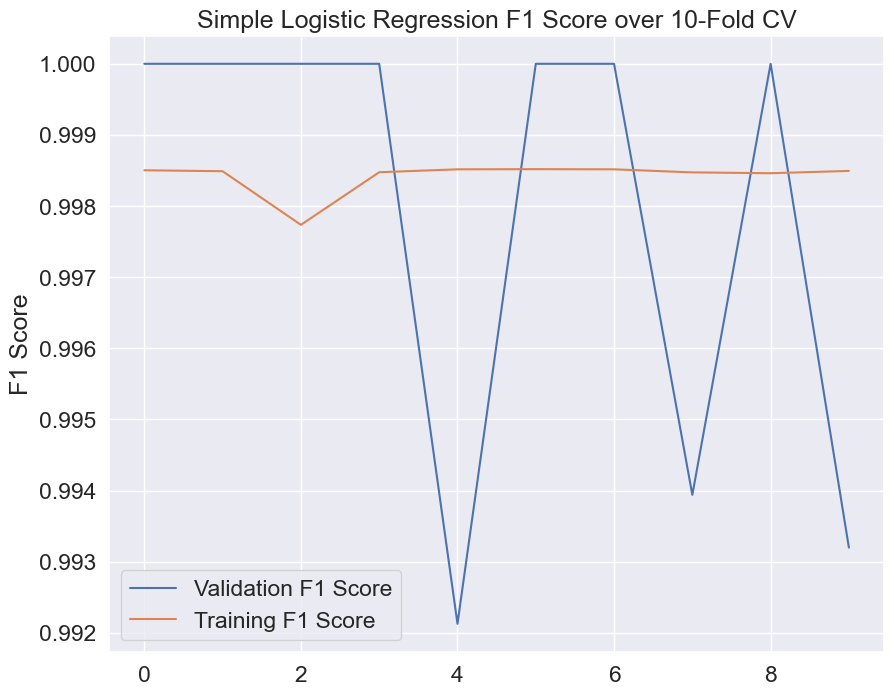

In [140]:
f, ax = plt.subplots(figsize=(10,8))
plt.plot(np.arange(0, n_folds), val_f1_scores, label = 'Validation F1 Score')
plt.plot(np.arange(0, n_folds), train_f1_scores, label = 'Training F1 Score')
plt.ylabel('F1 Score')
plt.title('Simple Logistic Regression F1 Score over 10-Fold CV')
plt.legend()
plt.show()

In [141]:
print('Best Validation F1 Score:', val_f1_scores[np.argmax(val_f1_scores)])

Best Validation F1 Score: 1.0


In [142]:
# See how well it performs on the test set
print('F1 Score on Test Set: %.4f' % f1_score(placed_y_test, placed_lreg.predict(placed_X_test)))

F1 Score on Test Set: 0.9922


The above graph is odd in that this suggests my model is almost perfect. There are some signs of overfitting, but other than my model is able to achieve perfect scores on the validation set.
To get a better understanding of the model performance, let's look at the ROC Curve and AUC.

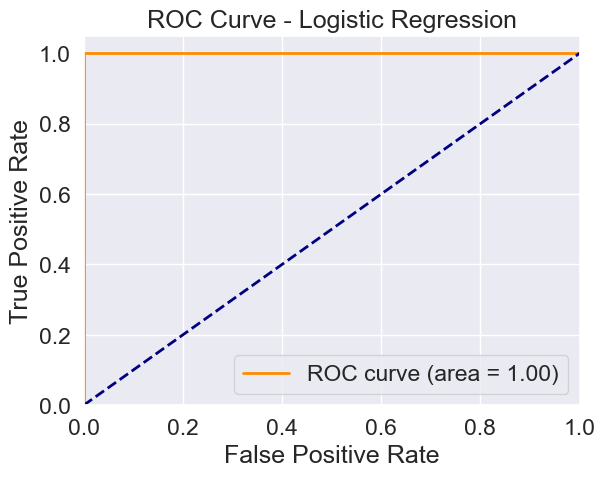

In [143]:
# Compute ROC curve and AUC 
fpr, tpr, thresholds = roc_curve(placed_y_test, 
                                 placed_lreg.decision_function(placed_X_test))
calc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         lw = 2, label='ROC curve (area = %0.2f)' % calc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

As you can see, I'm getting an AUC of 1, which means that I am perfectly predicting placed fellows and non-placed fellows for the testing set, which is impossible. So, something's going wrong in my modeling.

I looked a bit more into this, and found [this post](https://stats.stackexchange.com/questions/184804/very-confused-getting-auc-of-1-and-100-accuracy-for-classification-task), which explains that my model has fallen under the Hauck-Donner Effect. This essentially means that my model has achieved perfect separation because of extreme parameter estimates. This is out of the scope of what I am trying to achieve in this project, but I'm curious to learn more about this.

Instead, I'll assume that my logistic regression model is performing poorly, and won't be able to generalize do new data despite the seemingly great results. Let's move on to a more complicated model.

### XGBoost

In [144]:
xgb_fit_dict = {
    'eval_metric': 'auc',
    "early_stopping_rounds": 15,
    "eval_set": [(placed_X_test, placed_y_test)],
    'verbose': 100
}

xgb_param_dict = {
    'n_estimators': np.arange(10, 100, 10),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'learning_rate': [0.05, 0.1, 0.3],
    'subsample': stats.uniform(loc=0.2, scale=0.8),
    'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
    'gamma': [0.0, 0.1, 0.2],
    'max_depth': [5, 7, 10],
    'min_child_samples': stats.randint(100, 500), 
    "objective": ["binary:logistic"],
    'alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}


placed_xgb_model = XGBClassifier(seed = 42, metric = 'None', n_jobs = 4, silent = True)

rs_clf = RandomizedSearchCV(placed_xgb_model, random_state = 42, 
                            param_distributions = xgb_param_dict, 
                            n_iter = 50, 
                            cv = n_folds, 
                            scoring = 'f1', 
                            verbose = False) 

In [145]:
# Only train if there does not exist a saved model
placed_xgb_saved_model = 'placed_best_xgb_model.pickle.dat'

if path.exists(placed_xgb_saved_model):
    print('I already have a saved model.')
    
    # Load in saved model
    placed_best_xgb_model = pickle.load(open(placed_xgb_saved_model, 'rb'))
    
    print('Saved Model Parameters')
    print(placed_best_xgb_model.get_xgb_params())
    
    # Compute saved model's MSE for test set
    best_xgb_preds = placed_best_xgb_model.predict(placed_X_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("F1 Score on Test Set: %.4f" % f1_score(placed_y_test, best_xgb_preds))
    
else:
    print('Starting to train...')
    
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(placed_X_train_val, placed_y_train_val, **xgb_fit_dict)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Get best params
    xgb_best_params = rs_clf.best_params_
    
    # Train using best params
    placed_best_xgb_model = XGBClassifier(**xgb_best_params, seed = 42)
    start = time.time()
    placed_best_xgb_model.fit(placed_X_train_val, placed_y_train_val)
    
    # Get MSE
    best_xgb_preds = placed_best_xgb_model.predict(placed_X_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("F1 Score on Test Set: %.4f" % f1_score(placed_y_test, best_xgb_preds))
    
    # Save best xgb model
    pickle.dump(placed_best_xgb_model, open(placed_xgb_saved_model, 'wb'))

I already have a saved model.
Saved Model Parameters
{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8013047515981644, 'eval_metric': None, 'gamma': 0.0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'interaction_constraints': '', 'learning_rate': 0.1, 'max_bin': 256, 'max_cat_threshold': 64, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 10, 'max_leaves': 0, 'min_child_weight': 1e-05, 'monotone_constraints': '()', 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 10, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.29567539675064136, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'alpha': 10, 'lambda': 1, 'min_child_samples': 134, 'seed': 42}
Model took 0.00 seconds to complete.
F1 Score on Test Set: 0.9554


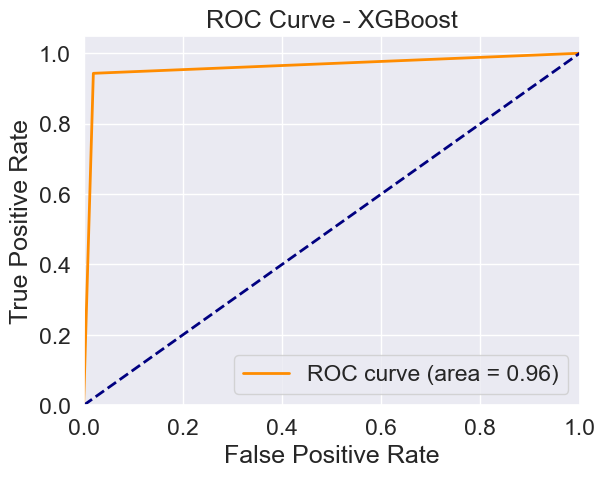

In [146]:
# Compute ROC curve and AUC 
fpr, tpr, thresholds = roc_curve(placed_y_test, 
                                 placed_best_xgb_model.predict(placed_X_test))
calc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         lw = 2, label='ROC curve (area = %0.2f)' % calc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

In general, my XGBoostClassifier model performs very well, but a little too well. This is suspicious, and if given more time, I'd definitely go back and alter some stuff to try and see if I can get reasonable results from my classification models.

For now, let's go more into what features are important. 

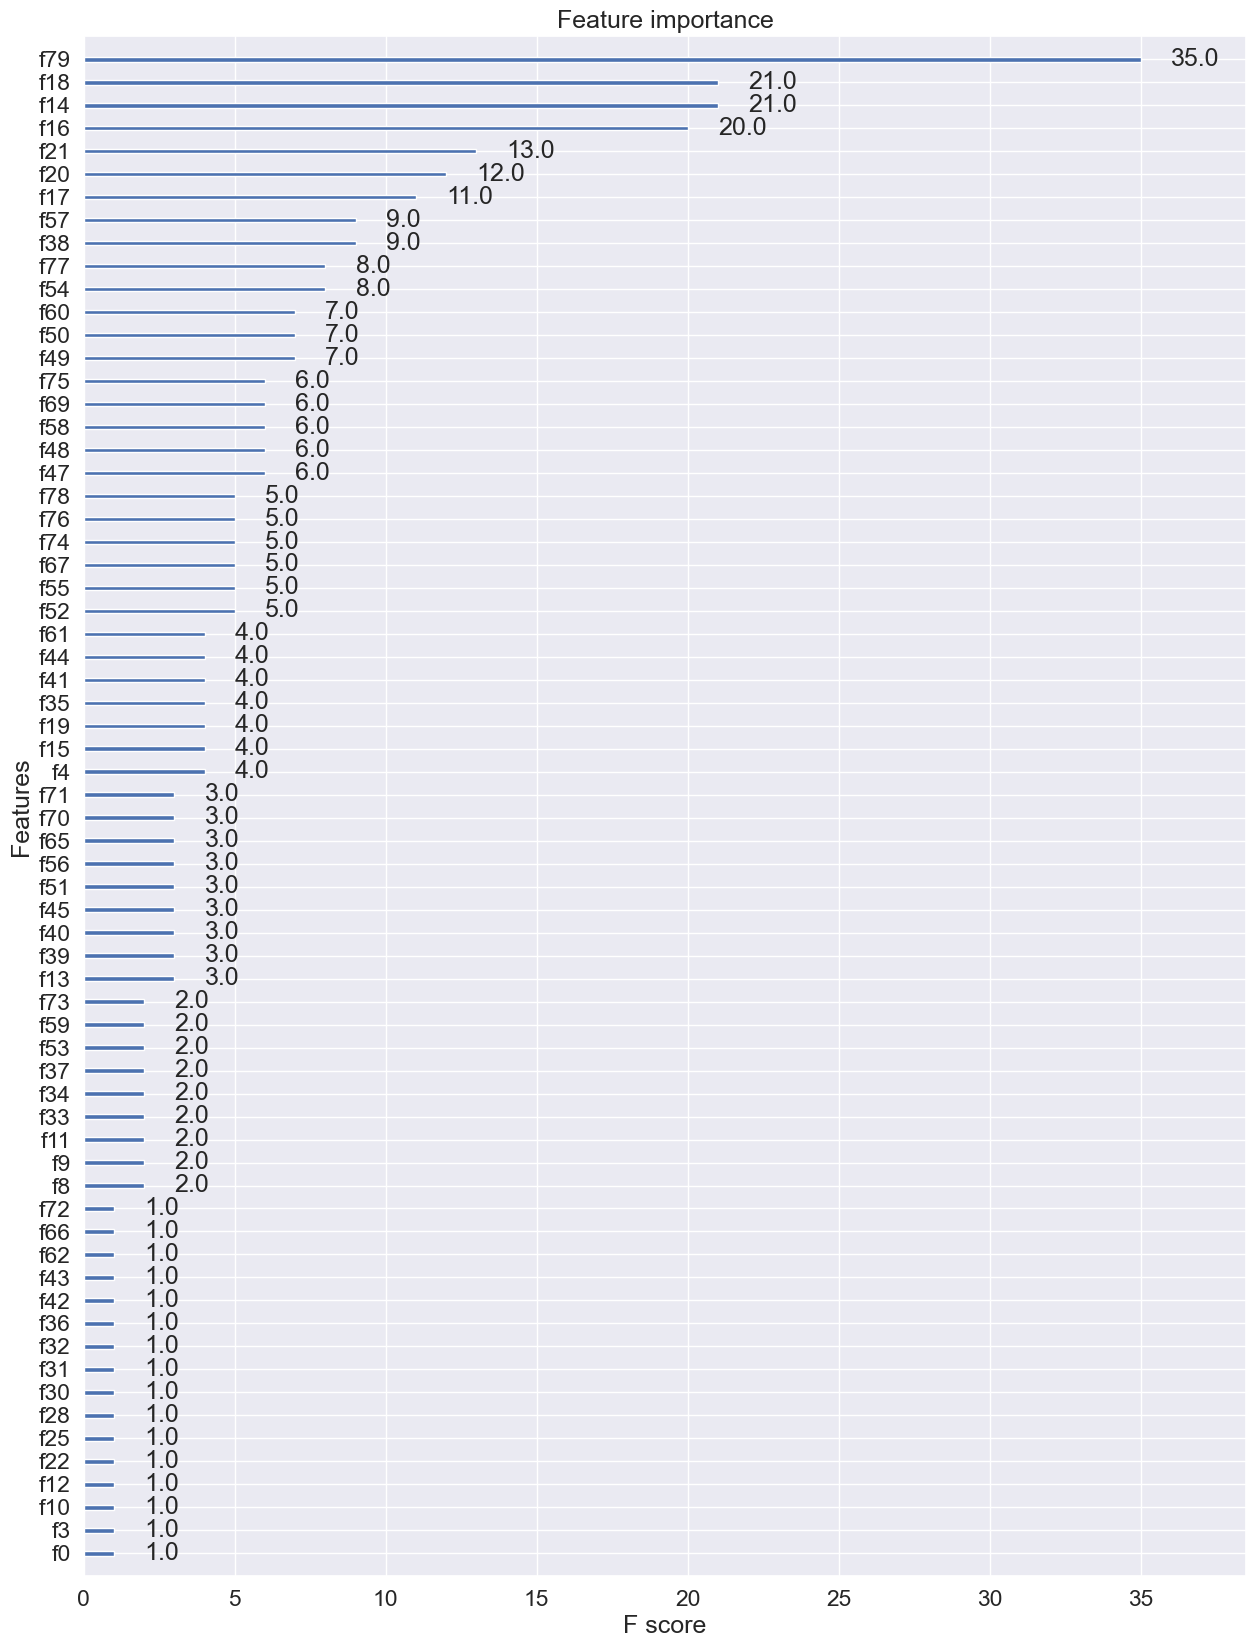

In [147]:
# Look at feature importance
f, ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(placed_best_xgb_model, ax = ax)
plt.show()

In [148]:
# What are the some of the most important features?
print(df[placed_model_features].columns[79])
print(df[placed_model_features].columns[16])
print(df[placed_model_features].columns[17])
print(df[placed_model_features].columns[0])
print(df[placed_model_features].columns[14])
print(df[placed_model_features].columns[18])
print(df[placed_model_features].columns[21])
print(df[placed_model_features].columns[6])
print(df[placed_model_features].columns[20])
print(df[placed_model_features].columns[5])

log_program_duration_days
Withdrawn (Failed)
Withdrawn (Trial)
Male
Active
Withdrawn
MIA
East Asian or Asian American
Break
Non-Hispanic White or Euro-American


By far, the most important feature in determining whether or not a fellow is placed is the number of days in the program, which makes sense. 

The status of the fellow is also important, particularly whether or not they withdrew from the program. If a fellow withdraws, then they can't be placed at a company.

Gender and race also seem to be important features.

## Predicting `program_duration_days`

### Simple Linear Regression

Let's start off with this and just get a general understanding of the data.

In [149]:
kf = KFold(n_splits = n_folds, shuffle = True, random_state = 42)

train_mses = []
val_mses = []
placement_time_lreg = LinearRegression()

# Perform K-Fold CV
for train_inds, val_inds in kf.split(placement_time_X_train_val):
    X_train, X_val = placement_time_X_train_val[train_inds], placement_time_X_train_val[val_inds]
    y_train, y_val = placement_time_y_train_val[train_inds], placement_time_y_train_val[val_inds]
    
    placement_time_lreg.fit(X_train, y_train)
    train_preds = placement_time_lreg.predict(X_train)
    val_preds = placement_time_lreg.predict(X_val)
    
    train_mses.append(mean_squared_error(y_train, train_preds))
    val_mses.append(mean_squared_error(y_val, val_preds))

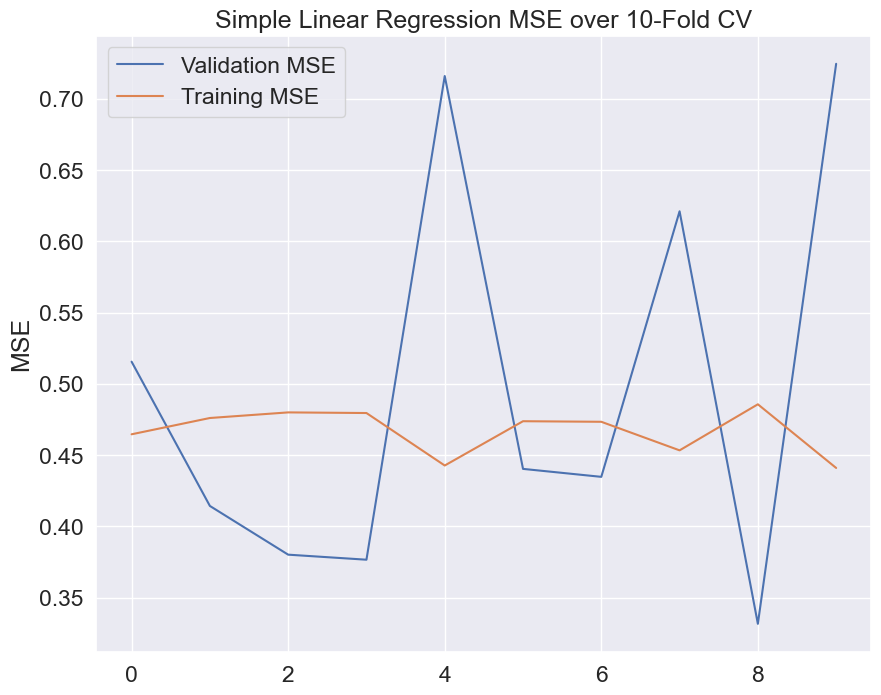

In [150]:
f, ax = plt.subplots(figsize=(10,8))
plt.plot(np.arange(0, n_folds), val_mses, label = 'Validation MSE')
plt.plot(np.arange(0, n_folds), train_mses, label = 'Training MSE')
plt.ylabel('MSE')
plt.title('Simple Linear Regression MSE over 10-Fold CV')
plt.legend()
plt.show()

In [151]:
print('Best Validation MSE:', val_mses[np.argmax(val_mses)])

Best Validation MSE: 0.7246661271318541


In [152]:
# See how well it performs on the test set
print('MSE on Test Set: %.4f' % mean_squared_error(placement_time_lreg.predict(placement_time_X_test), placement_time_y_test))

MSE on Test Set: 0.5337


We can see that there is lots of variability in the dataset, shown by the strong variation of the validation MSE. While the training MSE is stagnant, the validation MAE varies much more, suggesting overfitting and high variance. Also, linear regression doesn't perform too well in terms of the Mean Squared Error. 0.72 is the best validation MSE, but this is not that great in terms of model performance. 

As for the test set, linear regression performs decently, getting an MSE of 0.53.

I'll use a more complicated model now: XGBoost. Boosting may help reduce the variance in the data, and XGBoost comes with a great function to determine which features are more important in determining `program_duration_days`.

### XGBoost

In [153]:
xgb_fit_dict = {
    'eval_metric': 'rmse',
    "early_stopping_rounds": 15,
    "eval_set": [(placement_time_X_test, placement_time_y_test)],
    'verbose': 100
}

xgb_param_dict = {
    'n_estimators': np.arange(10, 100, 10),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'learning_rate': [0.05, 0.1, 0.3],
    'subsample': stats.uniform(loc=0.2, scale=0.8),
    'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
    'gamma': [0.0, 0.1, 0.2],
    'max_depth': [5, 7, 10],
    'min_child_samples': stats.randint(100, 500), 
    "objective": ["reg:squarederror"],
    'alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

placement_time_xgb_model = XGBRegressor(seed = 42, metric = 'None', n_jobs = 4, silent = True)

rs_clf = RandomizedSearchCV(placement_time_xgb_model, random_state = 42, 
                            param_distributions = xgb_param_dict, 
                            n_iter = 50, 
                            cv = n_folds, 
                            scoring = 'neg_mean_squared_error', 
                            verbose = False) 

In [154]:
# Only train if there does not exist a saved model
placement_time_xgb_saved_model = 'placement_time_best_xgb_model.pickle.dat'

if path.exists(placement_time_xgb_saved_model):
    print('I already have a saved model.')
    
    # Load in saved model
    placement_time_best_xgb_model = pickle.load(open(placement_time_xgb_saved_model, 'rb'))
    
    print('Saved Model Parameters')
    print(placement_time_best_xgb_model.get_xgb_params())
    
    # Compute saved model's MSE for test set
    best_xgb_preds = placement_time_best_xgb_model.predict(placement_time_X_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MSE on Test Set: %.4f" % mean_squared_error(placement_time_y_test, best_xgb_preds))
    
else:
    print('Starting to train...')
    
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(placement_time_X_train_val, placement_time_y_train_val, **xgb_fit_dict)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Get best params
    xgb_best_params = rs_clf.best_params_
    
    # Train using best params
    placement_time_best_xgb_model = XGBRegressor(**xgb_best_params, seed = 42)
    start = time.time()
    placement_time_best_xgb_model.fit(placement_time_X_train_val, placement_time_y_train_val)
    
    # Get MSE
    best_xgb_preds = placement_time_best_xgb_model.predict(placement_time_X_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MSE on Test Set: %.4f" % mean_squared_error(placement_time_y_test, best_xgb_preds))
    
    # Save best xgb model
    pickle.dump(placement_time_best_xgb_model, open(placement_time_xgb_saved_model, 'wb'))


I already have a saved model.
Saved Model Parameters
{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9282807034091546, 'eval_metric': None, 'gamma': 0.1, 'gpu_id': -1, 'grow_policy': 'depthwise', 'interaction_constraints': '', 'learning_rate': 0.1, 'max_bin': 256, 'max_cat_threshold': 64, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 5, 'max_leaves': 0, 'min_child_weight': 0.1, 'monotone_constraints': '()', 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 7, 'reg_lambda': 10, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.9168730399387945, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'alpha': 7, 'lambda': 10, 'min_child_samples': 233, 'seed': 42}
Model took 0.00 seconds to complete.
MSE on Test Set: 0.5059


We see above that I was able to reduce the MSE by about 0.03 when using the XGBoost regressor algorithm.

Other methods could be looked at to improve the model, such as reducing the feature space, but that's not my main goal for this project. My main objective is to understand the features that influence fellow placement time. Let's do that now, below.

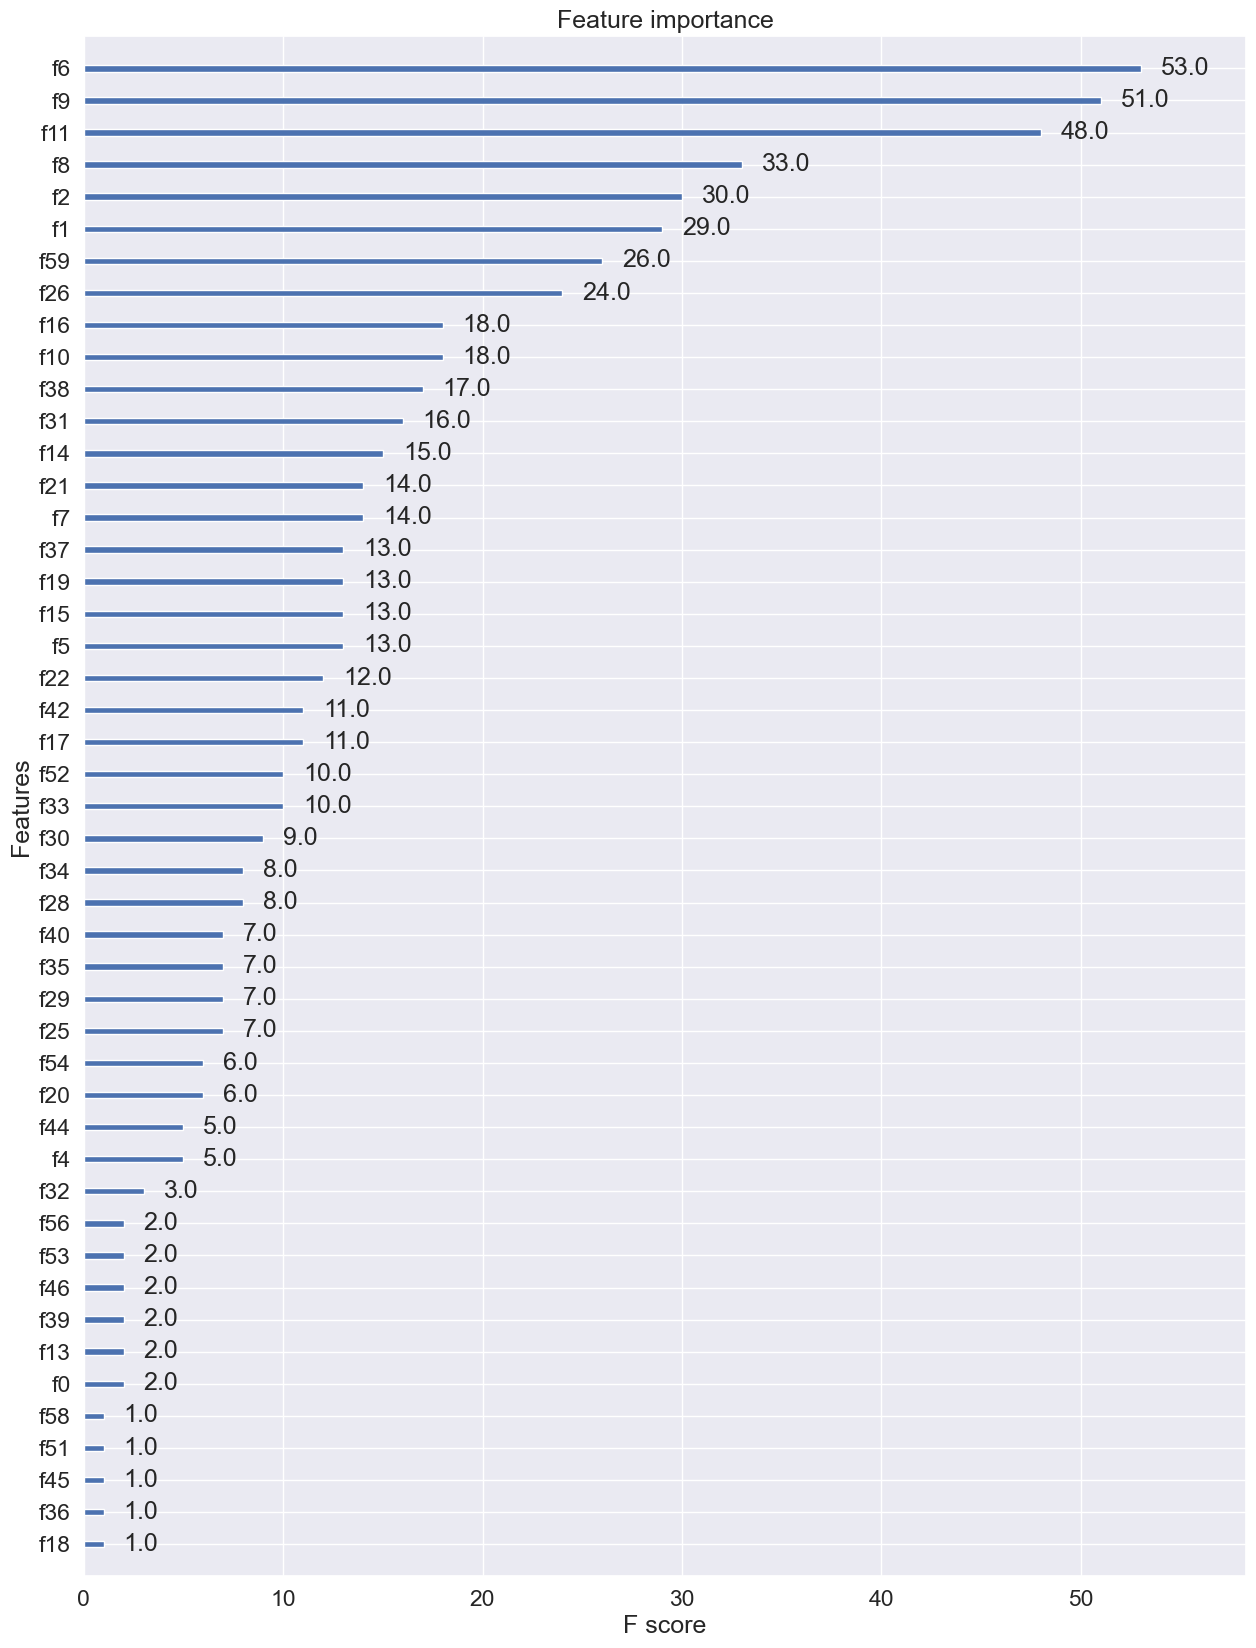

In [155]:
# Look at feature importance
f, ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(placement_time_best_xgb_model, ax = ax)
plt.show()

In [156]:
# What are the some of the most important features?
print(df[placement_time_model_features].columns[7])
print(df[placement_time_model_features].columns[2])
print(df[placement_time_model_features].columns[1])
print(df[placement_time_model_features].columns[9])
print(df[placement_time_model_features].columns[0])
print(df[placement_time_model_features].columns[8])
print(df[placement_time_model_features].columns[10])
print(df[placement_time_model_features].columns[6])
print(df[placement_time_model_features].columns[11])
print(df[placement_time_model_features].columns[19])

Placed
MISSING_GENDER
Female
Withdrawn (Trial)
Male
Withdrawn (Failed)
Withdrawn
Closed Lost
Deferred
AUG19C


Above are the top 10 features most important when it came to the XGBoostRegressor model. These features were chosen based on how many split were made at the feature. 

The top feature is `Placed`, which makes sense, considering that `program_duration_days` was how long the fellow stayed in Pathrise until they were placed.

Gender information e.g., being a male, female, or missing information on there, are also important features. Initially, I didn't think gender influenced the time it took to be placed, but it seems that there is some importance to gender after all.

It also makes sense that the `pathrise_status` concerning withdrawal from the program, or any other similar status, are important, too. If the fellow is not part of Pathrise anymore, then that affects how long they've been a part of Pathrise, and whether or not they get placed. 

It would also seem that being in the August 2019 cohort was somewhat important in determining `program_duration_days`. That's close to the time when the graduating class of 2019 finished up school, and since most fellows state to have just completed their Bachelor's, it makes sense that this is an important cohort. 

# Conclusion

Pathrise's goal is to help fellows get placed at a company quickly. I'll recap the insights that I found from all of my analysis above, and then make some recommendations for Pathrise:


Again, the statistically significant variables for the classification problem are:
- `gender`
- `race`
- `pathrise_status`
- `professional_experience`
- `primary_track`
- `cohort_tag`
- `program_duration_days`
- `years_in_cohort`

For the regression problem, they are:
- `gender`
- `pathrise_status`
- `cohort_tag`
- `years_in_cohort`

## Insights

- Amongst placed and non-placed fellows, the distribution over all independent variables are almost equal. 

- Most fellows, regardless of being placed at a company:
    - were in the SWE track 
    - completed either a Bachelor's Degree of Master's Degree as their highest level of education 
    - has less than a year to two years of experience
    - were US Citizens
    - found it difficult to hear back from applications
    - have been looking for a job for less than a month to two months
    - are male
    - are unemployed or are students
    - and are East Asian, Asian American, or Non-Hispanic White or Euro-American. 
    
    
- **Fellows, regardless of placement, sent out a similar spread of applications**, the median of which is 20 applications. However, there are more outliers amongst and a wider range of applications sent out for non-placed fellows. Additionally, the median number of interviews for both placed and non-placed fellows was around 1.

- The **median number of days a fellow has spend in the program, regardless of being placed or not, is around 111 days**, or over 3.5 months. This goes inline with what Pathrise reports to be the average time a fellow has in the program to be placed.

- **Lots of fellows are fresh out of college or about to graduate college, or have graduted from college some time ago and are currently unemployed**, as a majority of them report to be students or unemployed and have a Bachelor's Degree as their highest level of education. This points the how **most fellows are either "fresh" to the job-market or have been struggling finding a job (but not for a long time, since most fellows report having spend 0-2 months looking for a job)**. 

- The cohort that a fellow came from plays a factor in determining placement and placement time. More specifically, **most 2020 fellows haven't been placed yet, suggesting that it takes time to "get the ball rolling"**. But that doesn't mean that a 2018 fellow will be more likely to be placed than a 2019 fellow - **regardless of cohort, it still takes time same amount of time to get placed** i.e., being from an older cohort doesn't mean you'll be placed at a company sooner. The years in a cohort turned out to be significant.

- **Most fellows, regardless of placed or not, get interviews from around 3% of the applications they submit**. This interview turnout, though, turned out to not be significant.

- **Almost 30% of the fellows with interviews already coming into Pathrise drop out**. This suggests that fellows in this situation just want to try Pathrise out and see what it's like i.e., a common characteristic amongst Pathrise fellows is that they already have a potential job prospect on the line.

- **Most 2018 cohorts had their contracts terminated**, again suggesting that being from an older cohort doesn't mean you'll get placed into a company sooner.

- The most important features for both problems involved the fellow's status and their gender, according to my XGBoost models. 

- **Sending out more applications doesn't mean you'll get placed faster.** Let's look at the range of applications sent for placed and non-placed fellows.

In [157]:
# Range of number_of_applications for placed fellows
df[df['placed'] == 1]['number_of_applications'].max() - df[df['placed'] == 1]['number_of_applications'].min()

400

In [158]:
# Range of number_of_applications for non-placed fellows
df[df['placed'] == 0]['number_of_applications'].max() - df[df['placed'] == 0]['number_of_applications'].min()

1000

We see that there's a wider range of applications sent out by non-placed fellows, suggesting that non-placed fellows sent out a lot more applications than placed fellows. This implies that it's not the quantity of applications sent out that impacts placement. It's probably other factors, such as *where these applications are sent*.  

I'd like to state the most important insight I had. Earlier I showed that my classification model was near perfect (results that should be looked more into, but nevertheless). The most important features for that model was the status of the fellow. More specifically, whether or not the fellow withdrew from the program. In addition to seeing that placed and non-placed fellows come from similar backgrounds and do similar things whilst in the program, this suggests that **as long as fellows stay in the program, they'll get placed**. So, let's look at **how** to make fellows stay.

## Recommendations
**1) Emphasize to fellows early on that it's not the amount of applications sent out, but the quality and where these applications are sent.** Making this clear is crucial so that fellows don't wear themselves out in sending out applications. I already showed that non-placed fellows send out a wider range of applications. Below, we see that once fellows send out an amount of applications above the median, then more of them withdraw from the program. In fact, **almost 44% of fellows who haven't placed have withdrawn from the trial or the entire program in general after sending out more than the median number of applications (20)**. 

Since I'm in the program, I know what happens in the intro workshop. This kind of information isn't mentioned, and so I think Pathrise could benefit if they make it clear to fellows, especially since most of them are eager to get a job and are new to the job-market, that it's quality over quantity when it comes to sending out applications. And Pathrise can teach you **how** to make your application high-quality. 

In [159]:
median_num_apps = df['number_of_applications'].median()
df[(df['placed'] == 0) & (df['number_of_applications'] > median_num_apps)].groupby('pathrise_status').size()

pathrise_status
Active                245
Break                  12
Closed Lost            88
Deferred               13
MIA                    29
Withdrawn             191
Withdrawn (Failed)     33
Withdrawn (Trial)     135
dtype: int64

**2) Look for ways to make fellows stay in the program.** I listed one way above, but there are certainly many other ways to make fellows stay in the program. More advice can be given to recent graduates or fellows with an interview already prior to coming to Pathrise. Lots of fellows are new to the job-market, so it's imperative to look at ways to make them stay in the program. I'd love to do more analysis into what makes a fellow stay/ leave given more data. I go more into a possible project below. 

# Extension


Let's look at how long fellows who withdrew stayed in the program.

In [160]:
df[(df['pathrise_status'] == 'Withdrawn') | (df['pathrise_status'] == 'Withdrawn (Trial)')]['program_duration_days'].describe()

count    659.000000
mean     111.649469
std      115.374414
min        1.000000
25%       11.000000
50%       63.000000
75%      199.000000
max      534.000000
Name: program_duration_days, dtype: float64

We see that the median number of days spent in the program for a fellow who withdrew was about 63 days, or 2 months. There isn't any data here regarding feedback after leaving the program in the dataset I was given. More analysis can be done into why these fellows are withdrawing before the 3.5 month mark that Pathrise claims is the average amount of time to get a job within the program (a claim that's correct, after my analysis). An extension to this project would be to analyze the factors that lead to fellows leaving the program given feedback forms. 

I hope that you have enjoyed my analysis of the factors impacting placement and placement time. Thank you for taking the time to read my analysis.